<a href="https://colab.research.google.com/github/xli07/PolicySIR/blob/main/PolicySIR_7_5_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up

In [ ]:
import numpy as np
import copy
from scipy.optimize import minimize_scalar
# import scipy.special.lambertw as lambertw
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import seaborn as sns
import collections
import math
import os
import datetime
import matplotlib.dates as mdates

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# plot set up
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
FEDERAL_COLOR = 'tab:blue'
state_color = 'tab:orange'
county_color = ['tab:green', 'tab:red', 'tab:brown', 'tab:pink','tab:olive']
PATH = '/content/drive/MyDrive/Research/PolicySIR/figure'

!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
time: 323 µs (started: 2024-06-03 03:35:21 +00:00)


# Functions

## SIR functions

In [ ]:
def deterministic_sir(beta, gamma, n, T, i0, s0=None,policy=1,h=1):
# Compute susceptible population, set recovered to zero
  if s0 == None:
    S = [n - i0*n]
  else:
    S = [s0*n]
  I = [i0*n]
  R = [n - S[-1] - I[-1]]
  # print(S,I,R)
  m = int(1/h)
  for i in range(1,int(T/h)):
    st = S[-1]
    it = I[-1]
    rt = R[-1]
    # print(i)
    if it <= 0:
      break
    S.append(st - policy*h*(beta * st * it/ n))
    I.append(it + h*(policy*beta * st * it / n - gamma * it))
    R.append(rt + h*gamma * it)
    # print('from S',policy*beta * st * it / n)



  return S, I, R
  # return S[::m], I[::m], R[::m]

time: 1.28 ms (started: 2024-06-03 03:35:21 +00:00)


In [ ]:
def update_compartment(S,I,R, ks, ki, kr, delta_t=1):
  S_new, I_new, R_new = np.zeros_like(S),np.zeros_like(I),np.zeros_like(R)
  for i in range(len(S)):
    # print(S*ks[i].shape)
    # print(S.shape)
    # print(ks.shape)
    # print(ks[i].shape)
    S_new[i] = np.dot(S, ks[i]) - np.sum(S[i]*ks[:,i]) + S[i]*ks[i,i]
    I_new[i] = np.dot(I, ki[i]) - np.sum(I[i]*ki[:,i]) + I[i]*ki[i,i]
    R_new[i] = np.dot(R, kr[i]) - np.sum(R[i]*kr[:,i]) + R[i]*kr[i,i]
  return S_new,I_new,R_new

time: 1.18 ms (started: 2024-06-03 03:35:21 +00:00)


In [ ]:
def update_SIR(S,I,R, policy,county_pop, beta, gamma,h=1/3):
  for i in range(int(1/h)):
    if I < 1:
      I = 0
    S_temp = S
    I_temp = I
    R_temp = R
    S = S - policy * beta * S * I/county_pop * h
    I = I_temp + policy * beta * S_temp * I_temp/county_pop*h - gamma * I_temp* h
    R = R_temp + gamma * I_temp*h
  return S,I,R

time: 2.05 ms (started: 2024-06-03 03:35:21 +00:00)


In [ ]:
def update_network_SIR(S,I,R, policy, county_pop, K, beta, gamma):
  S_new, I_new, R_new = np.zeros_like(S,dtype=float),np.zeros_like(I,dtype=float),np.zeros_like(R,dtype=float)
  for i in range(len(S)):
    if I[i] < 1:
      I[i] = 0
    S_new[i] = S[i] - policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i]
    I_new[i] = I[i] + policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i] - gamma*I[i]
    # print(I_new[i])

    R_new[i] = R[i] + gamma*I[i]
    # print(policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i])
    # print(gamma*I[i])
    # print(R[i] + gamma*I[i])
    # print(R_new[i])
    # if S_new[i] + I_new[i] + R_new[i] != county_pop[i]:
    #   print('POPULATION NOT EQUAL!')

  # S_new, I_new, R_new = [],[],[]
  # for i in range(len(S)):
  #   # if I[i] <= 0:
  #   #   break
  #   S_new.append(S[i] - policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i])
  #   I_new.append(I[i] + policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i] - gamma*I[i])
  #   # print(I_new[i])

  #   R_new.append(R[i] + gamma*I[i])
  #   # print(policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i])
  #   # print(gamma*I[i])
  #   print(R_new[-1])
  #   if S_new[i] + I_new[i] + R_new[i] != county_pop[i]:
  #     print('POPULATION NOT EQUAL!')
  return S_new,I_new,R_new


time: 2.16 ms (started: 2024-06-03 03:35:21 +00:00)


In [ ]:
def update_SIR_infinity(S0,I0,county_pop, beta, gamma):
  S =[S0]
  I = [I0]
  R = [county_pop - S0 - I0]
  h=1
  while I[-1] > 1:
    S.append(S[-1] - h*(beta * S[-1] * I[-1] / county_pop))
    I.append(I[-1] + h*(beta * S[-1] * I[-1] / county_pop - gamma * I[-1]))
    R.append(R[-1] + h*gamma * I[-1])
  return S, I, R

time: 870 µs (started: 2024-06-03 03:35:21 +00:00)


In [ ]:
# S = S - policy * beta * S * I/county_pop # dt = 1
# I = I + policy * beta * S * I/county_pop - gamma * I
# R = R + gamma * I
def dSdt(t, S, I, policy, county_pop, beta):
    return - policy * beta * S * I/county_pop
def dIdt(t, S, I, policy, county_pop, beta, gamma):
    return policy * beta * S * I/county_pop - gamma * I
def dRdt(t, I, gamma):
    return gamma * I
# Finds value of y for a given x using step size h
# and initial value y0 at x0.
def rungeKutta(t0, I0, S0, R0, county_pop, policy, beta=0.3, gamma=0.07, delta_t=1, h=1/10):
    # Count number of iterations using step size or
    # step height h
    t = delta_t + t0
    n = int((t - t0)/h)
    # Iterate for number of iterations
    S = S0
    I = I0
    R = R0
    for i in range(1, n + 1):
        "Apply Runge Kutta Formulas to find next value of y"
        k1s = h * dSdt(t0, S, I, policy, county_pop, beta)
        k1i = h * dIdt(t0, S, I, policy, county_pop, beta, gamma)
        k1r = h * dRdt(t0, I, gamma)

        k2s = h * dSdt(t0 + 0.5 * h, S + 0.5 * k1s, I + 0.5 * k1i, policy, county_pop, beta)
        k2i = h * dIdt(t0 + 0.5 * h, S + 0.5 * k1s, I + 0.5 * k1i, policy, county_pop, beta, gamma)
        k2r = h * dRdt(t0 + 0.5 * h, I + 0.5 * k1i, gamma)

        k3s = h * dSdt(t0 + 0.5 * h, S + 0.5 * k2s, I + 0.5 * k2i, policy, county_pop, beta)
        k3i = h * dIdt(t0 + 0.5 * h, S + 0.5 * k2s, I + 0.5 * k2i, policy, county_pop, beta, gamma)
        k3r = h * dRdt(t0 + 0.5 * h, I + 0.5 * k2i, gamma)

        k4s = h * dSdt(t0 + h, S + k3s, I + k3i, policy, county_pop, beta)
        k4i = h * dIdt(t0 + h, S + k3s, I + k3i, policy, county_pop, beta, gamma)
        k4r = h * dRdt(t0 + h, I + k3i, gamma)

        # Update next value of S, I, R
        S = S + (1.0 / 6.0)*(k1s + 2 * k2s + 2 * k3s + k4s)
        I = I + (1.0 / 6.0)*(k1i + 2 * k2i + 2 * k3i + k4i)
        R = R + (1.0 / 6.0)*(k1r + 2 * k2r + 2 * k3r + k4r)
        # Update next value of x
        t0 = t0 + h
    return S,I,R

time: 1.63 ms (started: 2024-06-03 03:35:21 +00:00)


In [ ]:
def network_sir(beta, gamma, T, i0,
                county_pop=[100,100,100,100],
                county_area = [10,10,10,10],
                p1=1,p2=1,dt=1,
                K = None):
  # counties in the game, network SIR
  # Number of nodes in the physical layer
  t = 0
  n_county = len(county_pop)
  n_state = 1
  county_policy =[1]*4

  I = np.zeros((n_county,T))
  S = np.zeros((n_county,T))
  R = np.zeros((n_county,T))

  # Transportation rate matrix
  if not isinstance(K,np.ndarray):
    K = 0.001*np.ones((n_county,n_county))
    # a = np.zeros_like(K)
    np.fill_diagonal(K, 1)
    # K = K - a

  print('Excitation matrix:', K)
  if isinstance(i0,float):
    for i in range(n_county):
      I[i][0] = i0*county_pop[i]
      S[i][0] = (1-i0)*county_pop[i]
  else:
    for i in range(n_county):
      I[i][0] = i0[i]*county_pop[i]
      S[i][0] = (1-i0[i])*county_pop[i]

  for t in range(1,T):
    for i in range(n_county):
      # if I[i][t-1] <= 0:
      #   break # TODO: how to deal with this edge case?

      S[:,t],I[:,t],R[:,t]  = update_network_SIR(S[:,t-1], I[:,t-1],R[:,t-1], county_policy, county_pop, K, beta=beta, gamma=gamma)

  return S,I,R

time: 3.95 ms (started: 2024-06-03 03:35:21 +00:00)


##  Cost functions

In [ ]:
# def cost(alpha, S, I, N, alpha_prev, beta, gamma, kappa = 1/3, eta = 1/3, two_sided=False):
#   if two_sided:
#      return kappa*(1 - alpha) + eta*alpha*beta*S*I/N + (1 - kappa - eta)*max(0,alpha - alpha_prev)**2
#   else:
#     cost = kappa*(1 - alpha) + eta*alpha*beta*S*I/N + (1 - kappa - eta)*(alpha - alpha_prev)**2
#   return cost

def cost(alpha, S, I, N, alpha_prev, beta, gamma, kappa = 1/3, eta = 1/3, two_sided=False):
# impact cost is the asymptotic solution of r
  R0 = alpha*beta/gamma
  if two_sided:
     return kappa*(1 - alpha) + eta*(1+1/R0*lambertw(-S/N*R0*math.exp(-R0*(S+I)/N))) + (1 - kappa - eta)*(alpha - alpha_prev)**2
  else:
    return kappa*(1 - alpha) + eta*(1+1/R0*lambertw(-S/N*R0*math.exp(-R0*(S+I)/N)))+ (1 - kappa - eta)*max(0,alpha - alpha_prev)**2

# def cost_density(alpha,S, I, N, A, alpha_prev, beta, gamma,kappa = 1/3, eta = 1/3, two_sided=False):
# use daily increase for impact cost
#   R = N - S - I
#   if two_sided:
#      return kappa*(1 - alpha) + eta * (alpha * beta * S * I/N - gamma*I)/(N*A) +(1 - kappa - eta)*(alpha - alpha_prev)**2
#   else:
#     return kappa*(1 - alpha) + eta* (alpha * beta * S * I/N - gamma*I)/(N*A) +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2


# def cost_density(alpha,S, I, N, A, alpha_prev, beta, gamma,kappa = 1/3, eta = 1/3, two_sided=False):
# #using lambertw function for final pandemic size for impact cost, issue with complex number
#   R0 = alpha*beta/gamma
#   if two_sided:
#      return kappa*(1 - alpha) + eta * (1+1/R0*lambertw(-S/N*R0*math.exp(-R0*(S+I)/N)))/A +(1 - kappa - eta)*(alpha - alpha_prev)**2
#   else:
#     return kappa*(1 - alpha) + eta* (1+1/R0*lambertw(-S/N*R0*math.exp(-R0*(S+I)/N)))/A +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2

def cost_density(alpha,S, I, N, A, alpha_prev, t,t_prev,beta, gamma,kappa = 1/3, eta = 1/3, two_sided=False):
# using lambertw function for final pandemic size for impact cost, issue with complex number
  _, _, R = deterministic_sir(alpha*beta, gamma,N, 100,I/N,S/N)
  Re = R[-1]
  if two_sided:
     return kappa*(1 - alpha)*(t-t_prev)/90 + eta * Re/(A) +(1 - kappa - eta)*(alpha - alpha_prev)**2
  else:
    return kappa*(1 - alpha)*(t-t_prev)/90  + eta* Re/(A) +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2


def cost_density_constant(alpha, S, I, N, A, alpha_prev, beta, gamma, ts = 30, te = 60, kappa = 1/3, eta = 1/3, two_sided=False):
# using lambertw function for final pandemic size for impact cost, issue with complex number
  _, _, R = deterministic_sir(alpha*beta, gamma,N, 100,I/N,S/N)
  Re = R[-1]
  if two_sided:
     return kappa*(1 - alpha)*(ts-te) + eta * Re/(A) +(1 - kappa - eta)*(alpha - alpha_prev)**2*(ts-te)
  else:
    return kappa*(1 - alpha)*(ts-te) + eta* Re/(A) +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2*(ts-te)

# NYC: 27000/sq mi
# LA county: 2,100/sq mi (810/km2)
# NYC = 12.8*LA

time: 2.78 ms (started: 2024-06-03 03:35:21 +00:00)


In [ ]:
def min_cost(f):
  res = minimize_scalar(f, bounds =(0,1), method='bounded')
  # print(res.message)
  # print('cost = ', f(res.x))
  return res.x

time: 985 µs (started: 2024-06-03 03:35:21 +00:00)


## Plotting functions

In [ ]:
def show_policy(T,policys,title = 'policy'):
  plt.figure()
  plt.plot([t for t in range(T-1)],policys)
  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel(r'$\alpha$')

def show_all_policy(T,federal_policys, state_policys, county_policys, title = 'Policy'):
  plt.figure(figsize = (8,6))
  plt.plot([t for t in range(T-1)],federal_policys, label = 'federal', linestyle = 'dashdot')
  for i in range(len(state_policys[0])):
    plt.plot([t for t in range(T-1)], [state_policys[t][i] for t in range(T-1)],label = 'state '+str(i+1), linestyle = 'dashed')
  for i in range(len(county_policys[0])):
    plt.plot([t for t in range(T-1)],[county_policys[t][i] for t in range(T-1)], label = 'county '+str(i+1))

  plt.title(title)
  plt.ylim((-0.1,1.1))
  plt.legend()

def show_effective_r(T,policys, beta, gamma):
  plt.plot([t for t in range(T-1)],[policy*beta/gamma for policy in policys])
  plt.title('effective R_0')


def plot_federal_policy_fun(T,policys, beta, gamma):
  plt.plot([t for t in range(T-1)],[policy*beta/gamma for policy in policys])
  plt.title('effective R_0')

time: 1.37 ms (started: 2024-06-03 03:35:21 +00:00)


## Updating policy functions

In [ ]:
def update_policy(S,I,N, alpha_prev, beta, gamma, kappa = 1/3,eta=1/3, two_sided=False):
  f = lambda alpha: cost(alpha, S, I, N, alpha_prev, beta, gamma, kappa = kappa,eta=eta, two_sided=two_sided)
  updated_alpha = min_cost(f)
  return updated_alpha

def update_policy_density(S, I, N, A, alpha_prev, t,t_prev, beta, gamma, kappa = 1/3,eta=1/3, two_sided=False):
  f = lambda alpha: cost_density(alpha, S, I, N, A, alpha_prev, t,t_prev,beta, gamma, kappa = kappa,eta=eta, two_sided=two_sided)
  updated_alpha = min_cost(f)
  return updated_alpha

def update_state_policy_density(S, I, N, A, alpha_prev, t, t_prev, beta, gamma, policys = [.2, .4,.6,.8], kappa = 1/3,eta=1/3, two_sided=False):
  # S: a list of S of counties that belong to the state
  # I: a list of I of counties that belong to the state
  # N: list of population density of counties that belong to the state
  # A:list of areas of counties that belong to the state
  # go over all possible combination of policies of the lower level
  n_county = len(S)
  # the code is used only when n_county = 2
  costs = np.zeros((len(policys),len(policys),len(policys)))
  for k in range(len(policys)):
    for i in range(len(policys)):
      for j in range(len(policys)):
        s_policy = policys[k]
        c1_policy = policys[i]
        c2_policy = policys[j]
        # print(s_policy)
        _, _, R = deterministic_sir(c1_policy*beta, gamma,N[0], 100,I[0]/N[0],S[0]/N[0])
        R1e = R[-1]
        _, _, R = deterministic_sir(c2_policy*beta, gamma,N[1], 100,I[1]/N[1],S[1]/N[1])
        R2e = R[-1]
        Re = R1e + R2e
        As = sum(A)

        cost = kappa*(1 - s_policy)*(t-t_prev)/90 + eta * Re/(As) +(1 - kappa - eta)*(s_policy - alpha_prev)**2

        costs[k,i,j] = cost

  r,s,t = np.unravel_index(np.argmax(costs, axis=None), costs.shape)
  # print(costs[r,s,t])

  return policys[r], policys[s], policys[t]

time: 3.78 ms (started: 2024-06-03 03:35:21 +00:00)


## Game SIR

In [ ]:
def policy_game(beta, gamma, T,
                federal_policys,
                i0, i_threshold = 0.3,
                delta_t=60,
                county_pop=[100,100,100,100],
                county_area = [10,10,10,10],
                p1=1,p2=1,dt=1,
                kappa=1/3,eta=1/3,
                kappa_county = [1/3,1/2,1/3,1/3],
                eta_county = [1/3,1/4,1/3,1/3],
                K = None,
                two_sided=False,
                refresh_rate=10):
  # counties in the game, network SIR
  # uses a different federal policy function which is characterized by duration, start time, policy strength
  alpha1,alpha2, alpha3 = federal_policys

  # Number of nodes in the physical layer
  t = 0
  n_county = len(county_pop)
  n_state = 1

  state_pop = sum(county_pop)
  federal_pop = state_pop

  state_policy_all = [1]
  federal_policy_all = [1]
  county_policy_all = np.ones((T,n_county))


  I = np.zeros((n_county,T))
  S = np.zeros((n_county,T))
  R = np.zeros((n_county,T))

  # Transportation rate matrix
  if K.any() == None:
    K = 0.001*np.ones((n_county,n_county))
    # a = np.zeros_like(K)
    np.fill_diagonal(K, 1)
    # K = K - a

  print('Excitation matrix:', K)
  if isinstance(i0,float):
    for i in range(n_county):
      I[i][0] = i0*county_pop[i]
      S[i][0] = (1-i0)*county_pop[i]
  else:
    for i in range(n_county):
      I[i][0] = i0[i]*county_pop[i]
      S[i][0] = (1-i0[i])*county_pop[i]


  county_policy = np.ones(n_county)
  state_policy = np.ones(n_state)
  federal_policy = 1

  t_prev = None
  tc_prev = None

  for t in range(1,T):
    # for i in range(n_county):
      # if I[i][t-1] <= 0:
      #   break # TODO: how to deal with this edge case?

    S[:,t],I[:,t],R[:,t]  = update_network_SIR(S[:,t-1], I[:,t-1],R[:,t-1], county_policy, county_pop, K, beta=beta, gamma=gamma)
      # print(I[i][t])

    federal_policy_all.append(federal_policy)
    state_policy_all.append(np.copy(state_policy)) # need deep copy for this one!!!!!!
    county_policy_all[t] = county_policy
    # print('t:',t,'I:',np.sum(I[:,t])/federal_pop)

    if np.sum(I[:,t])/federal_pop > i_threshold and (t_prev == None or t - t_prev > delta_t):
      print('Federal policy released')
      # print('infected:',np.sum(I[:,t])/federal_pop)
      # print('t',t)
      federal_policy = alpha2
      if t_prev == None:
        t_prev = 0
      if tc_prev == None:
        tc_prev = 0
      # federal_policy,t_prev = federal_policy5(alpha1, alpha2,alpha3,t,I[i][t]/county_pop[i], i_threshold, t_prev)
      # print(federal_policy)
      # print('Strict federal policy starts. ')
      # print('day',t)
      for i in range(n_state):
        state_policy[i] = update_policy_density(np.sum(S[:,t]),
                                                np.sum(I[:,t]),
                                                state_pop,
                                                sum(county_area),
                                                federal_policy,
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=kappa, eta=eta,
                                                two_sided=two_sided)

        print('state '+str(i)+' policy at day ' + str(t)+':', state_policy[i])
      # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
      for i in range(n_county):
        county_policy[i] = update_policy_density(S[i][t], I[i][t],
                                                county_pop[i],
                                                county_area[i],
                                                state_policy,
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=kappa_county[i],
                                                 eta=eta_county[i],
                                                 two_sided=two_sided)
      t_prev = t
      tc_prev = t

    elif t_prev and t - t_prev > delta_t and federal_policy != alpha1:
        federal_policy = alpha1
        print('No Federal intervention.')
        for i in range(n_state):
          state_policy[i] = update_policy_density(np.sum(S[:,t]),
                                                  np.sum(I[:,t]),
                                                  state_pop,
                                                  sum(county_area),
                                                  federal_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=kappa, eta=eta,
                                                  two_sided=two_sided)
          print('state '+str(i)+' policy at day ' + str(t)+':', state_policy[i])
        # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
        for i in range(n_county):
          county_policy[i] = update_policy_density(S[i][t], I[i][t],
                                                  county_pop[i],
                                                  county_area[i],
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=kappa_county[i],
                                                  eta=eta_county[i],
                                                   two_sided=two_sided)
        t_prev = t
        tc_prev = t

    elif tc_prev and t - tc_prev >= refresh_rate:
      print('County update every '+str(refresh_rate)+' days:')
      for i in range(n_county):
        county_policy[i] = update_policy_density(S[i][t], I[i][t],
                                                  county_pop[i],
                                                  county_area[i],
                                                  state_policy,
                                                  t,tc_prev,
                                                  beta,gamma,
                                                  kappa=kappa_county[i],
                                                  eta=eta_county[i],
                                                  two_sided=two_sided)
      tc_prev = t
      print(county_policy)

  return S,I,R, county_policy_all, state_policy_all, federal_policy_all

time: 4.88 ms (started: 2024-06-03 03:37:12 +00:00)


In [ ]:
class Node:
    def __init__(self, i0=0.1, s0=0.9, population=0,area=1,eta=1/3, kappa=1/3,IsState=True):
      # i0: list or scalar
      # population: list or scalar
      # area: list or scalar
      # kappa: list or scalar, if list, the first entry is the state kappa
      if IsState:
        self.population = sum(population)
        self.area = sum(area)
        self.I = [sum([i0[i]*population[i] for i in range(len(population))])]
        self.S = [sum([s0[i]*population[i] for i in range(len(population))])]
        self.R = [sum([(1-i0[i]-s0[i])*population[i] for i in range(len(population))])]
        self.IsState = IsState
        self.K = np.zeros((len(population),len(population)))
        np.fill_diagonal(self.K,1)

        if isinstance(kappa,float):
          kappa = [kappa]*(len(population)+1)
        if isinstance(eta,float):
          eta = [eta]*(len(population)+1)

        self.kappa = kappa[0]
        self.eta = eta[0]

        self.children = []
        for i in range(len(population)):
          self.children.append(Node(i0=i0[i],s0=s0[i],
                                    population = population[i],
                                    area=area[i],IsState=False,
                                    kappa=kappa[i+1],eta=eta[i+1]))

      else:
          self.population = population
          self.area = area
          self.I = [self.population*i0]
          self.S = [self.population*s0]
          self.R = [self.population*(1-s0-i0)]
          self.children=None
          self.IsState=False
          self.kappa = kappa
          self.eta = eta


      self.policy = [(0,1)]
      self.cost = [(0,1)]

time: 6.83 ms (started: 2024-06-03 03:37:13 +00:00)


In [ ]:
from collections import defaultdict
def policy_sir_seq_v3(beta, gamma, T,
                      federal_policys,
                      i0={'0': [0.1,0.1],'1': [0.1,0.1]},
                      i_threshold = 0.3,
                      delta_t=60,
                      county_pop={'0': [100,100],'1': [100,100]},
                      county_area = {'0': [10,10],'1': [10,10]},
                      p1=1,p2=1,dt=1,
                      kappa=1/3,eta=1/3,two_sided=False):

  # version 3:
  # uses a different federal policy function which is characterized by duration, start time, policy strength
  # can be applied to states of different sizes

  # Initialize results
  n_state = len(county_pop.keys())
  res = {}
  federal_pop = 0
  f_I = 0

  for i in range(n_state):
    res[str(i)] = Node(i0=i0[str(i)],population=county_pop[str(i)],area=county_area[str(i)],IsState=True,kappa=kappa[str(i)],eta=eta[str(i)])
    federal_pop += sum(county_pop[str(i)])

  # print(federal_pop)
  alpha1,alpha2, alpha3 = federal_policys

  federal_policy_all = []
  federal_policy = 1

  t_prev = None

  for t in range(1,T):
    f_I = 0
    s_I = 0
    s_S = 0
    s_R = 0
    for i in range(n_state):

      for county in res[str(i)].children:
        if county.I[-1] <= 0:
          break # TODO: how to deal with this edge case?
        # print(county.I[-1])
        # print('beta part:',county.policy[-1] * beta * county.S[-1] * county.I[-1]/county.population)
        # print('gamma part:',gamma * county.I[-1])
        S = county.S[-1] - county.policy[-1][1] * beta * county.S[-1] * county.I[-1]/county.population
        I = county.I[-1] + county.policy[-1][1] * beta * county.S[-1] * county.I[-1]/county.population - gamma * county.I[-1]
        R = county.R[-1] + gamma * county.I[-1]
        # print('new I:',I)
        county.S.append(S)
        county.I.append(I)
        county.R.append(R)
        # print(county.I[-1])

        s_I += county.I[-1]
        s_S += county.S[-1]
        s_R += county.R[-1]

      res[str(i)].S.append(s_S)
      res[str(i)].I.append(s_I)
      res[str(i)].R.append(s_R)

      f_I += res[str(i)].I[-1]

    federal_policy_all.append(federal_policy)

    if f_I/federal_pop > i_threshold:
      # print(f_I/federal_pop)
      # print('day',t)
      if t_prev == None or t - t_prev > delta_t:
        federal_policy = alpha2
        if t_prev == None:
          t_prev = 0
        # print(federal_policy)
        # print('Strict federal policy starts. ')

        for i in range(n_state):
          state_policy = update_policy_density(res[str(i)].S[-1],
                                               res[str(i)].I[-1],
                                               res[str(i)].population,
                                               res[str(i)].area,
                                               federal_policy,
                                               t,t_prev,
                                               beta,gamma,
                                               kappa= res[str(i)].kappa,
                                               eta = res[str(i)].eta,
                                               two_sided=two_sided)
          res[str(i)].policy.append((t,state_policy))
          print('State '+str(i)+' policy at day ' + str(t)+':', state_policy)

          for county in res[str(i)].children:
            county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                  county.population,
                                                  county.area,
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=county.kappa,
                                                  eta=county.eta,
                                                  two_sided=two_sided)
            county.policy.append((t,county_policy))

        t_prev = t


    else:
      if t_prev and t - t_prev > delta_t and federal_policy != alpha1:
        federal_policy = alpha1

        # print('No Federal intervention.')
        for i in range(n_state):
          state_policy = update_policy_density(res[str(i)].S[-1],
                                               res[str(i)].I[-1],
                                               res[str(i)].population,
                                               res[str(i)].area,
                                               t,t_prev,
                                               federal_policy,
                                               beta,gamma,
                                               kappa=res[str(i)].kappa,
                                               eta = res[str(i)].eta,
                                               two_sided=two_sided)
          res[str(i)].policy.append((t,state_policy))
          print('State '+str(i)+' policy at day ' + str(t)+':', state_policy)

          for county in res[str(i)].children:
            county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                  county.population,
                                                  county.area,
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=county.kappa,
                                                  eta=county.eta,
                                                  two_sided=two_sided)
            county.policy.append((t,county_policy))

        t_prev = t

  return res, federal_policy_all

time: 2.74 ms (started: 2024-06-03 03:37:14 +00:00)


In [ ]:
def plot_i_v3(res, T, figsize=(10,8),county_name=None, plot_state=True, percent=True,ylimit=(0,0.4),ncol=None):
  fig, ax = plt.subplots(figsize=figsize)
  time = [t for t in range(T)]
  # plt.plot([t for t in range(T)], S[0], label = 'S')
  # county_color = ['red','purple','tab:brown','tab:pink']
  # for i in range(4):
  #   plt.plot([t for t in range(T)], [x/county_pop[i] for x in I[i]], label = 'county '+ str(i+1)+', pd = '+ str(round(county_pop[i]/county_area[i],2)),color = county_color[i])
  n_state = len(res.keys())
  for i in range(n_state):
    if plot_state:
      plt.plot([t for t in range(T)],
               [x/res[str(i)].population for x in res[str(i)].I],
               label='I-state '+str(i+1),color = county_color[0])
      # plt.plot([t for t in range(T)],
      #          [x/res[str(i)].population for x in res[str(i)].S],
      #          label='S-state '+str(i+1),color = county_color[0])
      # plt.plot([t for t in range(T)],
      #          [x/res[str(i)].population for x in res[str(i)].R],
      #          label='R-state '+str(i+1),color = county_color[0])
    for j,county in enumerate(res[str(i)].children):
      if county_name:
        if percent:
          plt.plot([t for t in range(T)],[i/county.population for i in county.I],label=county_name[j])
        else:
          plt.plot([t for t in range(T)],[i for i in county.I],label=county_name[j])
      else:
        if percent:
          plt.plot([t for t in range(T)],
                   [i/county.population for i in county.I],
                   label='I-county '+str(j+1)+', state '+str(i+1)
                   ,color = county_color[j+1])
          # plt.plot([t for t in range(T)],
          #          [i/county.population for i in county.S],
          #          label='S-county '+str(j+1)+', state '+str(i+1)
          #          ,color = county_color[j+1])
          # plt.plot([t for t in range(T)],
          #          [i/county.population for i in county.R],
          #          label='R-county '+str(j+1)+', state '+str(i+1)
          #          ,color = county_color[j+1])
        else:
          plt.plot([t for t in range(T)],[i for i in county.I],label='county '+str(j+1)+', state '+str(i+1))
      # print(1+county.I.index(max(county.I)))


  # plt.title('Infected Percentage over time')
  plt.ylabel('Infected Percentage',fontsize=16)
  plt.xlabel('Time (Days)')
  plt.ylim(ylimit)
  ax.grid()
  if ncol:
    plt.legend(loc='best', ncol=ncol,framealpha=0.4)
  else:
    plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1))

time: 2.53 ms (started: 2024-06-03 03:37:15 +00:00)


In [ ]:
def show_all_policy_v3(res,T,federal_policys, title = 'Policy',figsize = (8,6)):
  plt.plot([t for t in range(T-1)],federal_policys, label = 'federal', linestyle = 'dashdot')
  n_state = len(res.keys())
  for i in range(n_state):
    state = res[str(i)]
    j = 0
    for county in res[str(i)].children:
      if county_name:
        plt.plot([t for t in range(T)],[i/county.population for i in county.I],label=county_name[j])
      else:
        plt.plot([t for t in range(T)],[i/county.population for i in county.I],label='county '+str(j+1)+', state '+str(i+1))
      j += 1
  for i in range(len(state_policys[0])):
    plt.plot([t for t in range(T-1)], [state_policys[t][i] for t in range(T-1)],label = 'state '+str(i+1), linestyle = 'dashed')
  for i in range(len(county_policys[0])):
    plt.plot([t for t in range(T-1)],[county_policys[t][i] for t in range(T-1)], label = 'county '+str(i+1))

  plt.title(title)
  plt.ylim((-0.1,1.1))
  plt.legend()

time: 1.98 ms (started: 2024-06-03 03:37:16 +00:00)


In [ ]:
def show_policy_v3(res, T, federal_policys,plot_federal=False,save=False,path=None, figsize=(7,5),ncol=None):
  time = [t for t in range(T)]
  fig,ax= plt.subplots(figsize=figsize)
  ax.grid()
  if plot_federal:
    plt.plot([t for t in range(T-1)],federal_policys, label = 'federal', linestyle = 'dashdot')
  n_state = len(res.keys())
  for i in range(n_state):
    # plt.title('Policy',fontsize=18)
    plt.xlabel('Time (Days)')
    plt.ylabel('Policy')
    state = res[str(i)]
    x = [pair[0] for pair in state.policy]+[T]
    policy = [pair[1] for pair in state.policy]+[state.policy[-1][1]]
    plt.step(x, policy, where='post', label= 'state '+str(i+1),marker = "P",markevery=1,markersize = 10)
    j = 1
    for county in res[str(i)].children:
      # print(county.policy)
      x = [pair[0] for pair in county.policy]+[T]
      policy = [pair[1] for pair in county.policy]+[county.policy[-1][1]]
      plt.step(x, policy, where='post', label='county '+str(j)+', state '+str(i+1))
      j += 1
    if ncol:
      plt.legend(loc='best', ncol=ncol,framealpha=0.4)
    else:
      plt.legend(loc='upper right',bbox_to_anchor=(1.55,1))
    # ax.grid()
  if save:
    plt.tight_layout()
    plt.savefig(path,figsize=figsize)


time: 2.17 ms (started: 2024-06-03 03:37:17 +00:00)


In [ ]:
def show_state_policy_v3(state, T, federal_policys,
                         figsize=(7,5),ncol=None,
                         state_name='State'):
  time = [t for t in range(T)]
  plt.figure(figsize=figsize)
  markers = ["P","^","h","*","."]
  plt.title('Policy')
  plt.xlabel('Time (Days)')
  x = [pair[0] for pair in state.policy]+[T]
  policy = [pair[1] for pair in state.policy]+[state.policy[-1][1]]
  plt.step(x, policy, where='post', label= state_name,marker = markers[0],markevery=20,markersize = 10)
  j = 1
  for county in state.children:
    # print(county.policy)
    x = [pair[0] for pair in county.policy]+[T]
    policy = [pair[1] for pair in county.policy]+[county.policy[-1][1]]
    plt.step(x, policy, where='post', label='County '+str(j))
    j += 1
  if ncol:
    plt.legend(loc='upper left', ncol=ncol,framealpha=0.4)
  else:
    plt.legend(loc='upper right',bbox_to_anchor=(1.6,1))

time: 1.26 ms (started: 2024-06-03 03:37:18 +00:00)


In [ ]:
def policy_game_multistate(beta, gamma, T,
                          federal_policys,
                          i0={'0': [0.1,0.1],'1': [0.1,0.1]},
                          i_threshold = 0.3,
                          delta_t=60,
                          county_pop={'0': [100,100],'1': [100,100]},
                          county_area = {'0': [10,10],'1': [10,10]},
                          p1=1,p2=1,dt=1,
                          kappa=1/3,eta=1/3,
                          county_kappa = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                          county_eta = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                          K = None,
                          two_sided=False,
                           refresh_rate= 10):
  # counties in the game, network SIR
  # uses a different federal policy function which is characterized by duration, start time, policy strength
  alpha1,alpha2, alpha3 = federal_policys

  # Initialize results
  n_state = len(county_pop.keys())
  res = {}
  federal_pop = 0
  f_I = 0

  for i in range(n_state):
    res[str(i)] = Node(i0=i0[str(i)],population=county_pop[str(i)],area=county_area[str(i)],IsState=True,kappa=county_kappa[str(i)],eta=county_eta[str(i)])
    federal_pop += sum(county_pop[str(i)])


  federal_policy_all = []
  federal_policy = 1

  t_prev = None

  # Transportation rate matrix
  # if K.any() == None:
  #   K = 0.001*np.ones((n_county,n_county))
  #   # a = np.zeros_like(K)
  #   np.fill_diagonal(K, 1)
  #   # K = K - a

  print('Excitation matrix:', K)
  t_prev = None
  tc_prev = None

  for t in range(1,T):
    f_I = 0
    for i in range(n_state):
      s_I = 0
      s_S = 0
      s_R = 0
      res[str(i)].K = K
      c_S = np.zeros(len(res[str(i)].children))
      c_I = np.zeros(len(res[str(i)].children))
      c_R = np.zeros(len(res[str(i)].children))
      c_policy = np.zeros(len(res[str(i)].children))
      ii=0
      for county in res[str(i)].children:
        if county.I[-1] <= 0:
          break # TODO: how to deal with this edge case?
        c_S[ii] = county.S[-1]
        c_I[ii] = county.I[-1]
        c_R[ii] = county.R[-1]
        c_policy[ii] = county.policy[-1][1]
        ii += 1

      c_S_new,c_I_new,c_R_new = update_network_SIR(c_S, c_I,c_R, c_policy, county_pop[str(i)], res[str(i)].K, beta=beta, gamma=gamma)

      j = 0
      for county in res[str(i)].children:
        county.S.append(c_S_new[j])
        county.I.append(c_I_new[j])
        county.R.append(c_I_new[j])
        j += 1
        s_I += county.I[-1]
        s_S += county.S[-1]
        s_R += county.R[-1]

      res[str(i)].S.append(s_S)
      res[str(i)].I.append(s_I)
      res[str(i)].R.append(s_R)

      f_I += res[str(i)].I[-1]

    federal_policy_all.append(federal_policy)

    if f_I/federal_pop > i_threshold and (t_prev == None or t - t_prev > delta_t):
      print('Federal policy released')
      # print('infected:',np.sum(I[:,t])/federal_pop)
      # print('t',t)
      federal_policy = alpha2
      if t_prev == None:
        t_prev = 0
      if tc_prev == None:
        tc_prev = 0
      # federal_policy,t_prev = federal_policy5(alpha1, alpha2,alpha3,t,I[i][t]/county_pop[i], i_threshold, t_prev)
      # print(federal_policy)
      # print('Strict federal policy starts. ')
      # print('day',t)
      for i in range(n_state):
        state_policy = update_policy_density(res[str(i)].S[-1],
                                            res[str(i)].I[-1],
                                            res[str(i)].population,
                                            res[str(i)].area,
                                            federal_policy,
                                            t,t_prev,
                                            beta,gamma,
                                            kappa= res[str(i)].kappa,
                                            eta = res[str(i)].eta,
                                            two_sided=two_sided)
        res[str(i)].policy.append((t,state_policy))
        print('state '+str(i)+' policy at day ' + str(t)+':', state_policy)
      # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
        ii=1
        for county in res[str(i)].children:
          county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                county.population,
                                                county.area,
                                                state_policy,
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=county.kappa,
                                                eta=county.eta,
                                                two_sided=two_sided)
          county.policy.append((t,county_policy))
          ii += 1
          print('county '+str(ii)+'state'+str(i) +' policy at day ' + str(t)+':', county_policy)

      t_prev = t
      tc_prev = t

    elif t_prev and t - t_prev > delta_t and federal_policy != alpha1:
        federal_policy = alpha1
        print('No Federal intervention.')
        for i in range(n_state):
          # print(res[str(i)].S[-1])
          # print(res[str(i)].I[-1])
          # print(res[str(i)].population)
          # print(res[str(i)].area)
          state_policy = update_policy_density(res[str(i)].S[-1],
                                               res[str(i)].I[-1],
                                               res[str(i)].population,
                                               res[str(i)].area,
                                               federal_policy,
                                               t,t_prev,
                                               beta,gamma,
                                               kappa= res[str(i)].kappa,
                                               eta = res[str(i)].eta,
                                               two_sided=two_sided)
          res[str(i)].policy.append((t,state_policy))
          print('state '+str(i)+' policy at day ' + str(t)+':', state_policy)
        # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
          for county in res[str(i)].children:
            county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                  county.population,
                                                  county.area,
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=county.kappa,
                                                  eta=county.eta,
                                                  two_sided=two_sided)
            county.policy.append((t,county_policy))
        t_prev = t
        tc_prev = t

    elif tc_prev and t - tc_prev >= refresh_rate:
      print('County update every '+str(refresh_rate)+' days:')
      for i in range(n_state):
        ii=0
        for county in res[str(i)].children:
          county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                county.population,
                                                county.area,
                                                res[str(i)].policy[-1][1],
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=county.kappa,
                                                eta=county.eta,
                                                two_sided=two_sided)
          county.policy.append((t,county_policy))
          ii += 1
          print('county '+str(ii)+'state'+str(i) +' policy at day ' + str(t)+':', county_policy)

      tc_prev = t


  return res, federal_policy_all

time: 8.47 ms (started: 2024-06-03 03:37:19 +00:00)


In [ ]:
def policy_game_multistate(beta, gamma, T,
                          federal_policys,
                          i0={'0': [0.1,0.1],'1': [0.1,0.1]},
                          i_threshold = 0.3,
                          delta_t=60,
                          county_pop={'0': [100,100],'1': [100,100]},
                          county_area = {'0': [10,10],'1': [10,10]},
                          p1=1,p2=1,dt=1,
                          kappa=1/3,eta=1/3,
                          county_kappa = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                          county_eta = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                          K = None,
                          two_sided=False,
                           refresh_rate= 10):
  # counties in the game, network SIR
  # uses a different federal policy function which is characterized by duration, start time, policy strength
  alpha1,alpha2, alpha3 = federal_policys

  # Initialize results
  n_state = len(county_pop.keys())
  res = {}
  federal_pop = 0
  f_I = 0
  n_county=0

  for i in range(n_state):
    res[str(i)] = Node(i0=i0[str(i)],population=county_pop[str(i)],area=county_area[str(i)],IsState=True,kappa=county_kappa[str(i)],eta=county_eta[str(i)])
    federal_pop += sum(county_pop[str(i)])
    n_county += len(res[str(i)].children)


  federal_policy_all = []
  federal_policy = 1

  t_prev = None

  # Transportation rate matrix
  # if K.any() == None:
  #   K = 0.001*np.ones((n_county,n_county))
  #   # a = np.zeros_like(K)
  #   np.fill_diagonal(K, 1)
  #   # K = K - a

  print('Excitation matrix:', K)
  t_prev = None
  tc_prev = None

  for t in range(1,T):
    f_I = 0
    I = []
    S = []
    R = []
    for i in range(n_state):
      for j,county in res[str(i)].children:
        I.append(county.I[-1])
        S.append(county.S[-1])
        R.append(county.R[-1])
    I = np.array(I)
    S = np.array(S)
    R = np.array(R)

    for i in range(n_state):
      s_I = 0
      s_S = 0
      s_R = 0
      res[str(i)].K = K
      c_S = np.zeros(len(res[str(i)].children))
      c_I = np.zeros(len(res[str(i)].children))
      c_R = np.zeros(len(res[str(i)].children))
      c_policy = np.zeros(len(res[str(i)].children))
      ii=0
      for county in res[str(i)].children:
        if county.I[-1] <= 0:
          break # TODO: how to deal with this edge case?
        c_S[ii] = county.S[-1]
        c_I[ii] = county.I[-1]
        c_R[ii] = county.R[-1]
        c_policy[ii] = county.policy[-1][1]
        ii += 1

      c_S_new,c_I_new,c_R_new = update_network_SIR(c_S, c_I,c_R, c_policy, county_pop[str(i)], res[str(i)].K, beta=beta, gamma=gamma)

      j = 0
      for county in res[str(i)].children:
        county.S.append(c_S_new[j])
        county.I.append(c_I_new[j])
        county.R.append(c_I_new[j])
        j += 1
        s_I += county.I[-1]
        s_S += county.S[-1]
        s_R += county.R[-1]

      res[str(i)].S.append(s_S)
      res[str(i)].I.append(s_I)
      res[str(i)].R.append(s_R)

      f_I += res[str(i)].I[-1]

    federal_policy_all.append(federal_policy)

    if f_I/federal_pop > i_threshold and (t_prev == None or t - t_prev > delta_t):
      print('Federal policy released')
      # print('infected:',np.sum(I[:,t])/federal_pop)
      # print('t',t)
      federal_policy = alpha2
      if t_prev == None:
        t_prev = 0
      if tc_prev == None:
        tc_prev = 0
      # federal_policy,t_prev = federal_policy5(alpha1, alpha2,alpha3,t,I[i][t]/county_pop[i], i_threshold, t_prev)
      # print(federal_policy)
      # print('Strict federal policy starts. ')
      # print('day',t)
      for i in range(n_state):
        state_policy = update_policy_density(res[str(i)].S[-1],
                                            res[str(i)].I[-1],
                                            res[str(i)].population,
                                            res[str(i)].area,
                                            federal_policy,
                                            t,t_prev,
                                            beta,gamma,
                                            kappa= res[str(i)].kappa,
                                            eta = res[str(i)].eta,
                                            two_sided=two_sided)
        res[str(i)].policy.append((t,state_policy))
        print('state '+str(i)+' policy at day ' + str(t)+':', state_policy)
      # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
        ii=1
        for county in res[str(i)].children:
          county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                county.population,
                                                county.area,
                                                state_policy,
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=county.kappa,
                                                eta=county.eta,
                                                two_sided=two_sided)
          county.policy.append((t,county_policy))
          ii += 1
          print('county '+str(ii)+'state'+str(i) +' policy at day ' + str(t)+':', county_policy)

      t_prev = t
      tc_prev = t

    elif t_prev and t - t_prev > delta_t and federal_policy != alpha1:
        federal_policy = alpha1
        print('No Federal intervention.')
        for i in range(n_state):
          # print(res[str(i)].S[-1])
          # print(res[str(i)].I[-1])
          # print(res[str(i)].population)
          # print(res[str(i)].area)
          state_policy = update_policy_density(res[str(i)].S[-1],
                                               res[str(i)].I[-1],
                                               res[str(i)].population,
                                               res[str(i)].area,
                                               federal_policy,
                                               t,t_prev,
                                               beta,gamma,
                                               kappa= res[str(i)].kappa,
                                               eta = res[str(i)].eta,
                                               two_sided=two_sided)
          res[str(i)].policy.append((t,state_policy))
          print('state '+str(i)+' policy at day ' + str(t)+':', state_policy)
        # state_policy[i] = update_policy(I[2*i][t] + I[2*i+1][t], county_pop[2*i] + county_pop[2*i+1], federal_policy, kappa=kappa, eta=eta,two_sided=two_sided)
          for county in res[str(i)].children:
            county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                  county.population,
                                                  county.area,
                                                  state_policy,
                                                  t,t_prev,
                                                  beta,gamma,
                                                  kappa=county.kappa,
                                                  eta=county.eta,
                                                  two_sided=two_sided)
            county.policy.append((t,county_policy))
        t_prev = t
        tc_prev = t

    elif tc_prev and t - tc_prev >= refresh_rate:
      print('County update every '+str(refresh_rate)+' days:')
      for i in range(n_state):
        ii=0
        for county in res[str(i)].children:
          county_policy = update_policy_density(county.S[-1], county.I[-1],
                                                county.population,
                                                county.area,
                                                res[str(i)].policy[-1][1],
                                                t,t_prev,
                                                beta,gamma,
                                                kappa=county.kappa,
                                                eta=county.eta,
                                                two_sided=two_sided)
          county.policy.append((t,county_policy))
          ii += 1
          print('county '+str(ii)+'state'+str(i) +' policy at day ' + str(t)+':', county_policy)

      tc_prev = t


  return res, federal_policy_all

time: 21.1 ms (started: 2024-06-03 03:37:44 +00:00)


## Network SIR

In [ ]:
def update_network_SIR(S,I,R, policy, county_pop, K, beta, gamma):
  S_new, I_new, R_new = np.zeros_like(S,dtype=float),np.zeros_like(I,dtype=float),np.zeros_like(R,dtype=float)
  # print('S',S)
  # print('policy for updating network sir',policy)
  for i in range(len(S)):
    if I[i] < 1:
      I[i] = 0

    # S_new[i] = S[i] - policy[i] * beta * S[i] * np.dot(I, K[:,i])/county_pop[i]
    S_new[i] = S[i] - policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i]
    # print('S_new',S_new)
    # print('fomr S',policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i])
    I_new[i] = I[i] + policy[i] * beta * S[i] * np.dot(I, K[i])/county_pop[i] - gamma*I[i]
    R_new[i] = R[i] + gamma*I[i]

  return S_new,I_new,R_new


time: 1.26 ms (started: 2024-06-03 03:37:48 +00:00)


In [ ]:
# # No policy, dependent counties
# K = np.array([[1,0,0],
#              [0.1,1,0],
#               [0,0.1,1]])
# T = 105
# beta = 0.2
# gamma = 0.1
# S = np.zeros((3,T))
# I = np.zeros((3,T))
# R = np.zeros((3,T))
# pop = 1000
# S[0,0] = 0.8*pop
# S[1,0] = 0.9*pop
# S[2,0] = 0.9*pop
# I[0,0] = 0.2*pop
# I[1,0] = 0.1*pop
# I[2,0] = 0.1*pop
# # print(S)
# for t in range(1,T):
#   S[:,t], I[:,t], R[:,t] = update_network_SIR(S[:,t-1], I[:,t-1], R[:,t-1],
#                                               [1,1,1], [pop]*3,
#                                               K,
#                                               beta=beta, gamma=gamma)

# for i in range(3):
#   fig, ax= plt.subplots(figsize=(7, 5))
#   plt.plot([s/pop for s in S[i]],label='S')
#   plt.plot([x/pop for x in I[i]],label='I')
#   plt.plot([r/pop for r in R[i]],label='R')
#   plt.xlabel('Time (days)')
#   ax.grid()
#   ax.set_ylim(-0.05,1.05)
#   plt.ylabel('Fraction')
#   plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
#   plt.legend(ncol=1,loc='best',framealpha=0.4)
#   # print(S[idx,-1] + I[idx,-1]+R[idx,-1])
#   plt.tight_layout()
#   new_path = os.path.join(PATH,'MultiCounty/base_county'+str(i)+'.pdf')
#   # print(new_path)
#   plt.savefig(new_path,figsize=(7,5))


time: 418 µs (started: 2024-06-03 03:35:22 +00:00)


In [ ]:
def cost_network(alpha, county_idx, policy_all, S, I, R, county_pop, A, K, T,delta_t,beta, gamma,T1 = 100,alpha_prev=1, kappa = 1/3, eta = 1/3, two_sided=True):
# using lambertw function for final pandemic size for impact cost, issue with complex number
  county_policy =   policy_all.copy()
  county_policy[county_idx] = alpha
  if isinstance(K,float):
    # S,I,R,county_pop should be sclar
    S,I,R = deterministic_sir(beta, gamma,county_pop,T1,I/county_pop,S/county_pop,policy=alpha)
    # print(R[-1])
    if two_sided:
      return kappa*(1 - alpha)*delta_t/T + eta * R[-1]/county_pop/A +(1 - kappa - eta)*(alpha - alpha_prev)**2
    else:
      return kappa*(1 - alpha)*delta_t/T  + eta* R[-1]/county_pop/A +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2
  else:
    for t in range(T1-1):
      S,I,R = update_network_SIR(S,I,R, county_policy, county_pop, K, beta, gamma)
  # print(S,I,R)
    # print(R[county_idx])
    if two_sided:
      return kappa*(1 - alpha)*delta_t/T + eta * R[county_idx]/county_pop[county_idx] +(1 - kappa - eta)*(alpha - alpha_prev)**2*delta_t/T
    else:
      return kappa*(1 - alpha)*delta_t/T  + eta* R[county_idx]/county_pop[county_idx] +(1 - kappa - eta)*max(0,alpha - alpha_prev)**2*delta_t/T


time: 1.57 ms (started: 2024-06-03 03:35:22 +00:00)


In [ ]:
# # single agent
# K = np.identity(3)
# # K = 0.01*np.ones((3,3))
# # np.fill_diagonal(K, 1)
# # K = np.array([[1,0.1,0],
# #              [0,1,0],
# #              [0,0,1]])
# K = 1.0
# county_idx = 0
# alpha = .5
# delta_t=10
# T=100
# beta= .2
# gamma = .1
# S =90
# I = 10
# R = 0
# county_pop=100
# # S = [90,90,90]
# # I = [10,10,10]
# # R = [0,0,0]
# # county_pop = [100,100,100]
# cost_network(alpha, 0, [.5,1,1],S,I,R,county_pop, 1, K, T,delta_t,beta, gamma,T1=3,alpha_prev=1, kappa = 1/2, eta = 1/2, two_sided=True)

time: 353 µs (started: 2024-06-03 03:35:22 +00:00)


In [ ]:
# K = np.identity(3)
# # K = 0.01*np.ones((3,3))
# # np.fill_diagonal(K, 1)
# # K = np.array([[1,0.1,0],
# #              [0,1,0],
# #              [0,0,1]])

# county_idx = 0
# alpha = .5
# delta_t=10
# T=100
# beta= .2
# gamma = .1

# S = [90,90,90]
# I = [10,10,10]
# R = [0,0,0]
# county_pop = [100,100,100]
# cost_network(alpha, 0, [1,1,1],S,I,R,county_pop, 1, K, T,delta_t,beta, gamma,T1= 3,alpha_prev=1, kappa = 1/2, eta = 1/2, two_sided=True)

time: 577 µs (started: 2024-06-03 03:35:22 +00:00)


In [ ]:
def update_policy_network(county_idx,policy_all, S, I,R, N, A, K, T, delta_t, beta, gamma,alpha_level=None, alpha_prev=1, kappa = 1/3,eta=1/3, two_sided=False):
  if alpha_level:
    cost_min = 99999
    for alpha in alpha_level:
      # print('S',S)
      # print('K',K)
      cost = cost_network(alpha, county_idx, policy_all, S, I, R, N, A, K, T,delta_t,beta, gamma,alpha_prev=alpha_prev, kappa = kappa,eta=eta, two_sided=two_sided)
      # print(alpha, cost)
      if cost <= cost_min:
        best_alpha = alpha
        cost_min = cost
    return best_alpha,cost_min
  else:
    f = lambda alpha: cost_network(alpha, county_idx, policy_all, S, I, R, N, A, K, T,delta_t,beta, gamma,alpha_prev=alpha_prev, kappa = kappa,eta=eta, two_sided=two_sided)
    updated_alpha = min_cost(f)
    return updated_alpha

time: 1.38 ms (started: 2024-06-03 03:41:47 +00:00)


In [ ]:
# K = np.identity(3)
# alpha = 0.5
# delta_t=10
# T=100
# beta= .2
# gamma = .1
# alpha_level = [0,.5,1]
# county_idx = 0
# S = [90,90,90]
# I = [10,10,10]
# R = [0,0,0]
# county_pop = [100,100,100]
# county_area = [1]*3
# policy_all = [1,1,1]
# best_alpha = update_policy_network(county_idx,policy_all, S,I,R,county_pop, county_area, K, T, delta_t, beta, gamma,alpha_level=alpha_level, alpha_prev=1, kappa = 3/5,eta=2/5, two_sided=False)
# print(best_alpha)

time: 382 µs (started: 2024-06-03 03:41:48 +00:00)


In [ ]:
# K = 1.0
# county_idx = 0
# alpha = .5
# delta_t=10
# T=100
# beta= .2
# gamma = .1
# S =90
# I = 10
# R = 0
# county_pop=100
# county_area = 1
# best_alpha = update_policy_network(county_idx,policy_all, S,I,R,county_pop, county_area, K, T, delta_t, beta, gamma,alpha_level=alpha_level, alpha_prev=1, kappa = 3/5,eta=2/5, two_sided=False)
# print(best_alpha)

time: 257 µs (started: 2024-06-03 03:41:50 +00:00)


In [ ]:
# best response
# county only, no state, no federal government
def policy_game_county(beta, gamma, T, s0, i0,
                       delta_t=20,
                       county_pop=[100,100,100,100],
                       county_area = [1,1,1,1],
                       kappa_county = [1/3,1/2,1/3,1/3],
                       eta_county = [1/3,1/4,1/3,1/3],
                       K = None,
                       alpha_level= [0,.5,1],
                       two_sided=False):
  # counties in the game, network SIR
  n_county = len(county_pop)

  I = np.zeros((n_county,T))
  S = np.zeros((n_county,T))
  R = np.zeros((n_county,T))

  # Transportation rate matrix
  if K.any() == None:
    K = 0.001*np.ones((n_county,n_county))
    # a = np.zeros_like(K)
    np.fill_diagonal(K, 1)
    # K = K - a
  print('Excitation matrix:', K)

  n_policy = T//delta_t
  policy_all = np.ones((n_county,n_policy))

  for i in range(n_policy):
    for t in range(i*delta_t,(i+1)*delta_t):
      # print(t)
      if t == 0:
        if isinstance(i0,float):
          for idx in range(n_county):
            I[idx][0] = i0*county_pop[idx]
            S[idx][0] = s0*county_pop[idx]
            R[idx][0] = (1-s0-i0)*county_pop[idx]
        else:
          for idx in range(n_county):
            I[idx][0] = i0[idx]*county_pop[idx]
            S[idx][0] = s0[idx]*county_pop[idx]
            R[idx][0] = (1-s0[idx]-i0[idx])*county_pop[idx]
      else:
        S[:,t],I[:,t],R[:,t]  = update_network_SIR(S[:,t-1], I[:,t-1],
                                                   R[:,t-1],
                                                   policy_all[:,i],
                                                   county_pop, K,
                                                   beta=beta, gamma=gamma)
        # print(I[:,t])

    # update county policy according to the best respons
    if i < n_policy -1:
      for j in range(n_county):
        # print(here)
        # print('policy before update',policy_all)
        updated_policy,_ = update_policy_network(j,policy_all[:,i],
                                                  S[:,t], I[:,t], R[:,t],
                                                  county_pop, county_area, K, T,
                                                  delta_t, beta, gamma,
                                                  alpha_level=alpha_level,
                                                  alpha_prev=1, kappa = kappa_county[j],
                                                  eta=eta_county[j], two_sided=two_sided)
        # update_policy_network previously changes policy_all
        # print('policy after update',policy_all)
        policy_all[j,i+1] = updated_policy
        # print('updated policy:',updated_policy)
      print('Updated policy at '+str(i+1), policy_all[:,i+1])
    # print(policy_all)

  # print(policy_all)

  return S,I,R, policy_all

time: 3.01 ms (started: 2024-06-03 03:41:51 +00:00)


In [ ]:
def policy_game_multistate(beta, gamma, T,
                           i0={'0': [0.1,0.1],'1': [0.1,0.1]},
                           s0={'0': [0.9,0.9],'1': [0.9,0.9]},
                           delta_t=20,
                           alpha_level=[0,0.5,1],
                           county_pop={'0': [100,100],'1': [100,100]},
                           county_area = {'0': [10,10],'1': [10,10]},
                           county_kappa = {'0': [1/2,1/3,1/3],'1': [1/2,1/3,1/3]},
                           county_eta = {'0': [1/2,1/3,1/3],'1': [1/2,1/3,1/3]},
                           K = None,
                           two_sided=False):
  # one state, multiple counties in the game, network SIR

  # Initialize results
  n_state = len(county_pop.keys())
  res = {}

  # Transportation rate matrix
  # if K.any() == None:
  #   K = 0.001*np.ones((n_county,n_county))
  #   # a = np.zeros_like(K)
  #   np.fill_diagonal(K, 1)
  #   # K = K - a

  print('Excitation matrix:', K)

  n_policy = T//delta_t

  for i in range(n_policy):

    for t in range(i*delta_t,(i+1)*delta_t):
      if t == 0:
        for i in range(n_state):
          res[str(i)] = Node(i0=i0[str(i)],s0=s0[str(i)],
                             population=county_pop[str(i)],
                             area=county_area[str(i)],IsState=True,
                             kappa=county_kappa[str(i)],
                             eta=county_eta[str(i)])
      else:

        for idx in range(n_state):
          s_I = 0
          s_S = 0
          s_R = 0
          res[str(idx)].K = K
          c_S = np.zeros(len(res[str(idx)].children))
          c_I = np.zeros(len(res[str(idx)].children))
          c_R = np.zeros(len(res[str(idx)].children))
          c_policy = np.ones(len(res[str(idx)].children))

          for ii,county in enumerate(res[str(idx)].children):
            c_S[ii] = county.S[-1]
            c_I[ii] = county.I[-1]
            c_R[ii] = county.R[-1]
            c_policy[ii] = county.policy[-1][1]

          # print('before update sir: county policy:',c_policy)
          c_S_new,c_I_new,c_R_new = update_network_SIR(c_S, c_I,c_R,
                                                        c_policy, county_pop[str(idx)],
                                                        res[str(idx)].K,
                                                        beta=beta, gamma=gamma)
          # print('new i at '+str(t), c_I_new)


          for j,county in enumerate(res[str(idx)].children):
            county.S.append(c_S_new[j])
            county.I.append(c_I_new[j])
            county.R.append(c_R_new[j])
            s_I += county.I[-1]
            s_S += county.S[-1]
            s_R += county.R[-1]

          res[str(idx)].S.append(s_S)
          res[str(idx)].I.append(s_I)
          res[str(idx)].R.append(s_R)

      # update state and county policy

    # print('here county policy:',c_policy)
    for idx in range(n_state):
      # print('Update state')
      state_policy,cost= update_policy_network(0,c_policy,
                                          res[str(idx)].S[-1],
                                          res[str(idx)].I[-1],
                                          res[str(idx)].R[-1],
                                          res[str(idx)].population,
                                          res[str(idx)].area,
                                          1., T, delta_t,
                                          beta,gamma,
                                          alpha_level=alpha_level,
                                          kappa= res[str(idx)].kappa,
                                          eta = res[str(idx)].eta,
                                          alpha_prev = res[str(idx)].policy[-1][1],
                                          two_sided=two_sided)
      res[str(idx)].policy.append((t,state_policy))
      res[str(idx)].cost.append((t,cost))
      # print('state '+str(idx)+' policy at day ' + str(t)+':', state_policy)
      # Sequential/stakelberg from state to county
      for j,county in enumerate(res[str(idx)].children):
        # print('update county '+str(j))
        county_policy,cost = update_policy_network(j,c_policy,c_S_new,c_I_new,c_R_new,
                                              list(county_pop.values())[0], county.area,
                                              res[str(idx)].K, T, delta_t,
                                              beta, gamma,alpha_level=alpha_level,
                                              alpha_prev=res[str(idx)].policy[-1][1],
                                              kappa = county.kappa,eta=county.eta, two_sided=two_sided)

        county.policy.append((t,county_policy))
        county.cost.append((t,cost))
        # print('county '+str(j)+', state '+str(idx) +' policy at day ' + str(t)+':', county_policy)


  return res

time: 3.98 ms (started: 2024-06-03 03:41:52 +00:00)


In [ ]:
T=105
beta= .2
gamma = .1
s0 = {'0': [0.8,0.9,0.9]}
i0 = {'0': [0.2,0.1,0.1]}
K = np.array([[1,0,0],
              [0.1,1,0],
              [0,0.1,1]]
             )
delta_t=7
county_kappa = {'0': [1/3,1/6,1/6,1/6]}
county_eta = {'0': [2/3,1/6,1/6,1/6]}
# S,I,R, policy_all = policy_game_county(beta, gamma, T,
#                         s0,i0,
#                         delta_t=delta_t,
#                         county_pop=[100]*3,
#                         county_area = [1]*3,
#                         kappa_county = [1/100]*3,
#                         eta_county = [99/100]*3,
#                         K = K,
#                         two_sided=True)
res = policy_game_multistate(beta, gamma, T,
                            i0=i0,
                            s0=s0,
                            delta_t=delta_t,
                            county_pop={'0': [100,100,100]},
                            county_area = {'0': [1]*3},
                            # county_kappa = {'0': [1/4,1/100,1/100,1/100]},
                            # county_eta = {'0': [3/4,99/100,99/100,99/100]},
                            # county_kappa = {'0': [1/4,2/3*1/100,2/3*1/100,2/3*1/100]},
                            # county_eta = {'0': [3/4,2/3*99/100,2/3*99/100,2/3*99/100]},
                            county_kappa = county_kappa,
                            county_eta = county_eta,
                            K = K,
                            two_sided=True)

Excitation matrix: [[1.  0.  0. ]
 [0.1 1.  0. ]
 [0.  0.1 1. ]]
time: 610 ms (started: 2024-06-03 03:41:53 +00:00)


In [ ]:
# policy_all

time: 248 µs (started: 2024-06-03 03:41:54 +00:00)


In [ ]:
# show_policy_v3(res, T, res['0'].policy,plot_federal=False, figsize=(7,5),ncol=1)

time: 246 µs (started: 2024-06-03 03:41:55 +00:00)


In [ ]:
# plot_i_v3(res, T,figsize=(7,5),ncol=2,ylimit=(0,0.4))
# for idx,child in enumerate(res['0'].children):
#   print(child.R[-1])
#   fig, ax= plt.subplots(figsize=(7, 5))
#   plt.plot([s/child.population for s in child.S],label='S')
#   plt.plot([x/child.population for x in child.I],label='I')
#   plt.plot([r/child.population for r in child.R],label='R')
#   plt.xlabel('Time (days)')
#   ax.set_ylim(-0.05,1.05)
#   ax.grid()
#   ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
#   plt.legend(framealpha=0.4,loc='best')
#   ax.set_ylabel('Fraction')
#   ax2 = ax.twinx()
#   ax2.set_ylim(-0.05,1.05)
#   x = [pair[0] for pair in child.policy]+[T]
#   policy = [pair[1] for pair in child.policy]+[child.policy[-1][1]]
#   ax2.step(x, policy, where='post', label='policy',color='k',linestyle='-.')
#   ax2.set_ylabel('Policy')
#   ax2.legend(loc='best')
#   plt.legend(ncol=1,loc='best')
#   plt.tight_layout()
#   new_path = os.path.join(PATH,'MultiCounty/state_county'+str(idx)+'_kappa='+str(round(county_kappa['0'][idx+1],2))+'_eta='+str(round(county_eta['0'][idx+1],2))+'.pdf')
#   # print(new_path)
#   plt.savefig(new_path,figsize=(7,5))

# new_path = os.path.join(PATH,'MultiCounty/state_policy_all.pdf')
# print(new_path)
# show_policy_v3(res, T, res['0'].policy,plot_federal=False, save=False,path=new_path,figsize=(7,5),ncol=1)

time: 277 µs (started: 2024-06-03 03:41:56 +00:00)


In [ ]:
# # Dependent counties
# T=100
# beta= .2
# gamma = .1
# K = np.array([[1,0.1],
#              [0.1,1]])
# for x in [0,1/8, 1/4,1/2]:
#   kappa = (1-x)*1/5
#   eta = (1 - x)*4/5
#   county_kappa = {'0': [1/4,kappa,3/4]}
#   county_eta = {'0': [3/4,eta,1/4]}
# # county_kappa = {'0': [1/4,1/5*2/3,3/4]}
# # county_eta = {'0': [3/4,4/5*2/3,1/4]}

# # county_kappa = {'0': [1/4,1/3,1/3,1/3]}
# # county_eta = {'0': [3/4,1/3,1/3,1/3]}
#   delta_t = 10
#   res = policy_game_multistate(beta, gamma, T,
#                               i0={'0': [0.1,0.1]},
#                               s0={'0': [0.9,0.9]},
#                               delta_t = delta_t,
#                               county_pop={'0': [1000,1000]},
#                               county_area = {'0': [1,1]},
#                               county_kappa = county_kappa,
#                               county_eta = county_eta,
#                               K = K,
#                               two_sided=True)
#   print(res['0'].policy)

#   # for child in res['0'].children:

#   #   print(child.policy)
#   # print(res['0'].policy)
#   plot_i_v3(res, T,figsize=(7,5),ncol=1)
#   for child in res['0'].children:
#     fig, ax= plt.subplots(figsize=(7, 5))
#     plt.plot([s/child.population for s in child.S],label='S')
#     plt.plot([x/child.population for x in child.I],label='I')
#     plt.plot([r/child.population for r in child.R],label='R')
#     plt.xlabel('Time (days)')
#     ax.set_ylim(-0.05,1.05)
#     ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
#     plt.legend(framealpha=0.4,loc='best')
#     ax.set_ylabel('compartment percentage')
#     ax2 = ax.twinx()
#     ax2.set_ylim(-0.05,1.05)
#     x = [pair[0] for pair in child.policy]+[T]
#     policy = [pair[1] for pair in child.policy]+[child.policy[-1][1]]
#     ax2.step(x, policy, where='post', label='policy',color='k',linestyle='-.')
#     ax2.set_ylabel('Policy')
#     ax2.legend(loc='lower right')
#     # plt.legend(ncol=1,loc='best')
#     # print(S[idx,-1] + I[idx,-1]+R[idx,-1])
#     plt.tight_layout()
#   show_policy_v3(res, T, res['0'].policy,plot_federal=False, figsize=(7,5),ncol=1)

#   fig, ax= plt.subplots(figsize=(7, 5))
#   plt.plot([s/res['0'].population for s in res['0'].S],label='S')
#   plt.plot([x/res['0'].population for x in res['0'].I],label='I')
#   plt.plot([r/res['0'].population for r in res['0'].R],label='R')
#   plt.xlabel('Time (days)')
#   ax.set_ylim(-0.05,1.05)
#   ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
#   plt.legend(framealpha=0.4,loc='best')
#   ax.set_ylabel('compartment percentage')
#   ax2 = ax.twinx()
#   ax2.set_ylim(-0.05,1.05)
#   x = [pair[0] for pair in res['0'].policy]+[T]
#   policy = [pair[1] for pair in res['0'].policy]+[child.policy[-1][1]]
#   ax2.step(x, policy, where='post', label='policy',color='k',linestyle='-.')
#   ax2.set_ylabel('Policy')
#   ax2.legend(loc='lower right')
#   # plt.legend(ncol=1,loc='best')
#   # print(S[idx,-1] + I[idx,-1]+R[idx,-1])
#   plt.tight_layout()

time: 329 µs (started: 2024-06-03 03:41:57 +00:00)


In [ ]:
# len(res['0'].children)

time: 326 µs (started: 2024-06-03 03:41:57 +00:00)


In [ ]:
# # effecet of pd
# T=100
# beta= .2
# gamma = .1
# pds = [100,1e3,1e4,1e5]
# for pd in pds:
#   res = policy_game_multistate(beta, gamma, T,
#                               i0={'0': [0.1,0.1]},
#                               delta_t=20,
#                               county_pop={'0': [100,100]},
#                               county_area = {'0': [1,100/pd]},
#                               county_kappa = {'0': [1/5,1/3,1/3]},
#                               county_eta = {'0': [4/5,1/3,1/3]},
#                               K = np.identity(2),
#                               two_sided=True)
#   plot_i_v3(res, T,figsize=(7,5),ncol=2)
#   show_policy_v3(res, T, res['0'].policy,plot_federal=False, figsize=(7,5),ncol=2)

time: 1.11 ms (started: 2024-06-03 03:41:58 +00:00)


In [ ]:
# plot_i_v3(res, T,figsize=(7,5),ncol=2)
# show_policy_v3(res, T, res['0'].policy,plot_federal=False, figsize=(7,5),ncol=2)

time: 356 µs (started: 2024-06-03 03:41:58 +00:00)


In [ ]:
# print(res['0'].children[0].I[:30])
# print(res['0'].children[1].I[:30])

time: 317 µs (started: 2024-06-03 03:41:59 +00:00)


In [ ]:

# three counties without state
# K = np.identity(3)
K= np.array([[1,0,0],
             [0.1,1,0],
             [0,0.1,1]])
alpha = 0.5
delta_t=7
T=105
beta= .2
gamma = .1
alpha_level = [0,.5,1]
county_idx = 0
s0 = [.8,.9,.9]
i0 = [.2,.1,.1]
county_pop = [100]*3
county_area = [1]*3
policy_all = [1,1,1]
kappa_county = [1/2]*3
eta_county = [1/2]*3
S,I,R, policy_all = policy_game_county(beta, gamma, T, s0, i0,
                                      delta_t=delta_t, county_pop=county_pop,
                                      county_area = county_area,
                                      kappa_county = kappa_county,
                                      eta_county = eta_county,
                                      K = K,
                                      alpha_level=alpha_level,
                                      two_sided=True)

Excitation matrix: [[1.  0.  0. ]
 [0.1 1.  0. ]
 [0.  0.1 1. ]]
Updated policy at 1 [0. 0. 0.]
Updated policy at 2 [0. 0. 0.]
Updated policy at 3 [0. 0. 0.]
Updated policy at 4 [0.5 0.5 0.5]
Updated policy at 5 [0.5 0.5 0.5]
Updated policy at 6 [0.5 0.5 0.5]
Updated policy at 7 [0.5 0.5 0.5]
Updated policy at 8 [1.  0.5 0.5]
Updated policy at 9 [1. 1. 1.]
Updated policy at 10 [1. 1. 1.]
Updated policy at 11 [1. 1. 1.]
Updated policy at 12 [1. 1. 1.]
Updated policy at 13 [1. 1. 1.]
Updated policy at 14 [1. 1. 1.]
time: 304 ms (started: 2024-06-03 03:42:00 +00:00)


41.16697859377822


TypeError: FigureCanvasPdf.print_pdf() got an unexpected keyword argument 'figsize'

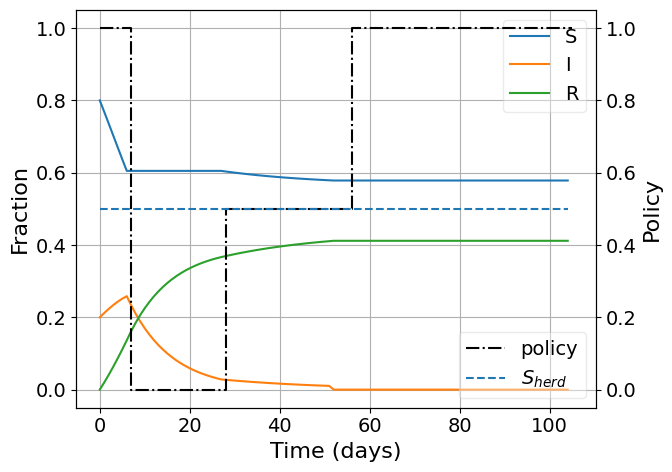

time: 547 ms (started: 2024-06-03 03:42:01 +00:00)


In [ ]:
for idx in range(len(S)):
  fig, ax= plt.subplots(figsize=(7, 5))
  print(R[idx][-1])
  plt.plot([s/county_pop[idx] for s in S[idx]],label='S')
  plt.plot([x/county_pop[idx] for x in I[idx]],label='I')
  plt.plot([r/county_pop[idx] for r in R[idx]],label='R')
  plt.xlabel('Time (days)')
  ax.set_ylim(-0.05,1.05)
  ax.grid()
  plt.legend(framealpha=0.4,loc='best')
  ax.set_ylabel('Fraction')
  ax2 = ax.twinx()
  ax2.set_ylim(-0.05,1.05)
  x = [delta_t*i for i in range(len(policy_all[0]))] + [T]
  y = list(policy_all[idx]) + [policy_all[idx,-1]]
  ax2.step(x,y,where='post', label= 'policy',linestyle='dashdot',color ='k')
  ax2.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  ax2.set_ylabel('Policy')
  plt.legend(ncol=1,loc='best',framealpha=0.4)
  # print(S[idx,-1] + I[idx,-1]+R[idx,-1])
  plt.tight_layout()
  new_path = os.path.join(PATH,'MultiCounty/multi_county'+str(idx)+'_kappa='+str(kappa_county[0])+'_eta='+str(eta_county[0])+'.pdf')
  # print(new_path)
  plt.savefig(new_path,figsize=(7,5))


In [ ]:
# # K = 0.01*np.ones((3,3))
# # np.fill_diagonal(K, 1)
# K = np.array([[1,0,0],
#               [0.2,1,0],
#               [0,0.2,1]])
# delta_t=10
# T=100
# beta= .2
# gamma = .1
# alpha_level = [0,.5,1]
# s0 = [.8,.9,.9]
# i0 = [.2,.1,.1]
# county_pop = [100]*3
# county_area = [1]*3
# # kappa_county = [1/10]*3
# # eta_county = [9/10]*3
# kappa_county = [1/2]*3
# eta_county = [1/2]*3
# S,I,R, policy_all = policy_game_county(beta, gamma, T, s0, i0,
#                                       delta_t=delta_t, county_pop=county_pop,
#                                       county_area = county_area,
#                                       kappa_county = kappa_county,
#                                       eta_county = eta_county,
#                                       K = K,
#                                       alpha_level=alpha_level,
#                                       two_sided=True)

In [ ]:
# fig, ax= plt.subplots(figsize=(7, 5))
# for idx in range(len(S)):
#   # plt.plot([s/county_pop[idx] for s in S[idx]],label='S')
#   plt.plot([x/county_pop[idx] for x in I[idx]],label='I')
#   # plt.plot([r/county_pop[idx] for r in R[idx]],label='R')
#   ax.set_ylim(0,0.3)

# print(I[:,28:45])

In [ ]:
# for idx in range(len(S)):
#   fig, ax= plt.subplots(figsize=(7, 5))
#   plt.plot([s/county_pop[idx] for s in S[idx]],label='S')
#   plt.plot([x/county_pop[idx] for x in I[idx]],label='I')
#   plt.plot([r/county_pop[idx] for r in R[idx]],label='R')
#   ax.set_ylim(-0.05,1.05)
#   plt.xlabel('Time (days)')
#   plt.legend(framealpha=0.4,loc='right')
#   ax.set_ylabel('compartment percentage')
#   ax2 = ax.twinx()
#   ax2.set_ylim(-0.05,1.05)
#   x = [delta_t*i for i in range(len(policy_all[0]))] + [T]
#   y = list(policy_all[idx]) + [policy_all[idx,-1]]
#   ax2.step(x,y,where='post', label= 'policy',linestyle='dashdot',color ='k')
#   ax2.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
#   ax2.set_ylabel('Policy')
#   plt.legend(ncol=1,loc='best')
#   print(S[idx,-1] + I[idx,-1]+R[idx,-1])

# plt.tight_layout()

## Optimal control

In [ ]:
def evaluate_cost_single(S0, I0, county_pop,
                         county_area,policy,delta_t,
                         T=60,beta =0.3 ,gamma=0.07,
                         kappa = 1/3, eta = 1/3,to_infinity=False):
  '''
  S0: an array of inital susceptible
  I0:
  N:
  policy: policy of the given county

  '''
  cost=0
  n_policy = T//delta_t

  R0 = county_pop - S0 - I0
  S = np.zeros(T)
  I = np.zeros(T)
  R = np.zeros(T)

  for t in range(T):
    policy_idx = int(t//delta_t)
    alpha = policy[policy_idx]
    # print(t,alpha)
    if t == 0:
      S[0] = S0
      I[0] = I0
      R[0] = R0
    else:
      S[t],I[t],R[t]  = update_SIR(S[t-1],I[t-1],R[t-1], alpha, county_pop, beta, gamma)

    if eta < 1:
      # cost += delta_t*(kappa*(1 - alpha) + (1 - kappa - eta)*(alpha - alpha_prev)**2)
      cost += kappa*(1 - alpha)

  if to_infinity and I[-1]/county_pop > 10e-5:
    S_end, I_end, R_end = update_SIR_infinity(S[-1],I[-1],county_pop, beta, gamma)
    S = np.array((list(S) + S_end))
    I = np.array((list(I) + I_end))
    R = np.array((list(R) + R_end))

  # print('calculated implementation cost:', cost)
  implementation_cost = cost/T
  impact_cost = eta*R[-1]/county_area/county_pop
  if eta == 1:
      # cost = eta*(S[-1] + I[-1] - gamma/beta*math.log(S[-1]))/county_pop
      # cost = eta*R[-1]/county_area
      cost = eta*R[-1]/county_area/county_pop
      implementation_cost = 0
  else:
    cost = cost/T
    cost += eta*R[-1]/county_area/county_pop
    # print('R[-1]:', R[-1])
    # print('R[-1]/county_area',R[-1]/county_area)
    # print('impact: ', eta*R[-1]/county_area)
    # print('non compliance:',delta_t*((1 - kappa - eta)*(alpha - alpha_prev)**2))
    # print('impact:',eta*np.sum(I[county_idx,i*delta_t:i*delta_t+t])/county_area[county_idx])
  # print('policy:', policy)
  # print('cost:', cost)
  return cost, S, I, R, implementation_cost, impact_cost

time: 2.4 ms (started: 2024-06-03 03:42:10 +00:00)


In [ ]:
def evaluate_cost_multi(S0, I0, county_pop,
                        county_area,policy0,policy1,delta_t, K,
                        T=60,beta =0.3 ,gamma=0.07,
                        kappa = 1/3, eta = 1/3):
  '''
  S0: an array of inital susceptible of all counties
  I0:a n array of inital infected of all counties
  county_pop: scalar
  county_area: scalar
  policy0: a policy of county 0 during time 0-T
  policy1: a policy of county 1 during time 0-T
  K: excitation matrix, np.array
  '''
  cost=0
  R0 = county_pop - S0 - I0
  S = np.zeros((T,2))
  I = np.zeros((T,2))
  R = np.zeros((T,2))
  n_policy = T//delta_t
  for t in range(T):
    policy_idx = int(t//delta_t)
    alpha0 = policy0[policy_idx]
    alpha1 = policy1[policy_idx]
    # print(t,alpha1)
    if t == 0:
      S[0] = S0
      I[0] = I0
      R[0] = R0
    else:
      S[t],I[t],R[t]  = update_network_SIR(S[t-1],I[t-1],R[t-1], [alpha0, alpha1], [county_pop,county_pop], K, beta, gamma)
      # print('S(t):',S[t])
      # print('I(t):',I[t])

    if eta < 1:
      # cost += delta_t*(kappa*(1 - alpha) + (1 - kappa - eta)*(alpha - alpha_prev)**2)
      cost += kappa*(1 - alpha)

  # print('calculated implementation cost:', cost)
  implementation_cost = cost/T
  impact_cost = eta*R[-1,1]/county_area/county_pop
  if eta == 1:
      # cost = eta*(S[-1] + I[-1] - gamma/beta*math.log(S[-1]))/county_pop
      # cost = eta*R[-1]/county_area
      cost = eta*R[-1,1]/county_area/county_pop
      implementation_cost = 0
  else:
    cost = cost/T
    cost += eta*R[-1,1]/county_area/county_pop
    # print('R[-1]:', R[-1])
    # print('R[-1]/county_area',R[-1]/county_area)
    # print('impact: ', eta*R[-1]/county_area)
    # print('non compliance:',delta_t*((1 - kappa - eta)*(alpha - alpha_prev)**2))
    # print('impact:',eta*np.sum(I[county_idx,i*delta_t:i*delta_t+t])/county_area[county_idx])
  # print('policy0 in evaluate_cost_multi:', policy0)
  # print('policy1 in evaluate_cost_multi:', policy1)
  # print('cost in evaluate_cost_multi:', cost)
  return cost, S, I, R, implementation_cost, impact_cost

time: 1.15 ms (started: 2024-06-03 03:42:11 +00:00)


In [ ]:
# S0 = np.array([80,90])
# I0 = np.array([20,10])
# K=np.array([[1,0],[0.1,1]])
# delta_t = 7
# T = 98
# policy0 =[1.0, 0.5, 0, 0, 0.5, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# policy1 =[1. ,0.5  , 0.,  0. , 0.,  0.,  0.5,  0.5,1. , 0.  ,1. , 1.  ,1.,  1. ]
# #[1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0]
# # policy1 = [1,1]
# # policy0= [1,1]
# county_pop = 100
# county_area = 1
# cost, S, I, R, implementation_cost, impact_cost = evaluate_cost_multi(S0, I0, county_pop,
#                                                                       county_area,policy0,policy1,delta_t, K,
#                                                                       T=T,beta =0.2 ,gamma=0.1,
#                                                                       kappa = 1/2, eta = 1/2)
# plt.plot(S)
# plt.plot(I)
# plt.plot(R)

time: 398 µs (started: 2024-06-03 03:42:11 +00:00)


In [ ]:
def dfs_mod_multi(T,n, policy0, policy,end_grid,
                  county_pop, county_area,
                  S0,I0,S1,I1,
                  county_idx=0, intensity_max = 0,
                  kappa=1/2,eta=1/2,verbose=True,
                  K=np.array([[1,0],[0.1,1]]),
                  beta =0.2, gamma=0.1,
                  reach_hi=True, to_infinity=False,
                   herd_dist = 3e-2):
  # policy initialized to be an array of ones, ends in ones
  # S0: the inital Susceptible for the 1st county
  # S1: the initial Susceptible for the 2nd county

  S_herd = county_pop*gamma/beta
  cost_min = 99999
  implementation_cost = 0
  impact_cost = 0
  count=0
  optimal_policy = np.ones_like(policy,dtype=float)
  S = np.zeros(T)
  I = np.zeros(T)
  R = np.zeros(T)

  if n <= end_grid-1:
    for val in [intensity_max,(1+intensity_max)/2,1]:
      print('val:',val)
      policy[n] = val
      print('n before dfs:',n)
      policy_temp, cost_temp, S_temp, I_temp, R_temp, implementation_cost_temp, impact_cost_temp,count_temp = dfs_mod_multi(T,n+1,policy0,
                                                                                                                            policy, end_grid,
                                                                                                                            county_pop, county_area,
                                                                                                                            S0,I0,S1, I1,
                                                                                                                            county_idx=0,
                                                                                                                            intensity_max = intensity_max,K=K,
                                                                                                                            kappa=kappa,eta=eta,
                                                                                                                            verbose=verbose,
                                                                                                                            beta=beta, gamma=gamma,
                                                                                                                            reach_hi=reach_hi,to_infinity=to_infinity
                                                                                                                            )

      print('policy_temp:',policy_temp)
      # print('cost_temp:',cost_temp)
      print('n:',n)
      print('\n')
      if cost_temp <= cost_min:
        # print('distance to herd immunity',(S_temp[-1] - S_herd)/county_pop)
        # print('realative increment:',abs(S_temp[-1] - S_temp[-2])/county_pop)
        if (reach_hi and (S_temp[-1] - S_herd)/county_pop <= herd_dist and abs(S_temp[-1] - S_temp[-2])/county_pop <10e-4) or not reach_hi:
          print('Update cost_min')
          #and abs(S_temp[-1] - S_temp[-2])/county_pop <10e-4
          optimal_policy = list(copy.deepcopy(policy_temp))
          count = count_temp + 1
          cost_min = cost_temp
          I = I_temp
          S = S_temp
          R = R_temp
          implementation_cost = implementation_cost_temp
          impact_cost = impact_cost_temp
          if verbose:
            print('count:',count)
            print('Current optimal_policy:',optimal_policy)
            print('current cost_min:',cost_min)

  elif n == end_grid:
    # print('policy1:',policy)
    # print('policy0:',policy0)
    cost_min,S_all,I_all,R_all,implementation_cost, impact_cost = evaluate_cost_multi(np.array([S0,S1]), np.array([I0,I1]), county_pop, county_area,
                                                                                      policy0, policy, delta_t,T=T,K=K,
                                                                                      beta=beta, gamma=gamma,
                                                                                      kappa = kappa, eta = eta)
    optimal_policy = policy
    S = S_all[:,1]
    I = I_all[:,1]
    R = R_all[:,1]


    if verbose:
      print('n:',n)
      print('Current policy at a leaf:',policy)
      print('current cost at a leaf:',cost_min)

  return optimal_policy,cost_min, S,I,R, implementation_cost, impact_cost, count

time: 1.74 ms (started: 2024-06-03 03:42:12 +00:00)


In [ ]:
def dfs_mod_single(T,n, policy, end_grid,
                  county_pop, county_area,
                  S0,I0,county_idx=0, intensity_max = 0,
                  kappa=1/2,eta=1/2,verbose=True,
                  beta =0.3, gamma=0.07,
                  reach_hi=True, to_infinity=False,
                   herd_dist = 3e-2):
  # policy initialized to be an array of ones, ends in ones

  cost_min = 99999
  implementation_cost = 0
  impact_cost = 0
  optimal_policy = np.ones_like(policy,dtype=float)
  S = np.zeros(T)
  I = np.zeros(T)
  R = np.zeros(T)
  S_herd = county_pop*gamma/beta
  count = 0

  if n <= end_grid-1:
    for val in [intensity_max,(1+intensity_max)/2,1]:
      policy[n] = val
      policy_temp, cost_temp, S_temp, I_temp, R_temp, implementation_cost_temp, impact_cost_temp,count_temp = dfs_mod_single(T,n+1,policy, end_grid,
                                                                                                                  county_pop, county_area,
                                                                                                                  S0,I0,county_idx=0,
                                                                                                                  intensity_max = intensity_max,
                                                                                                                  kappa=kappa,eta=eta,
                                                                                                                  verbose=verbose,
                                                                                                                  beta=beta, gamma=gamma,
                                                                                                                  reach_hi=reach_hi,to_infinity=to_infinity
                                                                                                                  )

      # if cost_temp <= cost_min:
      #   optimal_policy = list(policy_temp)
      #   cost_min = cost_temp
      #   I = I_temp
      #   S = S_temp
      #   R = R_temp
      if cost_temp <= cost_min:
        if (reach_hi and (S_temp[-1] - S_herd)/county_pop <= herd_dist and abs(S_temp[-1] - S_temp[-2])/county_pop <10e-4) or not reach_hi:
          #and abs(S_temp[-1] - S_temp[-2])/county_pop <10e-4
          optimal_policy = list(policy_temp)
          count += count_temp + 1
          cost_min = cost_temp
          I = I_temp
          S = S_temp
          R = R_temp
          implementation_cost = implementation_cost_temp
          impact_cost = impact_cost_temp
          if verbose:
            print('count:',count)
            print('Current policy:',optimal_policy)
            print('current cost:',cost_min)

  elif n == end_grid:
    cost_min,S,I,R,implementation_cost, impact_cost = evaluate_cost_single(S0, I0, county_pop, county_area,
                                                                            policy, delta_t,T=T,
                                                                            beta=beta, gamma=gamma,
                                                                            kappa = kappa, eta = eta)
    optimal_policy = policy

    if verbose:
      print('Current policy:',policy)
      print('current cost:',cost_min)

  return optimal_policy,cost_min, S,I,R, implementation_cost, impact_cost, count

time: 3.37 ms (started: 2024-06-03 03:42:14 +00:00)


In [ ]:
def single_county_search(T=100, delta_t=20,
                         S0 =90, I0 = 10,
                         county_pop = 100,
                         county_area = 10,
                         kappa=1/2,eta=1/2,
                         end_ratio=0.5,
                         start_ratio=0.25,
                         beta =0.3 ,gamma=0.07,
                         intensity_max = 0,
                         modification=True,verbose=True,
                         reach_hi=True,to_infinity=False,
                         herd_dist=3e-3):

  if T % delta_t:
    print('WARNING: Total time T does not divided by delta_t!!')


  n_policy= T//delta_t
  policy = np.ones(n_policy)
  end_grid= round(n_policy*end_ratio)
  start_grid = round(n_policy*start_ratio)
  print('start_grid:', start_grid)
  print('start date:',start_ratio*T)

  print('end_grid:',end_grid)
  print('end date:',end_ratio*T)
  n = start_grid
  # optimal_policy,cost_min, S, I, R = dfs_mod(T,n, policy,
  #                                            policy_prev,policy_all,
  #                                            end_grid,
  #                                            county_pop, county_area,
  #                                            S0,I0,county_idx=0,beta=beta, gamma=gamma,
  #                                            kappa=kappa,eta=eta,intensity_max = intensity_max,
  #                                            verbose=verbose,
  #                                            reach_hi=True)

  optimal_policy,cost_min, S, I, R ,implementation_cost, impact_cost,count = dfs_mod_single(T,n, policy,end_grid,
                                                                                    county_pop, county_area,S0,I0,
                                                                                    county_idx=0,beta=beta, gamma=gamma,
                                                                                    kappa=kappa,eta=eta, intensity_max = intensity_max,
                                                                                    verbose=verbose,
                                                                                    reach_hi=reach_hi,
                                                                                    to_infinity=to_infinity,
                                                                                    herd_dist = herd_dist
                                                                                  )
  print('Optimal policy:', optimal_policy)
  print('Min cost:',cost_min)
  print('implementation cost:', implementation_cost)
  print('impact cost:', impact_cost)
  return optimal_policy,cost_min, S,I,R ,implementation_cost, impact_cost, count

time: 1.04 ms (started: 2024-06-03 03:42:14 +00:00)


In [ ]:
def single_county_search_dependent(policy0,T=100, delta_t=20,
                                  S0 =90, I0 = 10,S1=90,I1=10,
                                  county_pop = 100,
                                  county_area = 10,
                                  kappa=1/2,eta=1/2,
                                  end_ratio=0.5,
                                  start_ratio=0.25,
                                  beta =0.3 ,gamma=0.07,
                                  intensity_max = 0, K = np.array([[1,0],[0.1,1]]),
                                  verbose=True,
                                  reach_hi=True,to_infinity=False,
                                  herd_dist=3e-3):

  if T % delta_t:
    print('WARNING: Total time T does not divided by delta_t!!')


  n_policy= T//delta_t
  policy = np.ones(n_policy)
  end_grid= round(n_policy*end_ratio)
  start_grid = round(n_policy*start_ratio)
  print('start_grid:', start_grid)
  print('start date:',start_ratio*T)

  print('end_grid:',end_grid)
  print('end date:',end_ratio*T)
  print('\n')
  n = start_grid


  optimal_policy,cost_min, S, I, R ,implementation_cost, impact_cost,count = dfs_mod_multi(T,n, policy0,policy, end_grid,
                                                                                           county_pop, county_area,
                                                                                           S0,I0,S1,I1,
                                                                                            county_idx=0,beta=beta, gamma=gamma,
                                                                                            kappa=kappa,eta=eta, intensity_max = intensity_max,
                                                                                            verbose=verbose, K=K,
                                                                                            reach_hi=reach_hi,
                                                                                            to_infinity=to_infinity,
                                                                                            herd_dist = herd_dist
                                                                                            )
  print('Optimal policy:', optimal_policy)
  print('Min cost:',cost_min)
  print('implementation cost:', implementation_cost)
  print('impact cost:', impact_cost)
  return optimal_policy,cost_min, S,I,R ,implementation_cost, impact_cost, count

time: 3.36 ms (started: 2024-06-03 03:42:15 +00:00)


# Simulations

## Single region algorithm for dependent counties

In [ ]:
# waves but use optimal control for single region
K= np.array([[1,0,0],
             [0.1,1,0],
             [0,0.1,1]])
alpha = 0.5
delta_t=7
T=98
beta= .2
gamma = .1
alpha_level = [0,.5,1]
county_idx = 0
s0 = [.8,.9,.9]
i0 = [.2,.1,.1]
county_pop = [100]*3
county_area = [1]*3
policy_all = [1,1,1]
kappa_county = [1/2]*3
eta_county = [1/2]*3
S = np.zeros((3,T))
I = np.zeros((3,T))
R = np.zeros((3,T))
# first county
optimal_policy,cost_min, S[0],I[0],R[0] ,implementation_cost, impact_cost, count = single_county_search(T=98, delta_t=delta_t,
                                                                                                        S0 =80, I0 = 20,
                                                                                                        county_pop = 100,
                                                                                                        county_area = 1,
                                                                                                        kappa=1/2,eta=1/2,
                                                                                                        end_ratio=10/14,
                                                                                                        start_ratio=1/14,
                                                                                                        beta =beta,gamma=gamma,
                                                                                                        intensity_max = 0,
                                                                                                        verbose=True,
                                                                                                        reach_hi=True,to_infinity=False,
                                                                                                        herd_dist=3e-3)

Streaming output truncated to the last 5000 lines.
Current policy: [1.  0.  0.  0.  1.  0.  0.  0.5 0.5 1.  1.  1.  1.  1. ]
current cost: 0.4198405718363388
count: 2
Current policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
current cost: 99999
Current policy: [1.  0.  0.  0.  1.  0.  0.  0.5 1.  0.  1.  1.  1.  1. ]
current cost: 0.43769771469348173
Current policy: [1.  0.  0.  0.  1.  0.  0.  0.5 1.  0.5 1.  1.  1.  1. ]
current cost: 0.4198405718363388
Current policy: [1.  0.  0.  0.  1.  0.  0.  0.5 1.  1.  1.  1.  1.  1. ]
current cost: 0.401983428979196
count: 3
Current policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
current cost: 99999
count: 8
Current policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
current cost: 99999
Current policy: [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.]
current cost: 0.4555548575506245
Current policy: [1.  0.  0.  0.  1.  0.  0.  1.  0.  0.5 1.  1.  1.  1. ]
curren

KeyboardInterrupt: ignored

time: 7.38 s (started: 2023-01-16 19:53:11 +00:00)


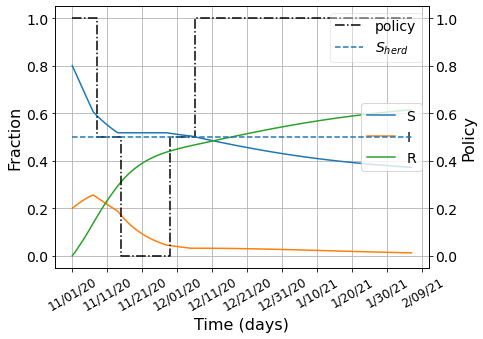

time: 1.37 s (started: 2023-01-12 07:03:47 +00:00)


In [ ]:
start = datetime.datetime.strptime("11/1/20", "%m/%d/%y")
y = []
for i in range(len(optimal_policy)):
  y += [optimal_policy[i]]*delta_t
fig,ax= plt.subplots(figsize=(7, 5))
xx= [start + datetime.timedelta(days=x) for x in range(T)]
ax.plot(xx,S[0]/county_pop[0],label='S')
ax.plot(xx,I[0]/county_pop[0],label='I')
ax.plot(xx,R[0]/county_pop[0],label='R')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
# ax.set_ylim((0,0.008))
ax.grid()
ax.set_ylabel('Fraction')
ax.legend(loc='center right')
ax.set_ylim(-0.05,1.05)
plt.xticks(rotation = 30,fontsize=12)
plt.xlabel('Time (days)')

ax2 = ax.twinx()
ax2.set_ylabel('Policy')
ax2.set_ylim(-0.05,1.05)
ax2.step(xx,y,label= 'policy',linestyle='dashdot',where = 'post',color ='k')
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

# plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
plt.plot(xx,[gamma/beta]*len(xx),'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper right',framealpha=0.4)

plt.tight_layout()

new_path = os.path.join(PATH,'SingleCounty/la_R0='+str(R0)+'_r0='+str(r0)+'_delta_t='+str(delta_t)+'.pdf')
# print(new_path)
plt.savefig(new_path,figsize=(7,5))
plt.show()

In [ ]:
policy0 = [1.0, 0.5, 0, 0, 0.5, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
beta= .2
gamma = .1
T=98
optimal_policy1,cost_min1, S_de1,I_de1,R_de1 ,implementation_cost1, impact_cost1, count1 = single_county_search_dependent(policy0,T=T, delta_t=7,
                                                                                                                          S0 =80, I0 = 20, S1=90,I1=10,
                                                                                                                          county_pop = 100,
                                                                                                                          county_area = 1,
                                                                                                                          kappa=1/2,eta=1/2,
                                                                                                                          end_ratio=7/14,
                                                                                                                          start_ratio=1/14,
                                                                                                                          beta =beta,gamma=gamma,
                                                                                                                          intensity_max = 0, K = np.array([[1,0],[0.1,1]]),
                                                                                                                          verbose=True,
                                                                                                                          reach_hi=True,to_infinity=False,
                                                                                                                          herd_dist=3e-3)
print('Optimal:',optimal_policy1)

Streaming output truncated to the last 5000 lines.

policy_temp: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
n: 5


Update cost_min
count: 1
Current optimal_policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
current cost_min: 99999
val: 0.5
n before dfs: 5
val: 0
n before dfs: 6
n: 7
Current policy at a leaf: [1.  0.5 0.5 0.5 1.  0.5 0.  1.  1.  1.  1.  1.  1.  1. ]
current cost at a leaf: 0.571104044959716
policy_temp: [1.  0.5 0.5 0.5 1.  0.5 0.  1.  1.  1.  1.  1.  1.  1. ]
n: 6


val: 0.5
n before dfs: 6
n: 7
Current policy at a leaf: [1.  0.5 0.5 0.5 1.  0.5 0.5 1.  1.  1.  1.  1.  1.  1. ]
current cost at a leaf: 0.5865520087414003
policy_temp: [1.  0.5 0.5 0.5 1.  0.5 0.5 1.  1.  1.  1.  1.  1.  1. ]
n: 6


Update cost_min
count: 1
Current optimal_policy: [1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
current cost_min: 0.5865520087414003
val: 1
n before dfs: 6
n: 7
Current policy at a leaf: [1.  0.5 0.5 0.5 1.  0.5 1.  1.  1.  

In [ ]:
print(len(xx))
print(S_de1.shape)
T=98
county_pop=100

105
(98,)
time: 13.3 ms (started: 2023-01-18 19:09:00 +00:00)


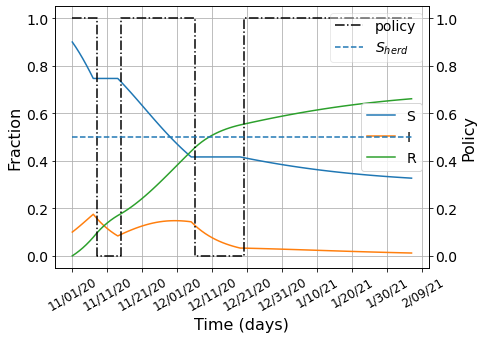

time: 1.11 s (started: 2023-01-18 19:09:01 +00:00)


In [ ]:
start = datetime.datetime.strptime("11/1/20", "%m/%d/%y")
y = []
for i in range(len(optimal_policy1)):
  y += [optimal_policy1[i]]*delta_t
fig,ax= plt.subplots(figsize=(7, 5))
xx= [start + datetime.timedelta(days=x) for x in range(T)]
ax.plot(xx,S_de1/county_pop,label='S')
ax.plot(xx,I_de1/county_pop,label='I')
ax.plot(xx,R_de1/county_pop,label='R')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
# ax.set_ylim((0,0.008))
ax.grid()
ax.set_ylabel('Fraction')
ax.legend(loc='center right')
ax.set_ylim(-0.05,1.05)
plt.xticks(rotation = 30,fontsize=12)
plt.xlabel('Time (days)')

ax2 = ax.twinx()
ax2.set_ylabel('Policy')
ax2.set_ylim(-0.05,1.05)
ax2.step(xx,y,label= 'policy',linestyle='dashdot',where = 'post',color ='k')
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

# plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
plt.plot(xx,[gamma/beta]*len(xx),'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper right',framealpha=0.4)

plt.tight_layout()

# new_path = os.path.join(PATH,'DepCounty/R0='+str(R0)+'_r0='+str(r0)+'_delta_t='+str(delta_t)+'.pdf')
# # print(new_path)
# plt.savefig(new_path,figsize=(7,5))
# plt.show()

In [ ]:
# County 3
beta= .2
gamma = .1
T=98
optimal_policy2,cost_min2, S_de2,I_de2,R_de2 ,implementation_cost2, impact_cost2, count2 = single_county_search_dependent(optimal_policy1,T=T, delta_t=7,
                                                                                                                          S0 =90, I0 = 10, S1=90,I1=10,
                                                                                                                          county_pop = 100,
                                                                                                                          county_area = 1,
                                                                                                                          kappa=1/2,eta=1/2,
                                                                                                                          end_ratio=7/14,
                                                                                                                          start_ratio=1/14,
                                                                                                                          beta =beta,gamma=gamma,
                                                                                                                          intensity_max = 0, K = np.array([[1,0],[0.1,1]]),
                                                                                                                          verbose=True,
                                                                                                                          reach_hi=True,to_infinity=False,
                                                                                                                          herd_dist=3e-3)

Streaming output truncated to the last 5000 lines.
count: 1
Current optimal_policy: [1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
current cost_min: 0.6069995771589024
policy_temp: [1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
n: 5


Update cost_min
count: 2
Current optimal_policy: [1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
current cost_min: 0.6069995771589024
val: 1
n before dfs: 5
val: 0
n before dfs: 6
n: 7
Current policy at a leaf: [1.  0.5 0.5 0.5 1.  1.  0.  1.  1.  1.  1.  1.  1.  1. ]
current cost at a leaf: 0.5929031594374086
policy_temp: [1.  0.5 0.5 0.5 1.  1.  0.  1.  1.  1.  1.  1.  1.  1. ]
n: 6


Update cost_min
count: 1
Current optimal_policy: [1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
current cost_min: 0.5929031594374086
val: 0.5
n before dfs: 6
n: 7
Current policy at a leaf: [1.  0.5 0.5 0.5 1.  1.  0.5 1.  1.  1.  1.  1.  1.  1. ]
current cost at a leaf: 0.6105403

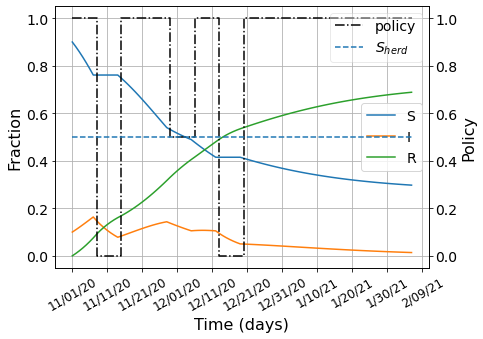

time: 1.01 s (started: 2023-01-18 19:18:07 +00:00)


In [ ]:
start = datetime.datetime.strptime("11/1/20", "%m/%d/%y")
y = []
for i in range(len(optimal_policy2)):
  y += [optimal_policy2[i]]*delta_t
fig,ax= plt.subplots(figsize=(7, 5))
xx= [start + datetime.timedelta(days=x) for x in range(T)]
ax.plot(xx,S_de2/county_pop,label='S')
ax.plot(xx,I_de2/county_pop,label='I')
ax.plot(xx,R_de2/county_pop,label='R')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
# ax.set_ylim((0,0.008))
ax.grid()
ax.set_ylabel('Fraction')
ax.legend(loc='center right')
ax.set_ylim(-0.05,1.05)
plt.xticks(rotation = 30,fontsize=12)
plt.xlabel('Time (days)')

ax2 = ax.twinx()
ax2.set_ylabel('Policy')
ax2.set_ylim(-0.05,1.05)
ax2.step(xx,y,label= 'policy',linestyle='dashdot',where = 'post',color ='k')
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

# plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
plt.plot(xx,[gamma/beta]*len(xx),'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper right',framealpha=0.4)

plt.tight_layout()

## alpha vs cost

/content/drive/MyDrive/Research/PolicySIR/figure/SingleCounty/cost_vs_alpha.eps


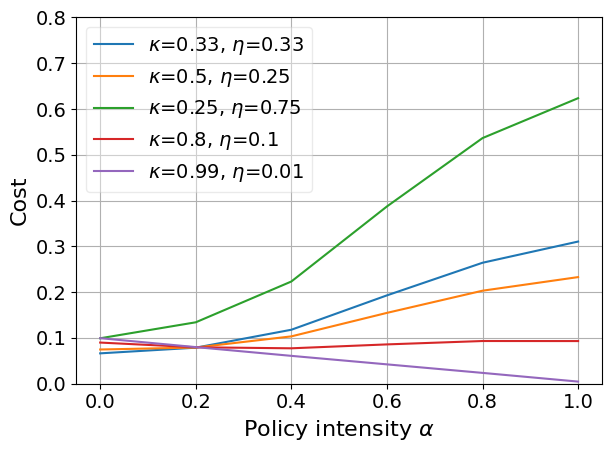

time: 1.01 s (started: 2024-06-03 04:20:31 +00:00)


In [ ]:
# K = np.array([[1,0.1],
#               [0.1,1]]
#              )
K = np.array([[1,0],
              [0,1]]
             )
delta_t=10
T=100
beta= .2
gamma = .1
alpha_level = [0,.5,1]
s0 = np.array([.9,.9])
i0 = np.array([.1,.1])
r0 = np.array([.0,.0])
# kappa_county = [1/10]*3
# eta_county = [9/10]*3
kappa = 1/3
eta = 1/3
alpha_level = [0,0.2,0.4,0.6,0.8,1]
cost_all = []
N=[1000]*2
A=[1]*2
policy_all = [1,1]
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

kappa = 1/2
eta = 1/4
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

kappa = 1/4
eta = 3/4
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

kappa = 4/5
eta = 1/10
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

kappa = 99/100
eta = 1/200
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+', $\eta$='+str(round(eta,2)))

plt.ylim(0,0.8)
plt.legend(framealpha=0.4)
plt.xlabel(r'Policy intensity $\alpha$')
plt.ylabel('Cost')
# plt.title('cost vs alpha')
plt.tight_layout()
plt.grid()
new_path = os.path.join(PATH,"SingleCounty/cost_vs_alpha.eps")
print(new_path)
plt.savefig(new_path)
# ax.set_ylim((0,0.008))

plt.show()

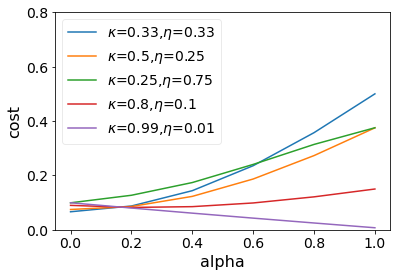

time: 1.42 s (started: 2022-07-28 20:48:39 +00:00)


In [ ]:
K = np.array([[1,0.1],
              [0.1,1]]
             )
delta_t=10
T=100
beta= .2
gamma = .1
alpha_level = [0,.5,1]
s0 = np.array([.6,.6])
i0 = np.array([.1,.1])
r0 = np.array([.0,.0])
# kappa_county = [1/10]*3
# eta_county = [9/10]*3
kappa = 1/3
eta = 1/3
alpha_level = [0,0.2,0.4,0.6,0.8,1]
cost_all = []
N=[1000]*2
A=[1]*2
policy_all = [1,1]
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))
plt.xlabel('alpha')
plt.ylabel('cost')

kappa = 1/2
eta = 1/4
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))

kappa = 1/4
eta = 3/4
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))

kappa = 4/5
eta = 1/10
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))

kappa = 99/100
eta = 1/200
cost_all = []
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all,label = r'$\kappa$='+str(round(kappa,2))+',$\eta$='+str(round(eta,2)))

plt.ylim(0,0.8)
plt.legend(framealpha=0.4)


Text(0, 0.5, 'cost')

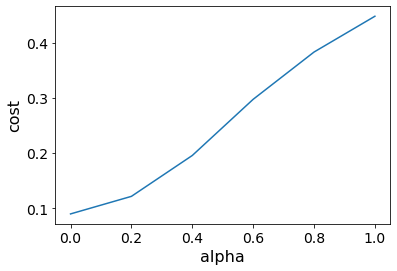

time: 599 ms (started: 2022-07-28 20:20:22 +00:00)


In [ ]:
K = np.array([[1,0.1],
              [0.1,1]]
             )
delta_t=10
T=100
beta= .2
gamma = .1
alpha_level = [0,.5,1]
s0 = np.array([.9,.9])
i0 = np.array([.1,.1])
r0 = np.array([.0,.0])
# kappa_county = [1/10]*3
# eta_county = [9/10]*3
kappa = 1/2
eta_county = 1/4
alpha_level = [0,0.2,0.4,0.6,0.8,1]
cost_all = []
N=[1000]*2
A=[1]*2
policy_all = [1,1]
for alpha in alpha_level:
  cost_all.append(cost_network(alpha, county_idx,
                               policy_all, s0*N, i0*N, r0*N,
                               N, A, K, T,
                               delta_t,beta,
                               gamma,alpha_prev=0,
                               kappa = kappa,eta=eta,
                               two_sided=True))
plt.plot(alpha_level,cost_all)
plt.xlabel('alpha')
plt.ylabel('cost')

## Optimal control simulation

time grid = 15
start_grid: 5
start date: 75.0
end_grid: 10
end date: 150.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 55012.11998353264


<Figure size 432x288 with 0 Axes>

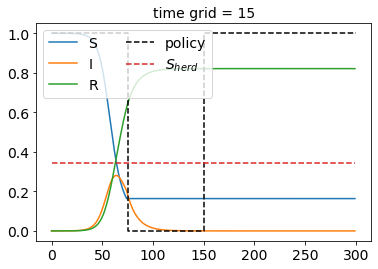

Final size: 0.16352969520061783
time grid = 20
start_grid: 4
start date: 75.0
end_grid: 8
end date: 150.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 57483.35949412972


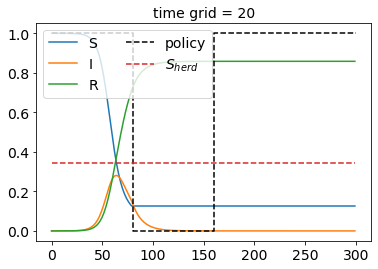

Final size: 0.12598756710681744
time grid = 30
start_grid: 2
start date: 75.0
end_grid: 5
end date: 150.0
Optimal policy: [1.0, 1.0, 0.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 42765.57258918972


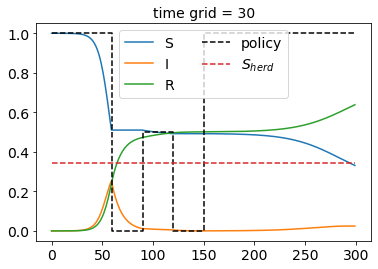

Final size: 0.33122125523842105
time grid = 50
start_grid: 2
start date: 75.0
end_grid: 3
end date: 150.0
Optimal policy: [1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
Min cost: 60658.09934348256


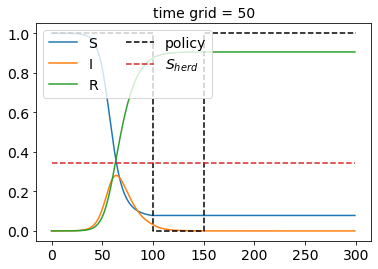

Final size: 0.07813879906475996
time: 3.43 s (started: 2022-06-09 15:14:59 +00:00)


In [ ]:
T = 200
plt.figure()
# for i,delta_t in enumerate([7,14,21,28]):
I_all = []
optimal_policy_all = []
kappa = 0
eta = 1
beta =0.29
gamma=0.1
end_ratio=0.5
county_pop = 67000
for i,delta_t in enumerate([15,20,30,50]):
  print('time grid = '+str(delta_t))
  optimal_policy,cost_min, S,I,R,_,_ = single_county_search(T=T,
                                                        delta_t=delta_t,
                                                        S0 = 67000 - 1,
                                                        I0 = 1,
                                                        end_ratio = end_ratio,
                                                        county_pop = county_pop,
                                                        county_area = 1,
                                                        kappa=kappa,eta=eta,
                                                        beta =beta,
                                                        gamma=gamma,
                                                        reach_hi=True,
                                                        modification=True,
                                                        verbose=False)

  T_end = len(S)
  x = [delta_t*i for i in range(len(optimal_policy))] + [T_end]
  y = list(optimal_policy) + [optimal_policy[-1]]
  I_all.append(I)
  optimal_policy_all.append(optimal_policy)
  plt.figure()
  plt.plot(S/county_pop,label='S')
  plt.plot(I/county_pop,label='I')
  plt.plot(R/county_pop,label='R')
  plt.step(x,y,label= 'policy',linestyle='--',where='post',color ='k')
  T_end = len(S)
  plt.plot([gamma/beta]*T_end,'--',label=r'$S_{herd}$')
  plt.legend(ncol=2,loc='best')
  plt.title('time grid = '+str(delta_t))
  plt.show()
  print('Final size:',S[-1]/county_pop)

## Bliman

start_grid: 7
start date: 49.0
end_grid: 14
end date: 98.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.6967959299680522
implementation cost: 0
impact cost: 0.6967959299680522
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


<Figure size 432x288 with 0 Axes>

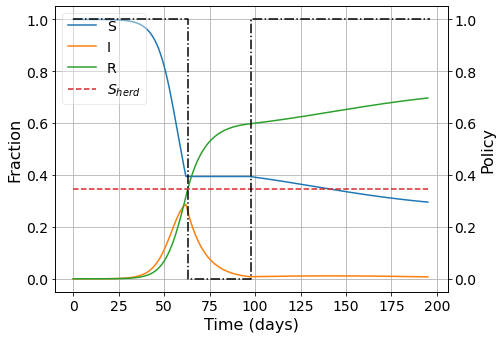

Final size: 0.29559703094666834
time: 7.69 s (started: 2022-09-02 04:20:11 +00:00)


In [ ]:
#bliman single search
T = 196 #200
beta =0.29
gamma=0.1
plt.figure()
county_pop=6.7e4
# I0 = 1.49e-3
# for i,delta_t in enumerate([7,14,21,28]):
I_all = []
optimal_policy_all = []
delta_t =7
# kappa=1/50,eta=49/50
kappa = 0
eta = 1
start_ratio = delta_t*7/T

for end_ratio in [0.5]:
  optimal_policy,cost_min, S,I,R,_,_,_ = single_county_search(T=T,
                                                        delta_t=delta_t,
                                                        S0 = county_pop - 1,
                                                        I0 = 1,
                                                        start_ratio = start_ratio,
                                                        end_ratio = end_ratio,
                                                        county_pop = county_pop,
                                                        county_area = 1,
                                                        kappa=kappa,eta=eta,
                                                        beta =beta,gamma=gamma,
                                                        reach_hi=True, modification=True,
                                                        verbose=False,to_infinity=False)

  x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  y = list(optimal_policy) + [optimal_policy[-1]]
  print(optimal_policy)
  I_all.append(I)
  optimal_policy_all.append(optimal_policy)
  fig,ax = plt.subplots(figsize=(7, 5))
  ax.plot(S/67000,label='S')
  ax.plot(I/67000,label='I')
  ax.plot(R/67000,label='R')
  ax.set_ylim(-0.05,1.05)

  ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='upper left',framealpha=0.4)
  plt.xlabel('Time (days)')
  plt.grid()
  ax.set_ylabel('Fraction')

  ax2 = ax.twinx()
  ax2.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  ax2.set_ylim(-0.05,1.05)
  plt.tight_layout()
  ax2.set_ylabel('Policy')
  # plt.title('End ratio = '+str(end_ratio))
  new_path = os.path.join(PATH,'SingleCounty/optimal_policy_delta_t='+str(delta_t)+'.pdf')
  # print(new_path)
  plt.savefig(new_path,figsize=(7,5))
  plt.show()

  print('Final size:',S[-1]/67000)


start_grid: 1
start date: 28.0
end_grid: 4
end date: 98.0
Optimal policy: [1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0]
Min cost: 0.67557814441742
implementation cost: 0
impact cost: 0.67557814441742
[1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0]


<Figure size 640x480 with 0 Axes>

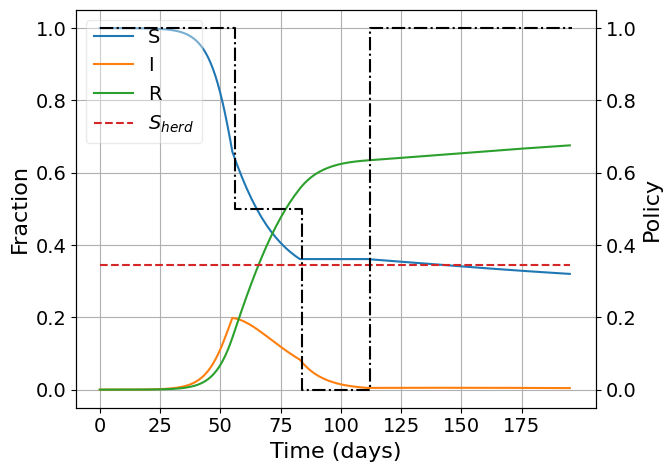

Final size: 0.32015554003276026
time: 1.34 s (started: 2024-06-03 04:13:19 +00:00)


In [ ]:
#bliman single search
import matplotlib.ticker as ticker
T = 196 #200
beta =0.29
gamma=0.1
plt.figure()
county_pop=6.7e4
# I0 = 1.49e-3
# for i,delta_t in enumerate([7,14,21,28]):
I_all = []
optimal_policy_all = []
delta_t =28
# kappa=1/50,eta=49/50
kappa = 0
eta = 1
start_ratio = delta_t/T

for end_ratio in [0.5]:
  optimal_policy,cost_min, S,I,R,_,_,_ = single_county_search(T=T,
                                                        delta_t=delta_t,
                                                        S0 = county_pop - 1,
                                                        I0 = 1,
                                                        start_ratio = start_ratio,
                                                        end_ratio = end_ratio,
                                                        county_pop = county_pop,
                                                        county_area = 1,
                                                        kappa=kappa,eta=eta,
                                                        beta =beta,gamma=gamma,
                                                        reach_hi=True, modification=True,
                                                        verbose=False,to_infinity=False)

  x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  y = list(optimal_policy) + [optimal_policy[-1]]
  print(optimal_policy)
  I_all.append(I)
  optimal_policy_all.append(optimal_policy)
  fig,ax = plt.subplots(figsize=(7, 5))


  ax.plot(S/67000,label='S')
  ax.plot(I/67000,label='I')
  ax.plot(R/67000,label='R')
  ax.set_ylim(-0.05,1.05)

  ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='upper left',framealpha=0.4)
  ax.set_xticks(np.arange(0, 200, 25))
  plt.xlabel('Time (days)')
  plt.grid()
  ax.set_ylabel('Fraction')
  # ax.xaxis.set_minor_locator(ticker.FixedLocator([0,25,50,75,100,125,150,175,200]))
  # ax.xaxis.set_minor_locator(ticker.MaxNLocator(8))

  ax2 = ax.twinx()
  ax2.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  ax2.set_ylim(-0.05,1.05)
  plt.tight_layout()
  ax2.set_ylabel('Policy')
  plt.tight_layout()

  # plt.title('End ratio = '+str(end_ratio))
  new_path = os.path.join(PATH,'SingleCounty/optimal_policy_delta_t='+str(delta_t)+'.pdf')
  # print(new_path)
  plt.savefig(new_path)
  plt.show()

  print('Final size:',S[-1]/67000)


In [ ]:
  `  x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  y = list(optimal_policy) + [optimal_policy[-1]]
  print(optimal_policy)
  I_all.append(I)
  optimal_policy_all.append(optimal_policy)
  plt.figure()
  plt.plot(S/67000,label='S')
  plt.plot(I/67000,label='I')
  plt.plot(R/67000,label='R')
  plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='best',framealpha=0.4)
  plt.xlabel('Time (days)')
  plt.tight_layout()
  # plt.title('End ratio = '+str(end_ratio))
  # new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=5.pdf")
  # print(new_path)
  # plt.savefig(new_path,figsize=(7,5))
  # plt.show()

In [ ]:
print('Final size:',S[-1]/67000)

Final size: 0.17413958350267603


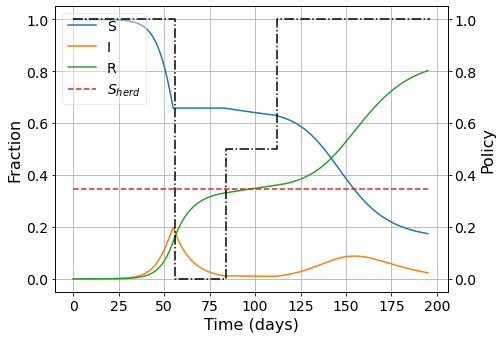

time: 1.02 s (started: 2022-09-02 04:28:08 +00:00)


In [ ]:
# start policy compelete lockdown at day 60
S0 = 67000 - 1
I0 = 1
county_pop = 67000
county_area = 1
beta=0.29
gamma=0.1
T= 196
# delta_t = 20
# policy = [1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0]
# policy = [1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
# delta_t = 10
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           0.0, 0.0, 0.0, 0.0,
#           1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0]
# delta_t = 5
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
#           1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0,
#           1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0]
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
#           1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
delta_t =28
# policy = [1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0]
policy = [1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0]
cost_min,S,I,R,_,_ = evaluate_cost_single(S0, I0, county_pop, county_area,
                                      policy,delta_t,T=T,
                                      beta =beta,gamma=gamma,
                                      kappa = 0, eta = 1)
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(S/67000,label='S')
ax.plot(I/67000,label='I')
ax.plot(R/67000,label='R')
x = [delta_t*i for i in range(len(policy))] + [T]
ax.set_ylim(-0.05,1.05)

ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper left',framealpha=0.4)
plt.xlabel('Time (days)')
plt.grid()
ax.set_ylabel('Fraction')

ax2 = ax.twinx()
ax2.step(x,policy+[policy[-1]],label= 'policy',linestyle='dashdot',where='post',color ='k')
ax2.set_ylim(-0.05,1.05)
plt.tight_layout()
ax2.set_ylabel('Policy')
# plt.title('End ratio = '+str(end_ratio))
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=20.pdf")
new_path = os.path.join(PATH,'SingleCounty/flipped_policy_delta_t='+str(delta_t)+'.pdf')
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=5.pdf")
# print(new_path)
plt.savefig(new_path,figsize=(7,5))
print('Final size:',S[-1]/67000)

In [ ]:
policy[12]

0.5

time: 27.5 ms (started: 2022-06-08 16:27:40 +00:00)


/content/drive/MyDrive/Research/PolicySIR/figure/SingleCounty/flipped_policy_delta_t=21.pdf


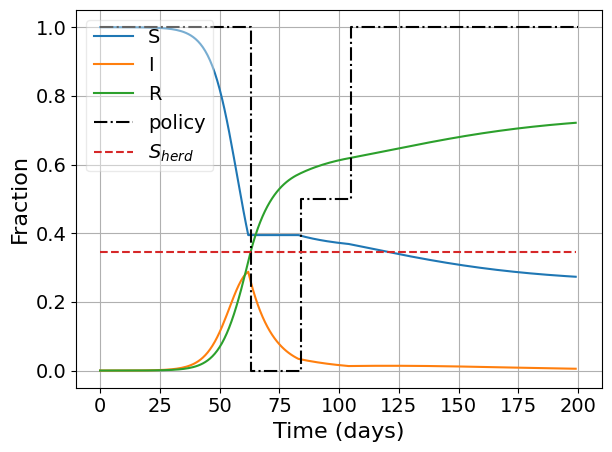

time: 1.9 s (started: 2024-06-03 04:15:07 +00:00)


In [ ]:
# start policy compelete lockdown at day 60
S0 = 67000 - 1
I0 = 1
county_pop = 67000
county_area = 1
beta=0.29
gamma=0.1
T= 200
delta_t = 21
policy = [1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
# policy = [1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0]
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

cost_min,S,I,R,_,_ = evaluate_cost_single(S0, I0, county_pop, county_area,
                                      policy,delta_t,T=T,
                                      beta =beta,gamma=gamma,
                                      kappa = 0, eta = 1)
plt.figure()
plt.plot(S/67000,label='S')
plt.plot(I/67000,label='I')
plt.plot(R/67000,label='R')
x = [delta_t*i for i in range(len(policy))] + [T]
plt.step(x,policy+[policy[-1]],label= 'policy',linestyle='dashdot',where='post',color ='k')
plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper left',framealpha=0.4)
plt.xlabel('Time (days)')
plt.grid()
plt.ylabel('Fraction')
ax.set_xticks(np.arange(0, 200, 25))

plt.tight_layout()
# plt.title('End ratio = '+str(end_ratio))
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=20.pdf")
new_path = os.path.join(PATH,'SingleCounty/flipped_policy_delta_t='+str(delta_t)+'.pdf')
print(new_path)
plt.savefig(new_path)
# print('Final size:',S[-1]/67000)

Final size: 0.3096756282559176


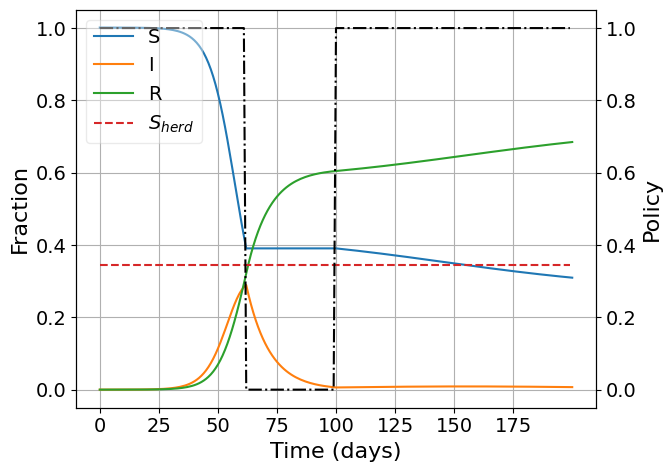

time: 2.55 s (started: 2024-06-03 04:18:08 +00:00)


In [ ]:
# Bliman original
S1 = [6.710e7 - 1e3]
I1 = [1e3]
R1 = [0]
county_pop = 6.7e7
beta = 0.29
gamma = 0.1
policy=[]

for t in range(T):
  if t >=0 and t<62 or t >=100:
    alpha = 1
    policy.append(alpha)
  else:
    alpha = 0
    policy.append(alpha)

  S_new,I_new,R_new = update_SIR(S1[-1],I1[-1],R1[-1], alpha,county_pop, beta, gamma)
  S1.append(S_new)
  I1.append(I_new)
  R1.append(R_new)

fig,ax= plt.subplots(figsize=(7,5))
ax.plot([s/county_pop for s in S1],label='S')
ax.plot([i/county_pop for i in I1],label='I')
ax.plot([r/county_pop for r in R1],label='R')

ax.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper left',framealpha=0.4)
plt.xlabel('Time (days)')
plt.grid()
ax.set_ylim(-0.05,1.05)
ax.set_ylabel('Fraction')
ax.set_xticks(np.arange(0, 200, 25))

ax2 = ax.twinx()
ax.plot(policy,label= 'policy',linestyle='dashdot',color ='k')
ax2.set_ylim(-0.05,1.05)
ax2.set_ylabel('Policy')

plt.tight_layout()
new_path = os.path.join(PATH,"SingleCounty/optimal_policy_bliman.pdf")
# print(new_path)

plt.savefig(new_path)
print('Final size:',S1[-1]/county_pop)

Final size: 0.48657897862019855


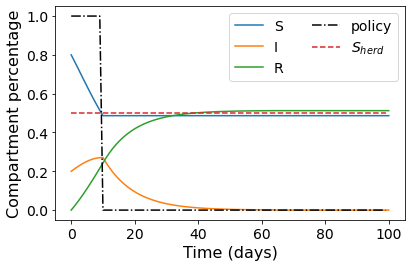

time: 1.33 s (started: 2022-08-08 05:25:46 +00:00)


In [ ]:
#county_pop = 1000
S1 = [0.8*county_pop]
I1 = [0.2*county_pop]
R1 = [0]
beta = 0.2
gamma = 0.1
policy=[]

for t in range(T):
  if S1[-1] <= 0.5*county_pop:
    # print('S:',S1[-1])
    # print('I:',I1[-1])
    alpha = 0
  else:
    alpha  = 1
  policy.append(alpha)

  S_new,I_new,R_new = update_SIR(S1[-1],I1[-1],R1[-1], alpha,county_pop, beta, gamma,h=1)
  # print(S_new)
  S1.append(S_new)
  I1.append(I_new)
  R1.append(R_new)

plt.figure()
plt.plot([s/county_pop for s in S1],label='S')
plt.plot([i/county_pop for i in I1],label='I')
plt.plot([r/county_pop for r in R1],label='R')
plt.plot(policy,label= 'policy',linestyle='dashdot',color ='k')
plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
plt.ylabel('Compartment percentage')
plt.legend(ncol=2,loc='best')
plt.xlabel('Time (days)')
plt.tight_layout()
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_bliman.pdf")
# print(new_path)
# plt.savefig(new_path,figsize=(7,5))
print('Final size:',S1[-1]/county_pop)

In [ ]:
policy

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

time: 11.6 ms (started: 2022-08-08 05:25:01 +00:00)


In [ ]:
print(S[50:62]/county_pop)

[0.00088216 0.00086332 0.0008421  0.00081843 0.00079226 0.00076364
 0.00073271 0.00069968 0.0006649  0.00062879 0.0006103  0.00059257]
time: 12.9 ms (started: 2022-05-26 17:26:39 +00:00)


In [ ]:
print(S[50:62]/county_pop)

[0.00088216 0.00086332 0.0008421  0.00081843 0.00079226 0.00076364
 0.00073271 0.00069968 0.0006649  0.00062879 0.0006103  0.00059257]
time: 6.57 ms (started: 2022-05-26 17:26:16 +00:00)


In [ ]:
6.7e5

670000.0

time: 5.76 ms (started: 2022-05-26 17:24:21 +00:00)


Final size: 0.21118931998312587


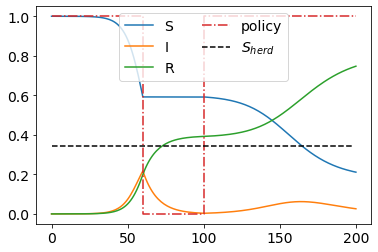

time: 456 ms (started: 2022-05-26 17:15:14 +00:00)


In [ ]:
S1 = [67000 -1]
I1 = [1]
R1 = [0]
county_pop = 67000
beta = 0.29
gamma = 0.1

for t in range(T):
  if t >=0 and t<60 or t >=100:
    alpha = 1
  else:
    alpha =0

  S_new,I_new,R_new = update_SIR(S1[-1],I1[-1],R1[-1], alpha,county_pop, beta, gamma)
  S1.append(S_new)
  I1.append(I_new)
  R1.append(R_new)

plt.figure()
plt.plot([s/67000 for s in S1],label='S')
plt.plot([i/67000 for i in I1],label='I')
plt.plot([r/67000 for r in R1],label='R')
plt.step(x,policy+[policy[-1]],label= 'policy',linestyle='dashdot',where='post')
plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$',color ='k')
plt.legend(ncol=2,loc='best')
print('Final size:',S1[-1]/67000)
# print(1- (S[100]/67000 + I[100]/67000 - gamma/beta*math.log(S[100]/67000)))

In [ ]:
#bliman
T = 200
beta =0.291
gamma=0.1
plt.figure()
# for i,delta_t in enumerate([7,14,21,28]):
I_all = []
optimal_policy_all = []
delta_t = 20
# kappa=1/50,eta=49/50
kappa = 0
eta = 1
for end_ratio in [0.5]:
  optimal_policy,cost_min, S,I,R,_,_ = multi_county_search(T=T,
                                                        delta_t=delta_t,
                                                        S0 = [67000 - 1]*2,
                                                        I0 = [1]*2,
                                                        end_ratio = end_ratio,
                                                        county_pop = [67000]*2,
                                                        county_area = [1]*2,
                                                        kappa=kappa,eta=eta,
                                                        beta =beta,
                                                        gamma=gamma,
                                                        reach_hi=False,
                                                        intensity_max=0,
                                                        modification=True,
                                                        verbose=False)

  # x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  # y = list(optimal_policy) + [optimal_policy[-1]]
  # I_all.append(I)
  # optimal_policy_all.append(optimal_policy)
  # plt.figure()
  # plt.plot(S[0,:]/67000,label='S')
  # plt.plot(I[0,:]/67000,label='I')
  # plt.plot(R[0,:]/67000,label='R')
  # plt.step(x,y,label= 'policy',linestyle='dashdot',where='post')
  # plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$',color ='k')
  # plt.legend(ncol=2,loc='best')
  # plt.title('End ratio = '+str(end_ratio))
  # ax.grid()
  # plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

time: 279 ms (started: 2022-09-01 03:41:13 +00:00)


In [ ]:
  x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  y = list(optimal_policy) + [optimal_policy[-1]]
  I_all.append(I)
  optimal_policy_all.append(optimal_policy)
  plt.figure()
  plt.plot(S[0,:]/67000,label='S')
  plt.plot(I[0,:]/67000,label='I')
  plt.plot(R[0,:]/67000,label='R')
  plt.step(x,y,label= 'policy',linestyle='dashdot',where='post')
  plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$',color ='k')
  plt.legend(ncol=2,loc='best')
  plt.title('End ratio = '+str(end_ratio))
  ax.grid()
  plt.show()

NameError: ignored

time: 23 ms (started: 2022-09-01 03:41:14 +00:00)


## Optimal control - counties

In [ ]:
county_pops = [874784, 3.17e6, 10.04e6]
# land only
county_areas = [46.87, 948, 4058]
# water and land
# oc does not have water
# county_areas = [231.89, 948, 4753] # mi^2
for i in range(3):
  p = county_pops[i]/county_areas[i]
  print(p)


18664.049498613185
3343.8818565400843
2474.1251848201086
time: 4.4 ms (started: 2022-06-16 15:59:44 +00:00)


i0 0.00013
r0 0.1
start_grid: 6
start date: 42.0
end_grid: 14
end date: 98.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.5653416469242466
implementation cost: 0
impact cost: 0.5653416469242466
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
19.6
Implementation cost: 19.6
Normalized Implementation cost: 0.1
Impact cost: 0.2826708234621233


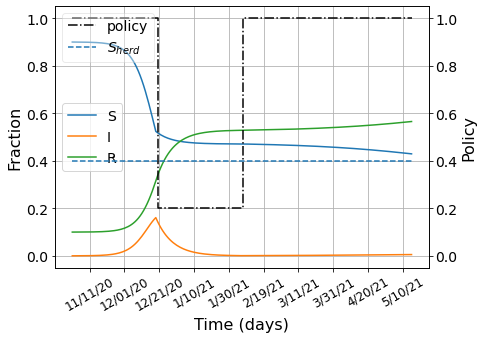

i0 0.00013
r0 0.2
start_grid: 6
start date: 42.0
end_grid: 14
end date: 98.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.5956658992176527
implementation cost: 0
impact cost: 0.5956658992176527
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
15.400000000000002
Implementation cost: 15.400000000000002
Normalized Implementation cost: 0.07857142857142858
Impact cost: 0.29783294960882634


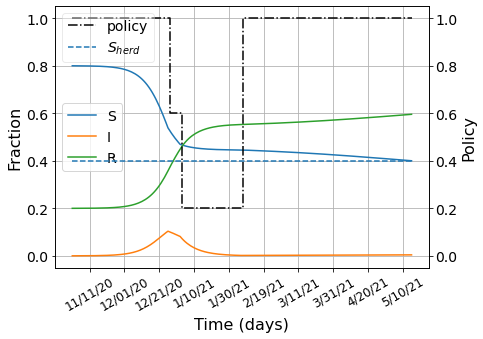

i0 0.00013
r0 0.3
start_grid: 6
start date: 42.0
end_grid: 14
end date: 98.0


KeyboardInterrupt: ignored

time: 47.8 s (started: 2022-09-02 18:47:21 +00:00)


In [ ]:
# la
T = 196
R0 = 2.5
gamma=0.14
beta = R0*gamma
delta_t = 7
# kappa= 0.635
# eta= 1-kappa
# kappa= 0.25
kappa = 0
eta= 1-kappa

i0 = 1.3*1e-4
#2.38*1e-4
# r0 = (4.65 + (3.18 - 0.0657)*gamma)*1e-2
# r0 = 3.7*1e-2
for r0 in [0.1,0.2, 0.3]:
  # for i0 in [1.3*1e-4 ,2*1.3*1e-4 ,4*1.3*1e-4,8*1.3*1e-4]:
  print('i0',round(i0,6))
  print('r0',r0)
  s0 = 1 - i0 - r0

  start_ratio = delta_t*6/T
  end_ratio = 98/T

  county_pop = 10.04e6
  county_area = 1

  optimal_policy,cost_min, S,I,R,implementation_cost, impact_cost,count = single_county_search(T=T,
                                                                                          delta_t=delta_t,
                                                                                          S0 = county_pop*s0,
                                                                                          I0 = county_pop*i0,
                                                                                          start_ratio = start_ratio,
                                                                                          end_ratio = end_ratio,
                                                                                          county_pop = county_pop,
                                                                                          county_area = county_area,
                                                                                          kappa=kappa,eta=eta,
                                                                                          beta =beta,gamma=gamma,
                                                                                        intensity_max=0.2,
                                                                                          reach_hi=True,
                                                                                          herd_dist=3e-2,
                                                                                          # herd_dist=1e-4,
                                                                                          modification=True,
                                                                                          verbose=False,to_infinity=False)

  print(optimal_policy)
  cost = 0
  for alpha in optimal_policy:
    cost += 1/2*(1-alpha)*delta_t
  print(cost)
  cost /=delta_t*len(optimal_policy)
  print('Implementation cost:',cost*T)
  print('Normalized Implementation cost:',cost)
  print('Impact cost:',1/2*R[-1]/county_pop)
  start = datetime.datetime.strptime("11/1/20", "%m/%d/%y")
  y = []
  for i in range(len(optimal_policy)):
    y += [optimal_policy[i]]*delta_t
  fig,ax= plt.subplots(figsize=(7, 5))
  xx= [start + datetime.timedelta(days=x) for x in range(T)]
  ax.plot(xx,S/county_pop,label='S')
  ax.plot(xx,I/county_pop,label='I')
  ax.plot(xx,R/county_pop,label='R')
  # ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
  # ax.set_ylim((0,0.008))
  ax.grid()
  ax.set_ylabel('Fraction')
  ax.legend(loc='center left')
  ax.set_ylim(-0.05,1.05)
  plt.xticks(rotation = 30,fontsize=12)
  plt.xlabel('Time (days)')

  ax2 = ax.twinx()
  ax2.set_ylabel('Policy')
  ax2.set_ylim(-0.05,1.05)
  ax2.step(xx,y,label= 'policy',linestyle='dashdot',where = 'post',color ='k')
  ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
  ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

  # plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  plt.plot(xx,[gamma/beta]*len(xx),'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='upper left',framealpha=0.4)

  plt.tight_layout()
  new_path = os.path.join(PATH,'SingleCounty/la_R0='+str(R0)+'_r0='+str(r0)+'_delta_t='+str(delta_t)+'.pdf')
  # print(new_path)
  plt.savefig(new_path,figsize=(7,5))
  plt.show()

In [ ]:
# optimal_policy = [1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# delta_t = 10


20.0
Implementation cost: 0.1
time: 26.8 ms (started: 2022-07-13 20:49:35 +00:00)


In [ ]:
print('Total number of policy:', 3**(round(T*end_ratio/delta_t)))
print('# of path reached herd immunity:',count)

Total number of policy: 59049
# of path reached herd immunity: 9982
time: 1.52 ms (started: 2022-07-13 18:05:21 +00:00)


Final size: 0.6372138007506521
Final S: 0.3566141565573796


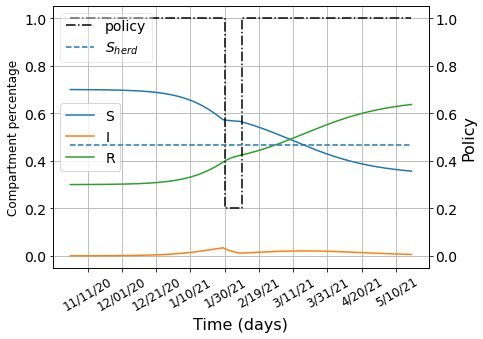

time: 577 ms (started: 2022-07-13 18:05:21 +00:00)


In [ ]:
start = datetime.datetime.strptime("11/1/20", "%m/%d/%y")
y = []
for i in range(len(optimal_policy)):
  y += [optimal_policy[i]]*delta_t
fig,ax= plt.subplots(figsize=(7, 5))
xx= [start + datetime.timedelta(days=x) for x in range(T)]
ax.plot(xx,S/county_pop,label='S')
ax.plot(xx,I/county_pop,label='I')
ax.plot(xx,R/county_pop,label='R')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
# ax.set_ylim((0,0.008))
ax.grid()
ax.set_ylabel('Compartment percentage',fontsize=12)
ax.legend(loc='center left')
ax.set_ylim(-0.05,1.05)
plt.xticks(rotation = 30,fontsize=12)
plt.xlabel('Time (days)')

ax2 = ax.twinx()
ax2.set_ylabel('Policy')
ax2.set_ylim(-0.05,1.05)
ax2.step(xx,y,label= 'policy',linestyle='dashdot',where = 'post',color ='k')
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

# plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
plt.plot(xx,[gamma/beta]*len(xx),'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='upper left',framealpha=0.4)

plt.tight_layout()
print('Final size:',R[-1]/county_pop)
print('Final S:',S[-1]/county_pop)

Final size: 0.6806913376575904


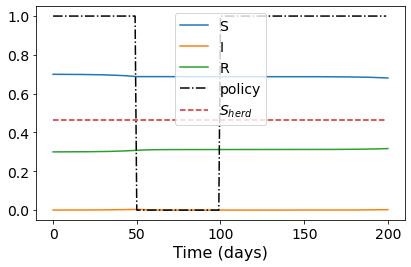

time: 394 ms (started: 2022-07-13 18:05:21 +00:00)


In [ ]:
S1 = [s0*county_pop]
I1 = [i0*county_pop]
R1 = [r0*county_pop]

policy=[]

for t in range(T):
  if t >=0 and t<50 or t >=100:
    alpha = 1
    policy.append(alpha)
  else:
    alpha = 0
    policy.append(alpha)

  S_new,I_new,R_new = update_SIR(S1[-1],I1[-1],R1[-1], alpha,county_pop, beta, gamma)
  S1.append(S_new)
  I1.append(I_new)
  R1.append(R_new)

plt.figure()
plt.plot([s/county_pop for s in S1],label='S')
plt.plot([i/county_pop for i in I1],label='I')
plt.plot([r/county_pop for r in R1],label='R')
plt.plot(policy,label= 'policy',linestyle='dashdot',color ='k')
plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='best')
plt.xlabel('Time (days)')
plt.tight_layout()
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_bliman.pdf")
# print(new_path)
# plt.savefig(new_path,figsize=(7,5))
print('Final size:',S1[-1]/county_pop)

In [ ]:
county_area = 1
T= 200
# delta_t = 20
# policy = [1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0]
# policy = [1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
delta_t = 20
policy = [1.0, 1.0, 0.6, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0]

# policy = [1.0, 1.0, 1.0, 1.0, 1.0,
#           0.2, 0.2, 0.2, 0.2, 0.2,
#           1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 1.0, 1.0 ,1.0, 1.0]
# policy = [1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 0.2, 0.2, 0.2, 0.2,
#           1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 1.0, 1.0 ,1.0, 1.0]
# delta_t = 5
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
#           1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
#           1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0,
#           1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0]
# policy = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
          # 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
          # 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
          # 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

cost_min,S,I,R,implementation_cost, impact_cost = evaluate_cost_single(s0*county_pop,
                                                                       i0*county_pop,
                                                                       county_pop, county_area,
                                                                        policy,delta_t,T=T,
                                                                        beta =beta,gamma=gamma,
                                                                        kappa = 0, eta = 1)
plt.figure()
plt.plot(S/county_pop,label='S')
plt.plot(I/county_pop,label='I')
plt.plot(R/county_pop,label='R')
x = [delta_t*i for i in range(len(policy))] + [T]
plt.step(x,policy+[policy[-1]],label= 'policy',linestyle='dashdot',where='post',color ='k')
plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
plt.legend(ncol=1,loc='best')
plt.xlabel('Time (days)')
plt.gird()
plt.tight_layout()
# plt.title('End ratio = '+str(end_ratio))
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=20.pdf")
# new_path = os.path.join(PATH,"SingleCounty/flipped_policy_delta_t=20.pdf")
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_delta_t=5.pdf")
# # print(new_path)
# plt.savefig(new_path,figsize=(7,5))
print('S herd:',S[-1]/county_pop)
print('Final size:',R[-1]/county_pop)

NameError: ignored

time: 131 ms (started: 2022-08-11 15:59:31 +00:00)


In [ ]:
S1,I1,R1 = deterministic_sir(beta, gamma, county_pop, T, i0, s0=s0,h=1)
fig,ax= plt.subplots(figsize=(7, 5))
# xx= [start + datetime.timedelta(days=x) for x in range(T)]
# ax.plot(xx,np.array(S1)/county_pop,label='S')
# ax.plot(xx,np.array(I1)/county_pop,label='I')
# ax.plot(xx,np.array(R1)/county_pop,label='R')
ax.plot(np.array(S1)/county_pop,label='S')
ax.plot(np.array(I1)/county_pop,label='I')
ax.plot(np.array(R1)/county_pop,label='R')
ax.set_ylabel('Compartment percentage',fontsize=12)
ax.legend(loc='center right')
plt.xticks(rotation = 30,fontsize=12)

TypeError: ignored

time: 35.7 ms (started: 2022-07-14 21:05:06 +00:00)


start date 2020-11-01 00:00:00
end date 2021-05-19 00:00:00
i0 0.00013000000000000002
r0 0.1
200
implementation cost 23.500000000000018
Normalized implementation cost 0.11750000000000009
impact cost 0.37848558713925645
Total cost 0.49598558713925656
Final size: 0.7569711742785129
Final size: 0.21917451775897362
R0: 2.15
i0 0.0005200000000000001
r0 0.1
200
implementation cost 23.500000000000018
Normalized implementation cost 0.11750000000000009
impact cost 0.38474765117875026
Total cost 0.5022476511787504
Final size: 0.7694953023575005
Final size: 0.2172645898911242
R0: 2.15
i0 0.0010400000000000001
r0 0.1
200
implementation cost 23.500000000000018
Normalized implementation cost 0.11750000000000009
impact cost 0.38151083308440326
Total cost 0.49901083308440336
Final size: 0.7630216661688065
Final size: 0.22520678760012858
R0: 2.15
i0 0.00013000000000000002
r0 0.2
200
implementation cost 23.500000000000018
Normalized implementation cost 0.11750000000000009
impact cost 0.24392955052457835

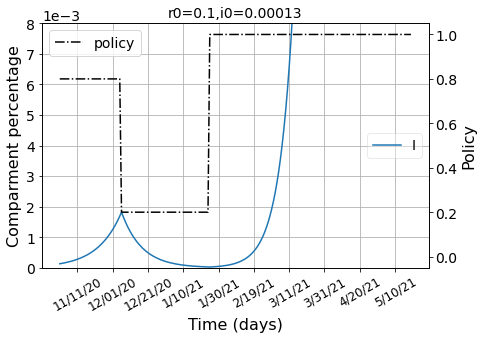

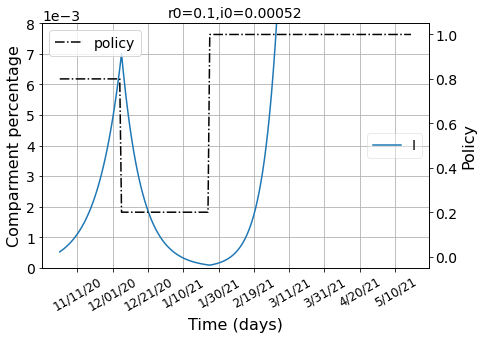

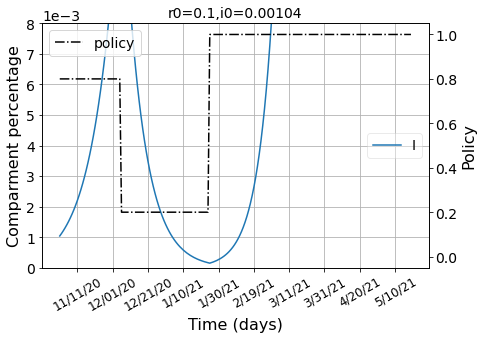

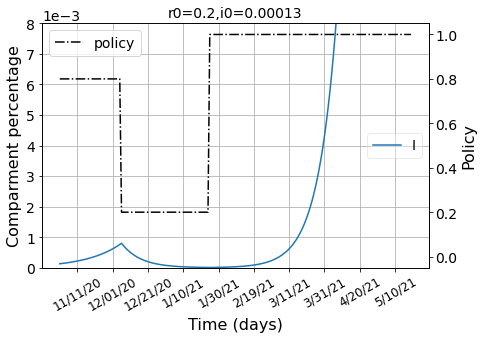

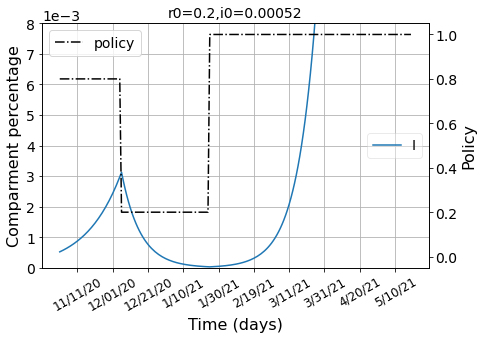

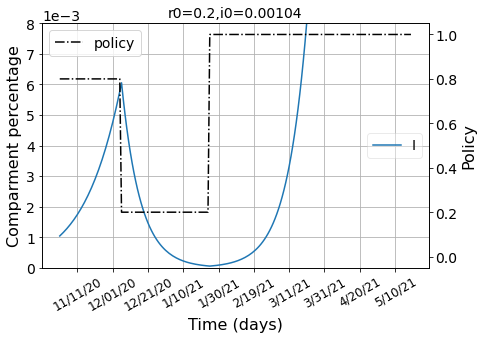

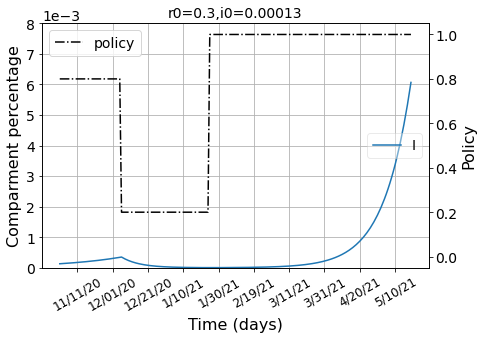

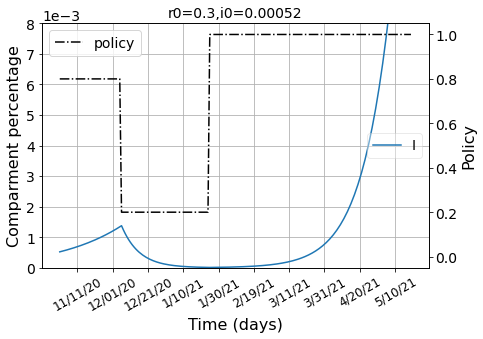

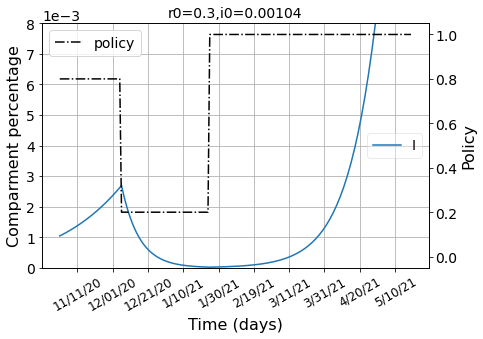

time: 7.4 s (started: 2022-07-21 20:46:45 +00:00)


In [ ]:

# LA
# get real la policy
R0 = 2.15
start = datetime.datetime.strptime("11/1/20", "%m/%d/%y")
T = 200
xx= [start + datetime.timedelta(days=x) for x in range(T)]
start_date = xx[0]
end_date = xx[-1]
print('start date', xx[0])
print('end date',xx[-1])
df_la = plot_real_policy(df_policy, 'Los Angeles County', 'CA', plot=False, start_date=start_date, end_date=end_date,save=False)
policy_la = df_la['Stay_at_Home_Order_Recommendation']
# print(policy_la)
county_pop = 10.04e6
gamma= 0.14
# i0 = 2.38*1e-4
i0 = 1.3*1e-4
# r0 = (4.65 + (3.18 - 0.0657)*gamma)*1e-2
r0 = 0.2  #3.7*1e-2
# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
idx = 0
for r0 in [0.1,0.2,0.3]:
  for i0 in [1.3*1e-4,4*1.3*1e-4,8*1.3*1e-4]:
    # ax = axs.ravel()[idx]
    print('i0',i0)
    print('r0',r0)
    s0 = 1 - i0 - r0

    #T = len(policy_la.values)
    print(T)
    # for R0 in [1.8,1.85,1.9, 1.95,2,2.05,2.1,2.15,2.2,2.25,.3]:
    S1 = [s0*county_pop]
    I1 = [i0*county_pop]
    R1 = [r0*county_pop]
    beta = R0*gamma
    cost = 0
    kappa = 1/2
    eta = 1-kappa
    for t in range(T-1):
      alpha = policy_la.values[t]/5
      S_new,I_new,R_new = update_SIR(S1[-1],I1[-1],R1[-1], alpha,county_pop, beta, gamma)
      S1.append(S_new)
      I1.append(I_new)
      R1.append(R_new)
      cost += kappa*(1 - alpha)/T
    print("implementation cost",cost*T)
    print('Normalized implementation cost',cost)
    print('impact cost', eta*R1[-1]/county_pop)
    cost += eta*R1[-1]/county_pop
    print('Total cost',cost)
    fig, ax= plt.subplots(figsize=(7, 5))
    # plt.plot(xx,[s/county_pop for s in S1],label='S')
    plt.plot(xx,[i/county_pop for i in I1],label='I')
    # plt.plot(xx,[r/county_pop for r in R1],label='R')
    ax.set_ylim((0,0.008))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.grid()

    plt.legend(framealpha=0.4,loc='right')
    ax.set_ylabel('compartment percentage')
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
    ax.set_xlabel('Time (days)')
    plt.xticks(rotation = 30,fontsize=12)

    ax2 = ax.twinx()
    ax2.set_ylim(-.05,1.05)
    ax2.plot(xx,policy_la.values/5, label= 'policy',linestyle='dashdot',color ='k')
    # ax2.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
    ax2.set_ylabel('Policy')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
    plt.legend(ncol=1,loc='best')
    plt.title('r0='+str(r0)+',i0='+str(round(i0,6)))

    plt.tight_layout()
    # new_path = os.path.join(PATH,"SingleCounty/optimal_policy_bliman.pdf")
    # print(new_path)
    # plt.savefig(new_path,figsize=(7,5))
    print('Final size:',R1[-1]/county_pop)
    print('Final size:',S1[-1]/county_pop)
    print('R0:',R0)
    idx+=1
    # print('Infected:',I1[34]/county_pop- 0.000671)

In [ ]:
xx[34]

datetime.datetime(2020, 12, 5, 0, 0)

time: 10.7 ms (started: 2022-07-12 20:51:29 +00:00)


In [ ]:
print(len(I1))

199
time: 2.61 ms (started: 2022-07-12 20:47:19 +00:00)


11/1/20    0.000130
11/2/20    0.000137
11/3/20    0.000134
11/4/20    0.000141
11/5/20    0.000145
Name: 215, dtype: float64


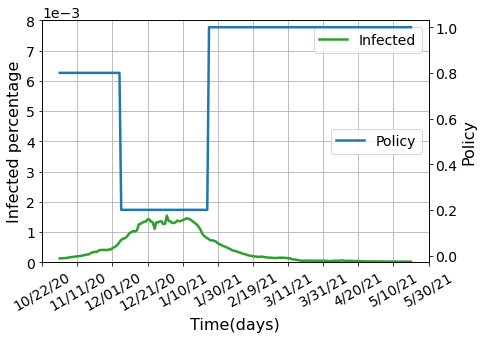

time: 1.06 s (started: 2022-07-13 20:28:53 +00:00)


In [ ]:
 # plot policy and infected in the same plot
# Secondary y-axis
fig, ax2= plt.subplots(figsize=(7, 5))
# df_county_policy = df_policy[(df_policy['County_Name'] == 'Los Angeles County') & (df_policy['State_Tribe_Territory'] == 'CA')]
# df_county_policy = df_county_policy.sort_values(by='date')
# df_county_policy['Stay_at_Home_Order_Recommendation'] = df_county_policy['Stay_at_Home_Order_Recommendation']/5
# print(df_county_policy.head())
# df_county_policy['date'] = pd.to_datetime(df_county_policy.date)
# df_county_policy.set_index('date', inplace=True)

start_date = '11/1/2020'
# end_date = '2/8/2021'
end_date='5/20/21'
df_county_policy = plot_real_policy(df_policy, 'Los Angeles County', 'CA',plot=False, start_date=start_date, end_date=end_date,save=False)
df_county_policy['Stay_at_Home_Order_Recommendation'] = df_county_policy['Stay_at_Home_Order_Recommendation']/5

start_date='10/25/20'
# end_date='2/8/21'
county_pop = 1.04e7

ax2.set_ylabel('Infected percentage')
data_county = confirmed_data.loc[(confirmed_data["Province_State"] == 'California') &(confirmed_data["Admin2"] == 'Los Angeles')]
data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop
# print(data.head())
# remove negative data
data[data<=0] = 0
data=data.iloc[0,7:]
# print(data.head())

df_county_policy['infected'] = data.values
ax2.plot(df_county_policy['date'], df_county_policy['infected'],label = 'Infected',color=county_color[0],linewidth=2.5)
ax2.legend(loc='upper right')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax2.set_ylim((0,0.008))
ax2.grid()
ax2.tick_params(axis='x',rotation=30)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
ax2.set_xlabel('Time(days)')

ax =  ax2.twinx()
ax.plot(df_county_policy['date'], df_county_policy['Stay_at_Home_Order_Recommendation'],label = 'Policy',linewidth=2.5)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
# df_county_policy.plot(x='date', y= 'Stay_at_Home_Order_Recommendation', ax = ax, legend= True,grid=True, label='Policy',linewidth=2.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(11))
ax.set_ylabel('Policy')
ax.legend(loc='center right')
# ax.ticklabel_format(axis='y', style='sci')

ax.set_ylim(-0.03,1.03)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

plt.tight_layout()

# plt.show()
# plt.legend(fontsize=SMALL_SIZE)
# if save:
#   new_path = os.path.join(PATH,"policy_cali_real.eps")
#   print(new_path)

In [ ]:
13507/10.04e6

0.0013453187250996015

time: 18.2 ms (started: 2022-07-12 01:52:00 +00:00)


In [ ]:

df_county_policy[(df_county_policy['date'] >= '12/5/2020') & (df_county_policy['date'] <= '12/6/2020')]#['infected']

State_Tribe_Territory         County_Name  FIPS_State  FIPS_County  \
59862                    CA  Los Angeles County           6           37   
59863                    CA  Los Angeles County           6           37   

            date  Order_code  Stay_at_Home_Order_Recommendation  \
59862 2020-12-05           6                                0.8   
59863 2020-12-06           2                                0.2   

      Express_Preemption Source_of_Action  URL  \
59862            Unknown         Official  NaN   
59863            Unknown         Official  NaN   

                                        Citation  infected  
59862          Cal. Health Order (July 13, 2020)  0.000671  
59863  Cal. Regional Stay at Home (Dec. 5, 2020)  0.000743

time: 40.1 ms (started: 2022-07-12 20:33:14 +00:00)


In [ ]:
import datetime
str_d1 = '2021/5/20'
str_d2 = '2020/11/1'

# convert string to date object
d1 = datetime.datetime.strptime(str_d1, "%Y/%m/%d")
d2 = datetime.datetime.strptime(str_d2, "%Y/%m/%d")

# difference between dates in timedelta
delta = d2 - d1
print(delta.days)

-200
time: 16.8 ms (started: 2022-07-13 19:49:03 +00:00)


## Optimal control - cost trade off

In [ ]:
# optimal control different cost function
# with implementation cost
T = 200
beta =0.29
gamma=0.1
county_pop= 67000

I_all = []
S_all = []
R_all = []
optimal_policy_all = []
delta_t = 20
start_ratio = 0
end_ratio = 0.5
county_area = 1
kappas = [1, 0.99,0.945, 0.9, 0.1]
for kappa in kappas:
  eta = 1 - kappa
  optimal_policy,cost_min, S,I,R,implementation_cost, impact_cost = single_county_search(T=T,
                                                                                          delta_t=delta_t,
                                                                                          S0 = county_pop - 1,
                                                                                          I0 = 1,
                                                                                          start_ratio = start_ratio,
                                                                                          end_ratio = end_ratio,
                                                                                          county_pop = county_pop,
                                                                                          county_area = county_area,
                                                                                          kappa=kappa,eta=eta,
                                                                                          beta =beta,gamma=gamma,

                                                                                          reach_hi=False, modification=True,
                                                                                          verbose=False,to_infinity=False)


  print(optimal_policy)
  I_all.append(I)
  S_all.append(S)
  R_all.append(R)
  optimal_policy_all.append(optimal_policy)

  print('Final size:',S[-1]/67000)

start_grid: 0
start date: 0
end_grid: 5
end date: 100.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.0
implementation cost: 0.0
impact cost: 0.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Final size: 0.06880811993568729
start_grid: 0
start date: 0
end_grid: 5
end date: 100.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.009146587645079193
implementation cost: 0.0
impact cost: 0.009146587645079193
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Final size: 0.06880811993568729
start_grid: 0
start date: 0
end_grid: 5
end date: 100.0
Optimal policy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.05030623204793555
implementation cost: 0.0
impact cost: 0.05030623204793555
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Final size: 0.06880811993568729
start_grid: 0
start date: 0
end_grid: 5
end date: 100.0
Optimal policy: [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Min cost: 0.0900000480928

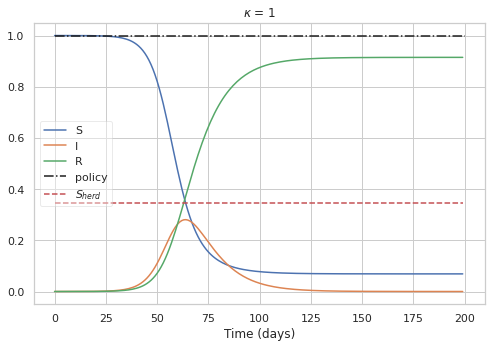

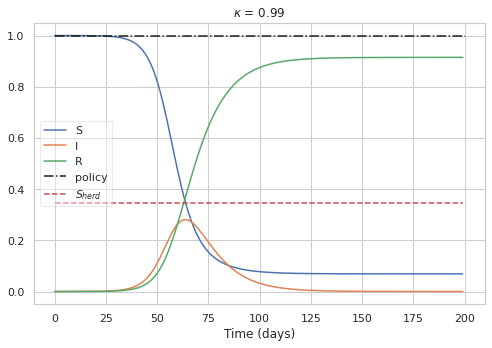

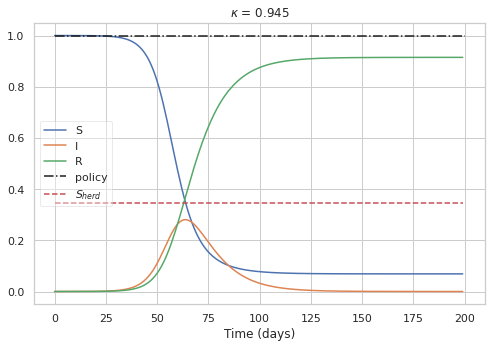

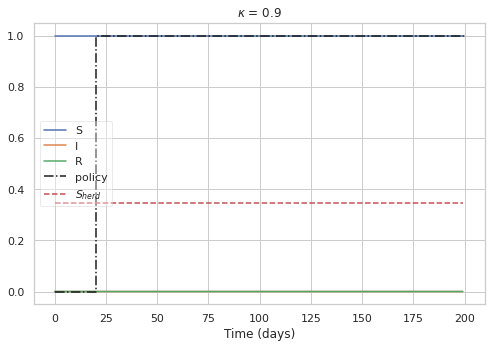

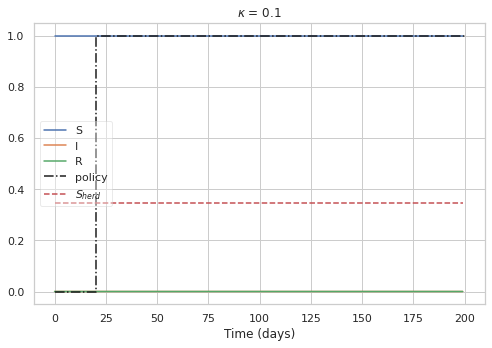

time: 3.8 s (started: 2022-06-23 17:57:17 +00:00)


In [ ]:
for i in range(len(kappas)):
  optimal_policy = optimal_policy_all[i]
  kappa = kappas[i]
  I = I_all[i]
  S = S_all[i]
  R = R_all[i]
  x = [delta_t*i for i in range(len(optimal_policy))] + [T]
  y = list(optimal_policy) + [optimal_policy[-1]]
  plt.figure(figsize=(7,5))
  plt.plot(S/county_pop,label='S')
  plt.plot(I/county_pop,label='I')
  plt.plot(R/county_pop,label='R')
  plt.step(x,y,label= 'policy',linestyle='dashdot',where='post',color ='k')
  plt.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
  plt.legend(ncol=1,loc='center left',framealpha=0.4)
  plt.xlabel('Time (days)')
  plt.title(r'$\kappa$ = '+str(kappa))
  plt.tight_layout()

# Other Simulations

## Waves across counties

In [ ]:
# Independent
federal_policys = [1, 0.4, 1]
i0 = [0.02,0,0,0]
T = 160
beta = 0.3
gamma = 0.07

county_pop = [100]*4
# county_pop = [500,500,500,500]
county_area = [500,500,500,500]
kappa_county = [1/2,1/2,1/2,1/2]
eta_county = [1/4]*4
# eta_county = [1/3,1/3,1/3,1/3]

n_county = len(county_pop)
# K = 0.05*np.ones((n_county,n_county))
# np.fill_diagonal(K, 1)
K = np.array([[1,0,0,0.01],
             [0.01,1,0,0],
             [0,0.01,1,0],
             [0,0,0.01,1]])

S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                            federal_policys, i0,
                                                                            i_threshold = 0.1,
                                                                            delta_t = 60,
                                                                            county_pop=county_pop,
                                                                            county_area = county_area,
                                                                            p1=1,p2=1,dt=1,
                                                                            kappa=1/3,eta=1/3,
                                                                            K = K,
                                                                            kappa_county = kappa_county,
                                                                            eta_county = eta_county,
                                                                            two_sided=False)



Excitation matrix: [[1.   0.   0.   0.01]
 [0.01 1.   0.   0.  ]
 [0.   0.01 1.   0.  ]
 [0.   0.   0.01 1.  ]]
Federal policy released
state 0 policy at day 19: 0.1381838125692702
County update every 10 days:
[0.21043961 0.17844506 0.24929492 0.24929492]
County update every 10 days:
[0.22718724 0.17982093 0.24929492 0.24929492]
County update every 10 days:
[0.23603993 0.19469762 0.24929492 0.24929492]
County update every 10 days:
[0.24178642 0.19599784 0.24929492 0.24929492]
County update every 10 days:
[0.24489602 0.2143081  0.24929492 0.24929492]
County update every 10 days:
[0.24776212 0.21539271 0.24929492 0.24929492]
No Federal intervention.
state 0 policy at day 80: 0.9999940391390134
County update every 10 days:
[0.99999404 0.99999404 0.22964812 0.99999404]
County update every 10 days:
[0.99999404 0.99999404 0.23672794 0.25895402]
County update every 10 days:


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0.99999404 0.99999404 0.24422003 0.26253429]
County update every 10 days:
[0.99999404 0.99999404 0.25216675 0.26621007]
County update every 10 days:
[0.99999404 0.99999404 0.26061627 0.23672794]
County update every 10 days:
[0.99999404 0.99999404 0.26961627 0.27784189]
County update every 10 days:
[0.99999404 0.99999404 0.27923334 0.2481339 ]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


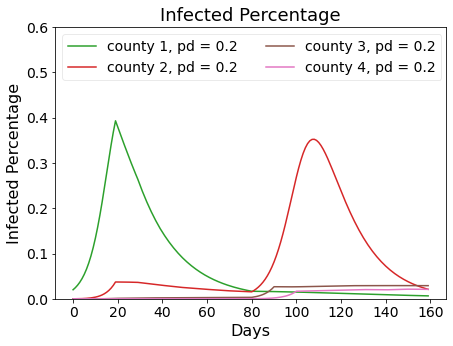

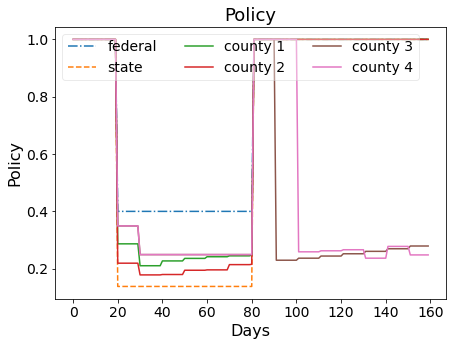

In [ ]:
plot_i(I, county_pop, county_area, T, figsize=(7,5),ylimit=(0,0.6),ncol=2)

# new_path = os.path.join(PATH,"I_K=I+0.0/1_imp.eps")
# print(new_path)
# plt.savefig(new_path,figsize=(7,5))
plot_policy(T,federal_policy_all,
                state_policy_all,
                county_policy_all,
                FEDERAL_COLOR=FEDERAL_COLOR,
                state_color=state_color,
                county_color=county_color,
                figsize = (7,5))
# new_path = os.path.join(PATH,"policy_K=I+0.01_imp.pdf")
# print(new_path)
# plt.savefig(new_path,figsize=(7,5))

In [ ]:
county_labels = ['County 4','County 3','County 3','County 1']
ridgeline(I,county_pop, overlap=.75,fill=True, labels=county_labels, n_points=150)

NameError: ignored

In [ ]:
# Independent
federal_policys = [1, 0.4, 1]
i0 = [0.02,0,0,0]
T = 160
beta = 0.3
gamma = 0.07

county_pop = [100]*4
# county_pop = [500,500,500,500]
county_area = [500,500,500,500]

n_county = len(county_pop)
# K = 0.05*np.ones((n_county,n_county))
# np.fill_diagonal(K, 1)
K = np.array([[1,0,0,0.01],
             [0.01,1,0,0],
             [0,0.01,1,0],
             [0,0,0.01,1]])
S,I,R = network_sir(beta, gamma, T, i0,
                    county_pop=county_pop,
                    county_area = county_area,
                    p1=1,p2=1,dt=1,
                    K = K)


In [ ]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


def ridgeline(I,county_pop, overlap=0, fill=True, labels=None, n_points=150):
    """
    Creates a standard ridgeline plot.

    data, list of lists.
    overlap, overlap between distributions. 1 max overlap, 0 no overlap.
    fill, matplotlib color to fill the distributions.
    n_points, number of points to evaluate each distribution function.
    labels, values to place on the y axis to describe the distributions.
    """
    cmap = ListedColormap(sns.color_palette())
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')
    xx = [i for i in range(len(I[0]))]
    ys = []
    for i in range(len(I)):
      y = i*(1.0-overlap)
      ys.append(y)
      if fill:
        # plt.fill_between(xx, np.ones(len(I[i]))*y, I[i]/county_pop[i]+y, zorder=len(I[0])-i+1, color=fill,cmap=cmap)
        plt.fill_between(xx, np.ones(len(I[3-i]))*y, I[3-i]/county_pop[3-i]+y, zorder=len(I[0])-i+1,color=pal[i])
      plt.plot(xx, I[3-i]/county_pop[3-i]+y, c='w', zorder=len(I[0])-i+1)
    if labels:
        plt.yticks(ys, labels)
    plt.title('Infected Percentage')
    plt.xlabel('Days')


In [ ]:
ridgeline(I,county_pop, overlap=.75, fill='y', labels=county_label)

In [ ]:
# import seaborn as sns
# import pandas as pd

# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# # Create the data
# d = {'county 1': I[0], 'county 2': I[1],'county 3': I[2],'county 4': I[3]}
# df = pd.DataFrame(data=d)

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, aspect=15, height=.5, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.lineplot, "x",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "x")

# # Set the subplots to overlap
# g.figure.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# # plt.figure(figsize = (7,5))
# # for i in range(4):
# #   plt.plot(I[i,:]/county_pop[i])

In [ ]:
df

## Different refresh rate

In [ ]:
# Independent
federal_policys = [1, 0.2, 1]
i0 = 0.01
T = 160
beta = 0.3
gamma = 0.07

county_pop = [900,100,500,500]
county_area = [500,500,500,500]
n_county = len(county_pop)
kappa_county = [1/3]*n_county
eta_county = [1/3]*n_county


K = np.zeros((n_county,n_county))
np.fill_diagonal(K, 1)
refresh_rates = [10,15,30]
I_all = []

for refresh_rate in refresh_rates:
  S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                              federal_policys, i0,
                                                                              i_threshold = 0.1,
                                                                              delta_t = 60,
                                                                              county_pop=county_pop,
                                                                              county_area = county_area,
                                                                              p1=1,p2=1,dt=1,
                                                                              kappa=1/3,eta=1/3,
                                                                              K = K,
                                                                              kappa_county = kappa_county,
                                                                              eta_county = eta_county,
                                                                              two_sided=False,
                                                                              refresh_rate=refresh_rate)

  I_all.append(I)
  # print(county_policy_all.shape)
  # plt.figure(figsize = (7,5))
  # plt.plot([t for t in range(T)],federal_policy_all, label = 'federal', color=FEDERAL_COLOR,linestyle = 'dashdot')
  # plt.plot([t for t in range(T)], state_policy_all,label = 'state', color=state_color,linestyle = 'dashed')
  # for i in range(len(county_policy_all[0])):
  #   plt.plot([t for t in range(T)],county_policy_all[:,i], color=county_color[i],label = 'county '+str(i+1))
  # plt.legend(loc='upper left',ncol=3,framealpha=0.4)
  # plt.title('Policy')
  # plt.xlabel('Days')
  plot_policy(T,federal_policy_all,
                state_policy_all,
                county_policy_all,
                FEDERAL_COLOR=FEDERAL_COLOR,
                state_color=state_color,
                county_color=county_color,
                figsize = (7,5))
  new_path = os.path.join(PATH,"policy_K=I+0.01_rr="+str(refresh_rate)+".eps")
  print(new_path)
  plt.savefig(new_path,figsize=(7,5))

In [ ]:
i =0
for I in I_all:
  plot_i(I, county_pop, county_area, T, figsize=(7,5),ylimit=(0,0.125),ncol=2)
  new_path = os.path.join(PATH,"I_K=I+0.01_rr="+str(refresh_rates[i])+".pdf")
  print(new_path)
  plt.savefig(new_path,figsize=(7,5))
  i+=1



## Multi-State Game

In [ ]:
federal_policys = [1, 0.2, 1]

T = 160
beta = 0.3
gamma = 0.07
n_county = 2
K = np.zeros((n_county,n_county))
np.fill_diagonal(K, 1)

res,federal_policy_all = policy_game_multistate(beta, gamma, T,
                                                federal_policys,
                                                i0={'0': [0.01,0.01],'1': [0.01,0.01]},
                                                i_threshold = 0.3,
                                                delta_t=60,
                                                county_kappa = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                                                county_eta = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                                                county_pop={'0': [900,100],'1': [500,500]},
                                                county_area = {'0': [500,500],'1': [500,500]},
                                                p1=1,p2=1,dt=1,
                                                K = K,
                                                two_sided=False)

In [ ]:
plot_i_v3(res, T,figsize=(7,5),ncol=2)
show_policy_v3(res, T, federal_policy_all, figsize=(7,5),ncol=2)

In [ ]:
federal_policys = [1, 0.2, 1]

T = 160
beta = 0.3
gamma = 0.07
n_county = 2
K = np.zeros((n_county,n_county))
np.fill_diagonal(K, 1)

res,federal_policy_all = policy_game_multistate(beta, gamma, T,
                                                federal_policys,
                                                i0={'0': [0.01,0.01],'1': [0.01,0.01]},
                                                i_threshold = 0.3,
                                                delta_t=60,
                                                county_kappa = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                                                county_eta = {'0': [1/3,1/3,1/3],'1': [1/3,1/3,1/3]},
                                                county_pop={'0': [500,500],'1': [500,500]},
                                                county_area = {'0': [500,500],'1': [500,500]},
                                                p1=1,p2=1,dt=1,
                                                K = K,
                                                two_sided=False)

In [ ]:
plot_i_v3(res, T,figsize=(7,5),ncol=2)
show_policy_v3(res, T, federal_policy_all, figsize=(7,5),ncol=2)

In [ ]:
# show_state_policy_v3(res['1'], T, federal_policys, figsize=(7,5))

In [ ]:
federal_policys = [1, 0.2, 1]

T = 160
beta = 0.3
gamma = 0.07
n_county = 2
K = np.zeros((n_county,n_county))
np.fill_diagonal(K, 1)

res,federal_policy_all = policy_game_multistate(beta, gamma, T,
                                                federal_policys,
                                                i0={'0': [0.01,0.01],'1': [0.01,0.01]},
                                                i_threshold = 0.3,
                                                delta_t=60,
                                                county_kappa = {'0': [4/5,1/3,1/3],'1': [1/3,1/3,1/3]},
                                                county_eta = {'0': [1/10,1/3,1/3],'1': [1/3,1/3,1/3]},
                                                county_pop={'0': [500,500],'1': [500,500]},
                                                county_area = {'0': [500,500],'1': [500,500]},
                                                p1=1,p2=1,dt=1,
                                                K = K,
                                                two_sided=False)

In [ ]:
figsize=(7,5)
ncol=2
ylimit=((0,0.4))
plt.figure(figsize=figsize)
time = [t for t in range(T)]

n_state = len(res.keys())
for i in range(n_state):
  county = res[str(i)].children[0]
  plt.plot([t for t in range(T)],[i/county.population for i in county.I],label='State '+str(i+1))
  # j = 0
  # for county in res[str(i)].children:
  #   if county_name:
  #     if percent:
  #       plt.plot([t for t in range(T)],[i/county.population for i in county.I],label=county_name[j])
  #     else:
  #       plt.plot([t for t in range(T)],[i for i in county.I],label=county_name[j])
  #   else:
  #     if percent:
  #       plt.plot([t for t in range(T)],[i/county.population for i in county.I],label='county '+str(j+1)+', state '+str(i+1))
  #     else:
  #       plt.plot([t for t in range(T)],[i for i in county.I],label='county '+str(j+1)+', state '+str(i+1))
  #   # print(1+county.I.index(max(county.I)))
  #   j += 1

plt.title('Infected Percentage over time')
plt.ylabel('Infected Percentage',fontsize=16)
plt.xlabel('Days')
plt.ylim(ylimit)
plt.legend(loc='upper right', framealpha=0.4)
new_path = os.path.join(PATH,"I_2s.eps")
print(new_path)
plt.savefig(new_path,figsize=(7,5))


In [ ]:
time = [t for t in range(T)]
state_colors = ['tab:blue','tab:orange']
for i in range(n_state):
  state = res[str(i)]
  plt.figure(figsize=figsize)
  plt.title('Policy')
  plt.xlabel('Days')
  x = [pair[0] for pair in state.policy]+[T]
  policy = [pair[1] for pair in state.policy]+[state.policy[-1][1]]
  plt.step(x, policy, where='post', label= 'State '+str(i+1),color = state_colors[i])
  county = state.children[0]
  # print(county.policy)
  x = [pair[0] for pair in county.policy]+[T]
  policy = [pair[1] for pair in county.policy]+[county.policy[-1][1]]
  plt.step(x, policy, where='post', label='County',color=county_color[i])
  if ncol:
    plt.legend(loc='lower right')
  new_path = os.path.join(PATH,"policy_s"+str(i+1)+".eps")
  print(new_path)
  plt.savefig(new_path,figsize=(7,5))

In [ ]:
show_state_policy_v3(res['0'], T, federal_policys, figsize=(7,5), ncol=1,
                     state_name='State 1')

In [ ]:
show_state_policy_v3(res['1'], T, federal_policys, figsize=(7,5),
                     ncol=1,state_name='State 2')

## GAME


In [ ]:
# second county


In [ ]:
# Independent
federal_policys = [1, 0.2, 1]
i0 = 0.01
T = 160
beta = 0.3
gamma = 0.07

county_pop = [900,100,500,500]
county_area = [500,500,500,500]
kappa_county = [1/3,1/3,1/3,1/3]
eta_county = [1/3,1/3,1/3,1/3]

n_county = len(county_pop)
K = np.zeros((n_county,n_county))
np.fill_diagonal(K, 1)

S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                            federal_policys, i0,
                                                                            i_threshold = 0.1,
                                                                            delta_t = 60,
                                                                            county_pop=county_pop,
                                                                            county_area = county_area,
                                                                            p1=1,p2=1,dt=1,
                                                                            kappa=1/3,eta=1/3,
                                                                            K = K,
                                                                            kappa_county = [1/3,1/3,1/3,1/3],
                                                                            eta_county = [1/3,1/3,1/3,1/3],
                                                                            two_sided=False)




In [ ]:
plot_i(I, county_pop, county_area, T, figsize=(7,5),ylimit=(0,0.17),ncol=2)

new_path = os.path.join(PATH,"I_K=I.eps")
print(new_path)
plt.savefig(new_path,figsize=(7,5))
# plt.figure(figsize = (7,5))
# # print(county_policy_all.shape)
# plt.plot([t for t in range(T)],federal_policy_all, label = 'federal', color=FEDERAL_COLOR,linestyle = 'dashdot')
# plt.plot([t for t in range(T)], state_policy_all,label = 'state', color=state_color,linestyle = 'dashed')
# for i in range(len(county_policy_all[0])):
#   plt.plot([t for t in range(T)],county_policy_all[:,i], color=county_color[i],label = 'county '+str(i+1))
#   # plt.legend(bbox_to_anchor=(1.35, 1))
#   plt.legend(loc='upper left',ncol=3,framealpha=0.4)
# plt.title('Policy',fontsize=18)
# plt.xlabel('Days')
# plt.ylabel('Policy')
plot_policy(T,federal_policy_all,
                state_policy_all,
                county_policy_all,
                FEDERAL_COLOR=FEDERAL_COLOR,
                state_color=state_color,
                county_color=county_color,
                figsize = (7,5))
new_path = os.path.join(PATH,"policy_K=I.pdf")
print(new_path)
plt.savefig(new_path,figsize=(7,5))

In [ ]:
# network style sir, learning in game
federal_policys = [1, 0.2, 1]
i0 = 0.01
T = 160
beta = 0.3
gamma = 0.07

county_pop = [900,100,500,500]
county_area = [500,500,500,500]

kappa_county = [1/3,1/3,1/3,1/3]
eta_county = [1/3,1/3,1/3,1/3]

n_county = len(county_pop)
K = 0.01*np.ones((n_county,n_county))
np.fill_diagonal(K, 1)

S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                            federal_policys, i0,
                                                                            i_threshold = 0.1,
                                                                            delta_t = 60,
                                                                            county_pop=county_pop,
                                                                            county_area = county_area,
                                                                            p1=1,p2=1,dt=1,
                                                                            kappa=1/3,eta=1/3,
                                                                            K = K,
                                                                            kappa_county = kappa_county,
                                                                            eta_county = eta_county,
                                                                            two_sided=False)


In [ ]:
plot_i(I, county_pop, county_area, T, figsize=(7,5),ylimit=(0,0.17),ncol=2)

new_path = os.path.join(PATH,"I_K=I+0.01.eps")
print(new_path)
plt.savefig(new_path,figsize=(7,5))
# plt.figure(figsize = (7,5))
# # print(county_policy_all.shape)
# plt.plot([t for t in range(T)],federal_policy_all, label = 'federal', color=FEDERAL_COLOR,linestyle = 'dashdot')
# plt.plot([t for t in range(T)], state_policy_all,label = 'state', color=state_color,linestyle = 'dashed')
# for i in range(len(county_policy_all[0])):
#   plt.plot([t for t in range(T)],county_policy_all[:,i], color=county_color[i],label = 'county '+str(i+1))
#   # plt.legend(bbox_to_anchor=(1.35, 1))
#   plt.legend(loc='upper left',ncol=3,framealpha=0.4)
# plt.title('Policy',fontsize=18)
# plt.xlabel('Days')
# plt.ylabel('Policy')
plot_policy(T,federal_policy_all,
                state_policy_all,
                county_policy_all,
                FEDERAL_COLOR=FEDERAL_COLOR,
                state_color=state_color,
                county_color=county_color,
                figsize = (7,5))
new_path = os.path.join(PATH,"policy_K=I+0.01.pdf")
print(new_path)
plt.savefig(new_path,figsize=(7,5))

In [ ]:
# counties with different policies
kappa_county = [1/3,1/2,1/3,1/3]
eta_county = [1/3,1/4,1/3,1/3]

federal_policys = [1, 0.2, 1]
i0 = 0.01
T = 160
beta = 0.3
gamma = 0.07

county_pop = [900,100,500,500]
county_area = [500,500,500,500]
n_county = len(county_pop)
K = 0.01*np.ones((n_county,n_county))
np.fill_diagonal(K, 1)

S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                            federal_policys, i0,
                                                                            i_threshold = 0.1,
                                                                            delta_t = 60,
                                                                            county_pop=county_pop,
                                                                            county_area = county_area,
                                                                            p1=1,p2=1,dt=1,
                                                                            kappa_county = [1/3,1/2,1/3,1/3],
                                                                            eta_county = [1/3,1/4,1/3,1/3],
                                                                            K = K,
                                                                            kappa=1/3,eta=1/3,two_sided=False)


In [ ]:
plot_i(I, county_pop, county_area, T, figsize=(7,5),ylimit=(0,0.17),ncol=2)

new_path = os.path.join(PATH,"I_K=I+0.01_imp.eps")
print(new_path)
plt.savefig(new_path,figsize=(7,5))
plot_policy(T,federal_policy_all,
                state_policy_all,
                county_policy_all,
                FEDERAL_COLOR=FEDERAL_COLOR,
                state_color=state_color,
                county_color=county_color,
                figsize = (7,5))
new_path = os.path.join(PATH,"policy_K=I+0.01_imp.pdf")
print(new_path)
plt.savefig(new_path,figsize=(7,5))

In [ ]:
plt.figure(figsize = (8,6))
# print(county_policy_all.shape)
plt.plot([t for t in range(T)],federal_policy_all, label = 'federal', color=FEDERAL_COLOR,linestyle = 'dashdot')
plt.plot([t for t in range(T)], state_policy_all,label = 'state', color=state_color,linestyle = 'dashed')
for i in range(len(county_policy_all[0])):
  plt.plot([t for t in range(T)],county_policy_all[:,i], color=county_color[i],label = 'county '+str(i+1))
  plt.legend()
plt.title('Policy')

## Best Federal policy

In [ ]:
# Using grid search
county_pop = [900,100,500,500]
county_area = [500,500,500,500]
i0 = 0.01
T = 160
beta = 0.3
gamma = 0.07

policys = [0.2, 0.4, 0.6,0.8]
delta_ts = [30, 60, 90]
i_thresholds = [0.15,0.3,0.45,0.6,0.75]
costs = np.zeros((len(policys),len(delta_ts),len(i_thresholds)))

for i in range(len(policys)):
  for j in range(len(delta_ts)):
    for l in range(len(i_thresholds)):
      policy = policys[i]
      delta_t = delta_ts[j]
      i_threshold = i_thresholds[l]

      federal_policys = [1, policy, 1]

      S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_sir_seq(beta, gamma, T,
                                                                                     federal_policys, i0,
                                                                                     i_threshold = i_threshold,
                                                                                     delta_t =delta_t,
                                                                                     county_pop=county_pop,
                                                                                     county_area = county_area,
                                                                                     p1=1,p2=1,dt=1,
                                                                                     kappa=1/3,eta=1/3,two_sided=False)

      federal_cost = 0.5*(1 - policy)*(delta_t)/90 + 0.5*np.sum(np.max(I,axis=1))/sum(county_pop)
      costs[i][j][l] = federal_cost
      print('policy:',policys[i],'policy duration:', delta_ts[j], 'policy execuation threshold', i_thresholds[l], 'cost', costs[i][j][l])

t,s,k = np.unravel_index(np.argmin(costs, axis=None), costs.shape)
print('Best policy:')
print('policy:',policys[t],'policy duration:', delta_ts[s], 'policy execuation threshold', i_thresholds[k])


policy: 0.2 policy duration: 30 policy execuation threshold 0.15 cost 0.21937263620447645
policy: 0.2 policy duration: 30 policy execuation threshold 0.3 cost 0.29522557693683493
policy: 0.2 policy duration: 30 policy execuation threshold 0.45 cost 0.35611679692558973
policy: 0.2 policy duration: 30 policy execuation threshold 0.6 cost 0.35611679692558973
policy: 0.2 policy duration: 30 policy execuation threshold 0.75 cost 0.35611679692558973
policy: 0.2 policy duration: 60 policy execuation threshold 0.15 cost 0.35276672272232795
policy: 0.2 policy duration: 60 policy execuation threshold 0.3 cost 0.4285589102701683
policy: 0.2 policy duration: 60 policy execuation threshold 0.45 cost 0.48945013025892303
policy: 0.2 policy duration: 60 policy execuation threshold 0.6 cost 0.48945013025892303
policy: 0.2 policy duration: 60 policy execuation threshold 0.75 cost 0.48945013025892303
policy: 0.2 policy duration: 90 policy execuation threshold 0.15 cost 0.5173796396596424
policy: 0.2 poli

In [ ]:
federal_policys = [1, policys[t], 1]
S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_sir_seq(beta, gamma, T,
                                                                              federal_policys, i0, i_threshold = i_thresholds[k],
                                                                              delta_t =delta_ts[s],
                                                                              county_pop=county_pop,
                                                                              county_area = county_area,
                                                                              p1=1,p2=1,dt=1,
                                                                              kappa=1/3,eta=1/3,two_sided=False)

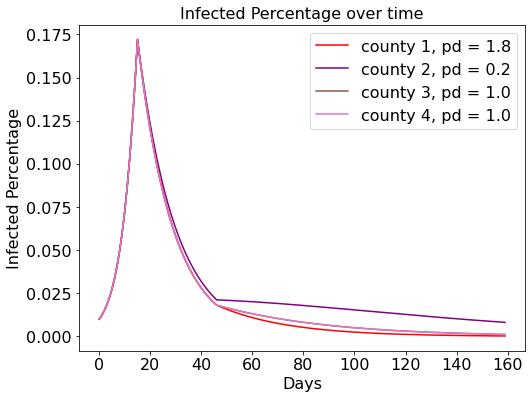

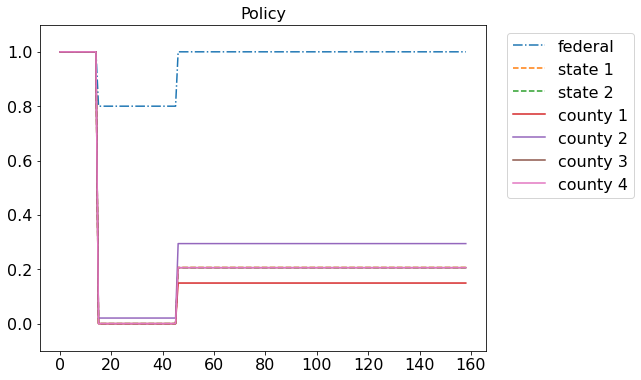

In [ ]:
plot_i(I,county_pop, county_area, T, figsize=(8,6))
show_all_policy(T, federal_policy_all, state_policy_all, county_policy_all)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1) )

Text(0.5, 1.0, 'State 2')

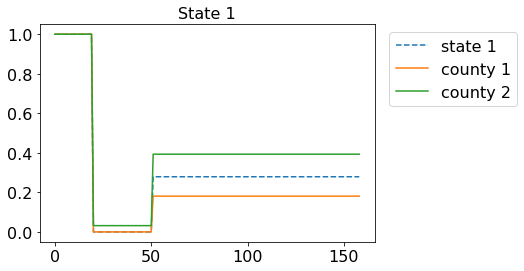

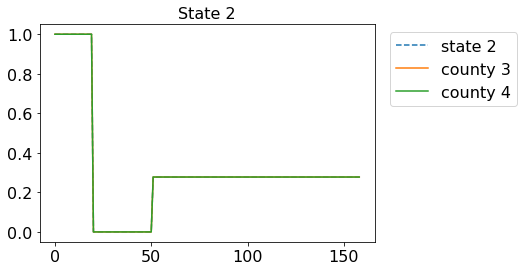

In [ ]:
plt.figure()
plt.plot([t for t in range(T-1)], [state_policy_all[t][0] for t in range(T-1)],label = 'state '+str(1), linestyle = 'dashed')
for i in range(2):
    plt.plot([t for t in range(T-1)],[county_policy_all[t][i] for t in range(T-1)], label = 'county '+str(i+1))

plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1) )
plt.title('State 1')

plt.figure()
plt.plot([t for t in range(T-1)], [state_policy_all[t][1] for t in range(T-1)],label = 'state '+str(2), linestyle = 'dashed')
for i in range(2,4):
    plt.plot([t for t in range(T-1)],[county_policy_all[t][i] for t in range(T-1)], label = 'county '+str(i+1))

plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1) )
plt.title('State 2')

In [ ]:
# Different state policy update function
county_pop = [900,100,500,500]
county_area = [500,500,500,500]
i0 = 0.01
T = 160
beta = 0.3
gamma = 0.07

policys = [0.2, 0.4, 0.6,0.8]
delta_ts = [30, 60, 90]
i_thresholds = [0.15,0.3,0.45,0.6,0.75]
costs = np.zeros((len(policys),len(delta_ts),len(i_thresholds)))

for i in range(len(policys)):
  for j in range(len(delta_ts)):
    for l in range(len(i_thresholds)):
      policy = policys[i]
      delta_t = delta_ts[j]
      i_threshold = i_thresholds[l]
      federal_policys = [1, policy, 1]


      S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_sir_seq_v2(beta, gamma, T,
                                                                                        federal_policys, i0, i_threshold = i_threshold,
                                                                                        delta_t =delta_t,
                                                                                        county_pop=county_pop,
                                                                                        county_area = county_area,
                                                                                        p1=1,p2=1,dt=1,
                                                                                        kappa=1/3,eta=1/3,two_sided=False)

      federal_cost = 0.4*(1 - policy)*(delta_t)/90 + 0.6*np.sum(np.max(I,axis=1))/sum(county_pop)
      costs[i][j][l] = federal_cost
      print('policy:',policys[i],'policy duration:', delta_ts[j], 'policy execuation threshold', i_thresholds[l], 'cost', costs[i][j][l])

t,s,k = np.unravel_index(np.argmin(costs, axis=None), costs.shape)
print('Best policy:')
print('policy:',policys[t],'policy duration:', delta_ts[s], 'policy execuation threshold', i_thresholds[k])

policy: 0.2 policy duration: 30 policy execuation threshold 0.15 cost 0.2169847175863208
policy: 0.2 policy duration: 30 policy execuation threshold 0.3 cost 0.303995767007939
policy: 0.2 policy duration: 30 policy execuation threshold 0.45 cost 0.3740068229773743
policy: 0.2 policy duration: 30 policy execuation threshold 0.6 cost 0.3740068229773743
policy: 0.2 policy duration: 30 policy execuation threshold 0.75 cost 0.3740068229773743
policy: 0.2 policy duration: 60 policy execuation threshold 0.15 cost 0.32365138425298745
policy: 0.2 policy duration: 60 policy execuation threshold 0.3 cost 0.4106624336746057
policy: 0.2 policy duration: 60 policy execuation threshold 0.45 cost 0.480673489644041
policy: 0.2 policy duration: 60 policy execuation threshold 0.6 cost 0.480673489644041
policy: 0.2 policy duration: 60 policy execuation threshold 0.75 cost 0.480673489644041
policy: 0.2 policy duration: 90 policy execuation threshold 0.15 cost 0.43031805091965414
policy: 0.2 policy duration

In [ ]:
federal_policys = [1, policys[t], 1]
S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_sir_seq_v2(beta, gamma, T,
                                                                                federal_policys, i0, i_threshold = i_thresholds[k],
                                                                                delta_t =delta_ts[s],
                                                                                county_pop=county_pop,
                                                                                county_area = county_area,
                                                                                p1=1,p2=1,dt=1,
                                                                                kappa=1/3,eta=1/3,two_sided=False)

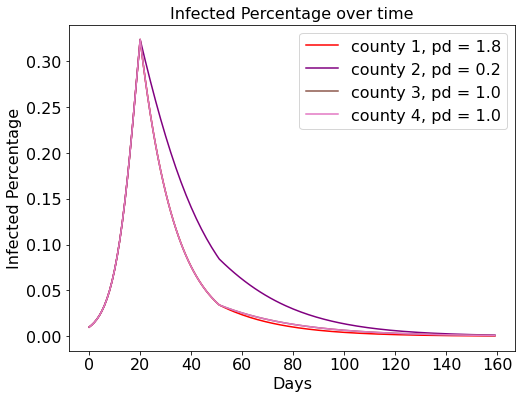

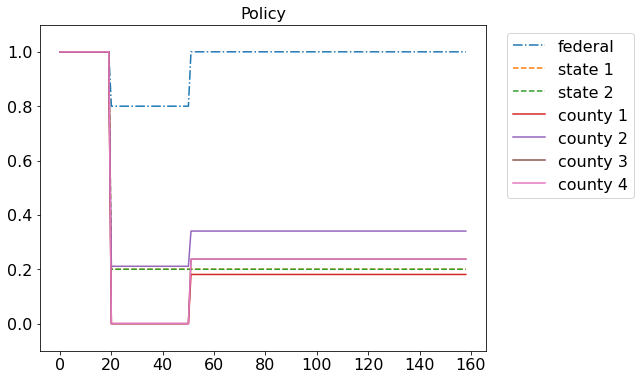

In [ ]:
plot_i(I,county_pop, county_area, T, figsize=(8,6))
show_all_policy(T, federal_policy_all, state_policy_all, county_policy_all)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1) )

Text(0.5, 1.0, 'State 2')

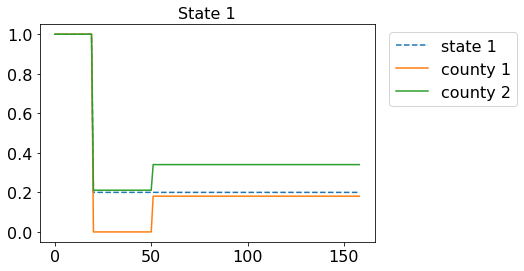

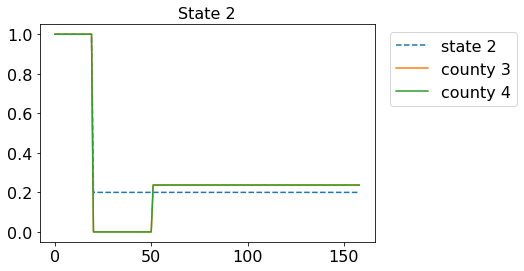

In [ ]:
plt.figure()
plt.plot([t for t in range(T-1)], [state_policy_all[t][0] for t in range(T-1)],label = 'state '+str(1), linestyle = 'dashed')
for i in range(2):
    plt.plot([t for t in range(T-1)],[county_policy_all[t][i] for t in range(T-1)], label = 'county '+str(i+1))

plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1) )
plt.title('State 1')

plt.figure()
plt.plot([t for t in range(T-1)], [state_policy_all[t][1] for t in range(T-1)],label = 'state '+str(2), linestyle = 'dashed')
for i in range(2,4):
    plt.plot([t for t in range(T-1)],[county_policy_all[t][i] for t in range(T-1)], label = 'county '+str(i+1))

plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1) )
plt.title('State 2')

# California top 10 counties

## Pareto

In [ ]:
# use r_inft and constant policy,pareto
federal_policys = [1, 0.2, 1]
threshold = [0.3,0.6]
n_gen = 100
pop_size = 150
ts = 20
te = 60
i0 = 0.01
T = 160
# beta = 0.5
# gamma = .07
beta = 0.3
gamma = 0.07
# county_pop = [900,100,500,500]
# county_area = [475,475,475,475]
# from USA.COM
county_name = ['SF', 'Orange', 'LA', 'Alameda', 'Sacramento',
               'SantaClara', 'ContraCosta', 'SanMateo', 'SD', 'SanJoaquin']
county_pop = [357.5, 325.5, 209.9, 189.8, 145.9,
              142.2, 134.5, 99.85, 70.34, 49.14]
county_pop = [x*3 for x in county_pop]
county_area = [300]*10
pop_size = 1000
S,I,R, county_policy_all, state_policy_all,federal_policy_all, X_t1, X_t2, obj_t1, obj_t2,res_t1,res_t2 = single_state_pareto(beta, gamma, T,
                                                                                                                federal_policys, i0,
                                                                                                                county_pop = county_pop,
                                                                                                                county_area = county_area,
                                                                                                                dt = 1, p1=1,p2=1,
                                                                                                                kappa=1/3,eta=1/3,
                                                                                                                two_sided=True,
                                                                                                                n_gen = 200,
                                                                                                                pop_size = pop_size)


Number of Pareto optimals: 1000


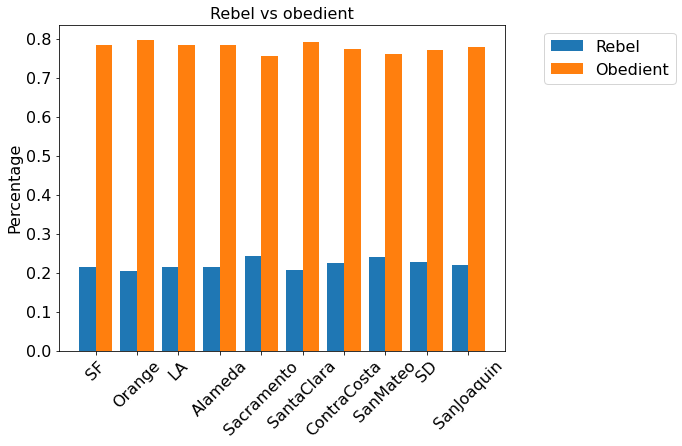

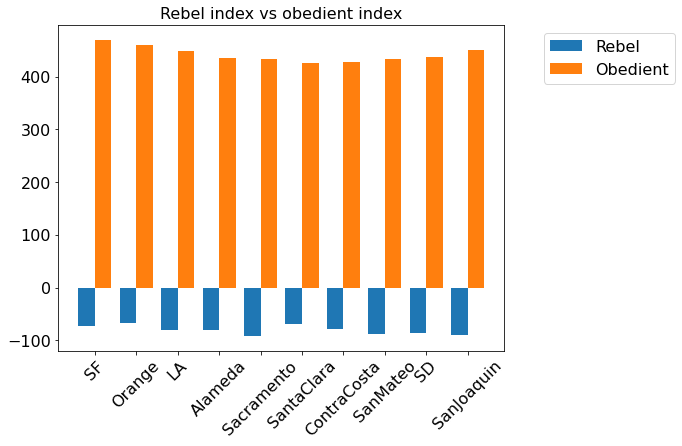

In [ ]:
_,_ = solution_set_stats(X_t1,county_name)

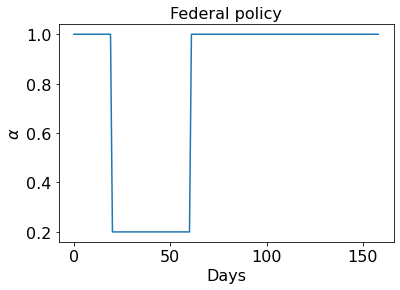

In [ ]:
# print(federal_policy_all)
show_policy(T,federal_policy_all,title = 'Federal policy')

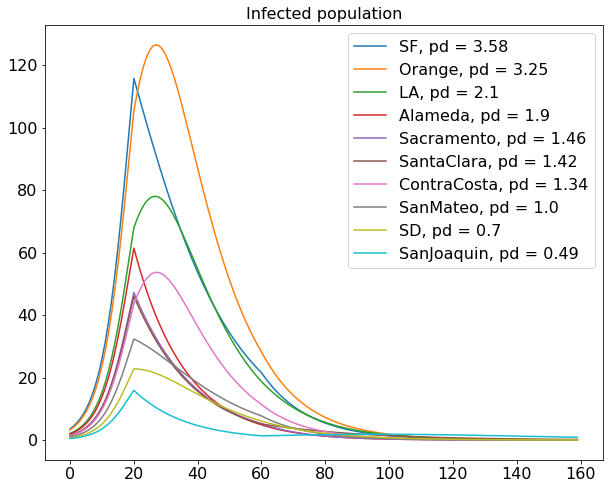

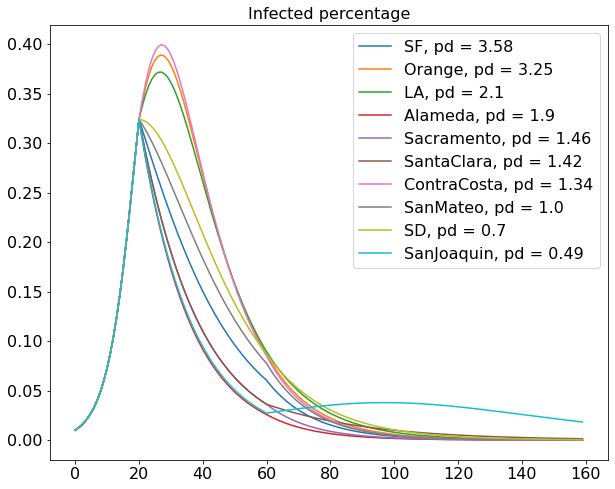

In [ ]:
# plot_i(county_pop, county_area, T, figsize=(6,4))

# plt.figure(figsize=(6,4))
# county_color = ['red','purple','tab:brown','tab:pink']
plt.figure(figsize=(10,8))
for i in range(10):
  plt.plot([t for t in range(T)], [x for x in I[i]], label = county_name[i] +', pd = '+ str(round(county_pop[i]/county_area[i],2)))

plt.title('Infected population')
plt.legend()

plt.figure(figsize=(10,8))
for i in range(10):
  plt.plot([t for t in range(T)], [x/county_pop[i] for x in I[i]], label = county_name[i] +', pd = '+ str(round(county_pop[i]/county_area[i],2)))

plt.title('Infected percentage')
plt.legend()

# show_all_policy(T, federal_policy_all, state_policy_all, county_policy_all)
# plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1) )

## Sequential model

In [ ]:
federal_policys = [1, 0.2, 1]

i0 = 0.01
T = 160

beta = 0.3
gamma = 0.07
county_name = ['SF', 'Orange', 'LA', 'Alameda', 'Sacramento',
               'SantaClara', 'ContraCosta', 'SanMateo', 'SD', 'SanJoaquin']
county_pop = [357.5, 325.5, 209.9, 189.8, 145.9,
              142.2, 134.5, 99.85, 70.34, 49.14]
# county_pop = [357.5, 325.5, 209.9, 189.8, 145.9]
county_pop = [x*3 for x in county_pop]
n_county = len(county_pop)
county_area = [300]*n_county

K = np.zeros((n_county,n_county))
np.fill_diagonal(K, 1)
kappa_county = [1/3]*(n_county+1)
eta_county =[1/3]*(n_county+1)
S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                            federal_policys, i0,
                                                                            i_threshold = 0.1,
                                                                            delta_t = 60,
                                                                            county_pop=county_pop,
                                                                            county_area = county_area,
                                                                            p1=1,p2=1,dt=1,
                                                                            kappa=1/3,eta=1/3,
                                                                            K = K,
                                                                            kappa_county = kappa_county,
                                                                            eta_county = eta_county,
                                                                            two_sided=False)


Excitation matrix: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Federal policy released
state 0 policy at day 12: 5.68294343477252e-06


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


County update every 10 days:
[3.86558424e-06 3.92243607e-06 4.21934838e-06 4.24814328e-06
 4.05393403e-06 4.29107140e-06 4.22396032e-06 4.18707134e-06
 5.86167676e-06 9.67106950e-03]
County update every 10 days:
[4.25037339e-06 4.59423676e-06 4.92133781e-06 5.39087614e-06
 4.31818225e-06 4.02852378e-06 3.09016289e-04 9.64059218e-03
 2.00510140e-02 3.21724647e-02]
County update every 10 days:
[4.07061840e-06 3.89557886e-06 9.57780391e-03 1.46261334e-02
 1.99716183e-02 2.00087613e-02 2.58081284e-02 3.21395395e-02
 3.90199564e-02 4.68383337e-02]
County update every 10 days:
[0.01457106 0.01996527 0.0320896  0.03209348 0.03902854 0.03899953
 0.03900443 0.04674172 0.04679332 0.04683833]
County update every 10 days:
[0.03205173 0.03897519 0.04672399 0.04672444 0.04673889 0.04672153
 0.04672428 0.04674172 0.05556124 0.05556124]
County update every 10 days:
[0.04670811 0.04670984 0.04672399 0.05556124 0.05556124 0.05556124
 0.05556124 0.05556124 0.05556124 0.05556124]
No Federal intervention.


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Policy')

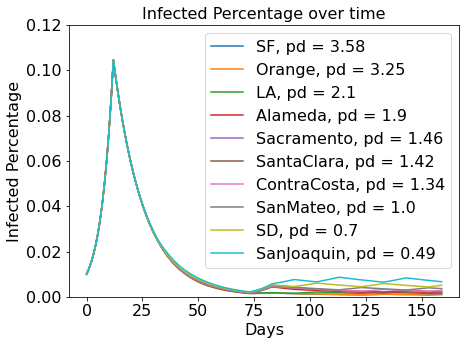

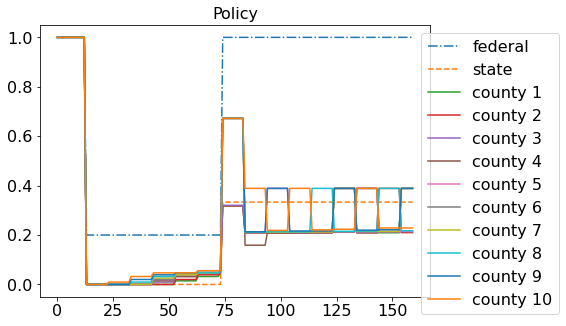

In [ ]:
plot_i(I, county_pop, county_area, T, figsize=(7,5),ylimit=(0,0.12),county_name=county_name)
plt.figure(figsize = (7,5))
# print(county_policy_all.shape)
plt.plot([t for t in range(T)],federal_policy_all, label = 'federal', color=FEDERAL_COLOR,linestyle = 'dashdot')
plt.plot([t for t in range(T)], state_policy_all,label = 'state', color=state_color,linestyle = 'dashed')
for i in range(len(county_policy_all[0])):
  plt.plot([t for t in range(T)],county_policy_all[:,i], color=county_color[i],label = 'county '+str(i+1))
  plt.legend(bbox_to_anchor=(1.35, 1))
plt.title('Policy')

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

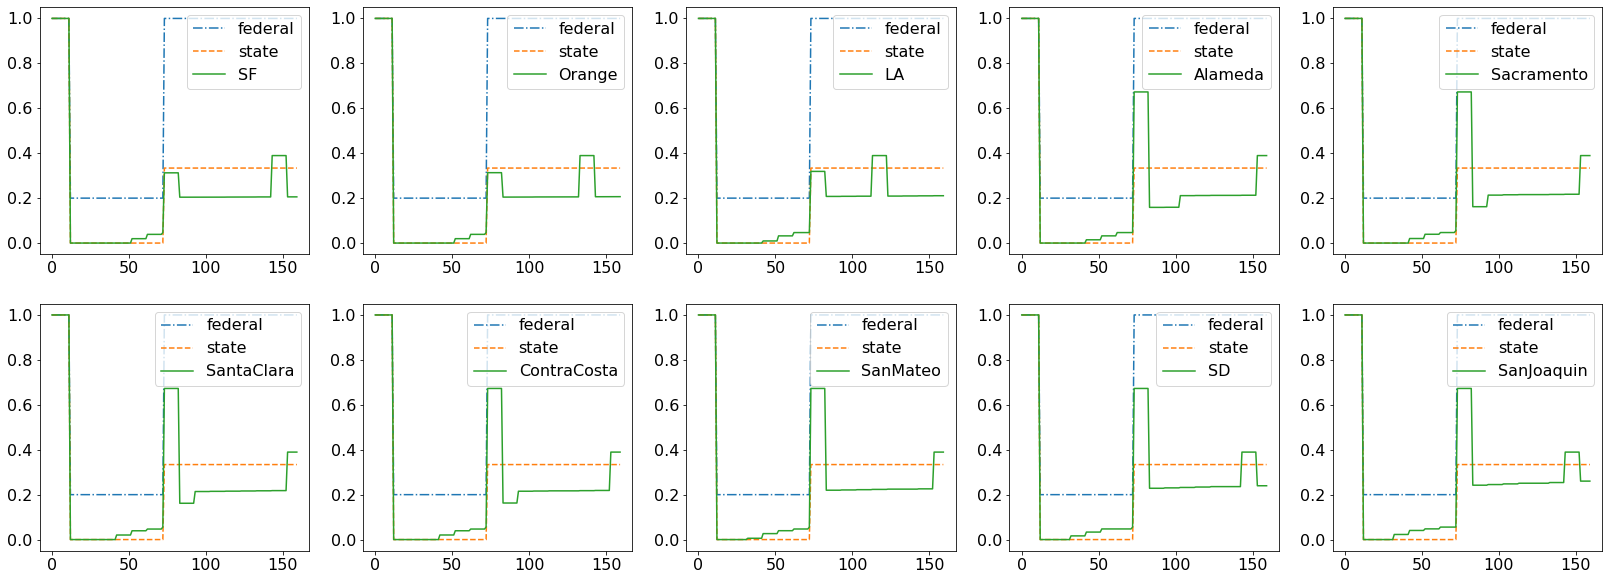

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(28, 10))
i = 0
for ax in axs.ravel():
  ax.plot([t for t in range(T)],federal_policy_all, label = 'federal', linestyle = 'dashdot')
  ax.plot([t for t in range(T)], state_policy_all,label = 'state', linestyle = 'dashed')
  ax.plot([t for t in range(T)],county_policy_all[:,i], label = county_name[i])
  ax.legend(loc='upper right')
  i +=1

In [ ]:
# with some degree of cross excitation
federal_policys = [1, 0.2, 1]

i0 = 0.01
T = 160

beta = 0.3
gamma = 0.07
county_name = ['SF', 'Orange', 'LA', 'Alameda', 'Sacramento',
               'SantaClara', 'ContraCosta', 'SanMateo', 'SD', 'SanJoaquin']
county_pop = [357.5, 325.5, 209.9, 189.8, 145.9,
              142.2, 134.5, 99.85, 70.34, 49.14]
# county_pop = [357.5, 325.5, 209.9, 189.8, 145.9]
county_pop = [x*3 for x in county_pop]
n_county = len(county_pop)
county_area = [300]*n_county

K = 0.01*np.ones((n_county,n_county))
np.fill_diagonal(K, 1)
kappa_county = [1/3]*(n_county+1)
eta_county =[1/3]*(n_county+1)
S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                            federal_policys, i0,
                                                                            i_threshold = 0.1,
                                                                            delta_t = 60,
                                                                            county_pop=county_pop,
                                                                            county_area = county_area,
                                                                            p1=1,p2=1,dt=1,
                                                                            kappa=1/3,eta=1/3,
                                                                            K = K,
                                                                            kappa_county = kappa_county,
                                                                            eta_county = eta_county,
                                                                            two_sided=False)


Excitation matrix: [[1.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 1.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 1.   0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 1.   0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 1.   0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 1.   0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 1.   0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 1.   0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 1.   0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 1.  ]]
Federal policy released
state 0 policy at day 11: 5.9608609865491405e-06


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


County update every 10 days:
[5.00152575e-06 4.86204404e-06 4.26737220e-06 3.83017128e-06
 3.45560206e-06 6.46760458e-06 6.32984663e-06 5.15970322e-06
 3.84044947e-06 6.31902531e-06]
County update every 10 days:
[5.35124969e-06 5.32561012e-06 5.04189123e-06 4.82173771e-06
 4.74009794e-06 4.23105525e-06 6.62469802e-06 5.78152538e-03
 1.64143075e-02 2.27178562e-02]
County update every 10 days:
[4.44465880e-06 6.20906739e-06 9.37559013e-03 1.45556425e-02
 2.02284918e-02 2.02725105e-02 2.03896615e-02 2.65396991e-02
 3.33566273e-02 4.05680041e-02]
County update every 10 days:
[0.01950945 0.01954627 0.03199827 0.03204307 0.03913086 0.03915689
 0.03922613 0.03948273 0.0472927  0.04763674]
County update every 10 days:
[0.03870128 0.03872365 0.04668194 0.0467247  0.04683024 0.04684642
 0.04685627 0.0470504  0.0472927  0.05556152]
County update every 10 days:
[0.04654668 0.04655983 0.04668194 0.0467247  0.05556152 0.05556152
 0.05556152 0.05556152 0.05556152 0.05556152]
No Federal intervention.


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Policy')

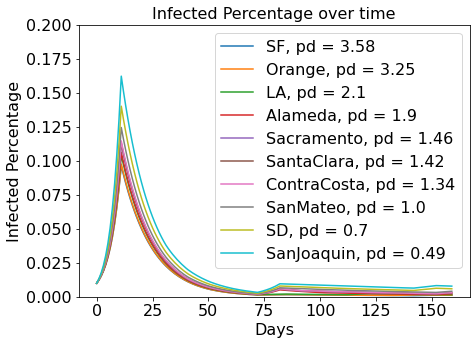

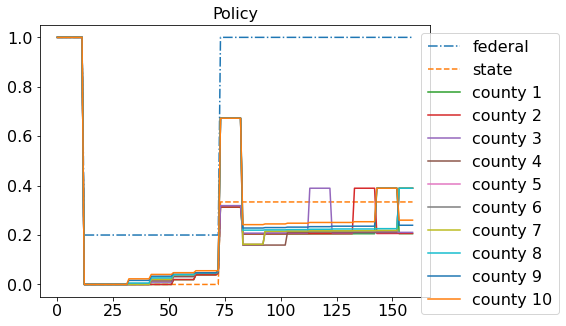

In [ ]:
plot_i(I, county_pop, county_area, T, figsize=(7,5),ylimit=(0,0.2),county_name=county_name)
plt.figure(figsize = (7,5))
# print(county_policy_all.shape)
plt.plot([t for t in range(T)],federal_policy_all, label = 'federal', color=FEDERAL_COLOR,linestyle = 'dashdot')
plt.plot([t for t in range(T)], state_policy_all,label = 'state', color=state_color,linestyle = 'dashed')
for i in range(len(county_policy_all[0])):
  plt.plot([t for t in range(T)],county_policy_all[:,i], color=county_color[i],label = 'county '+str(i+1))
  plt.legend(bbox_to_anchor=(1.35, 1))
plt.title('Policy')

# print(county_policy_all.shape)

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

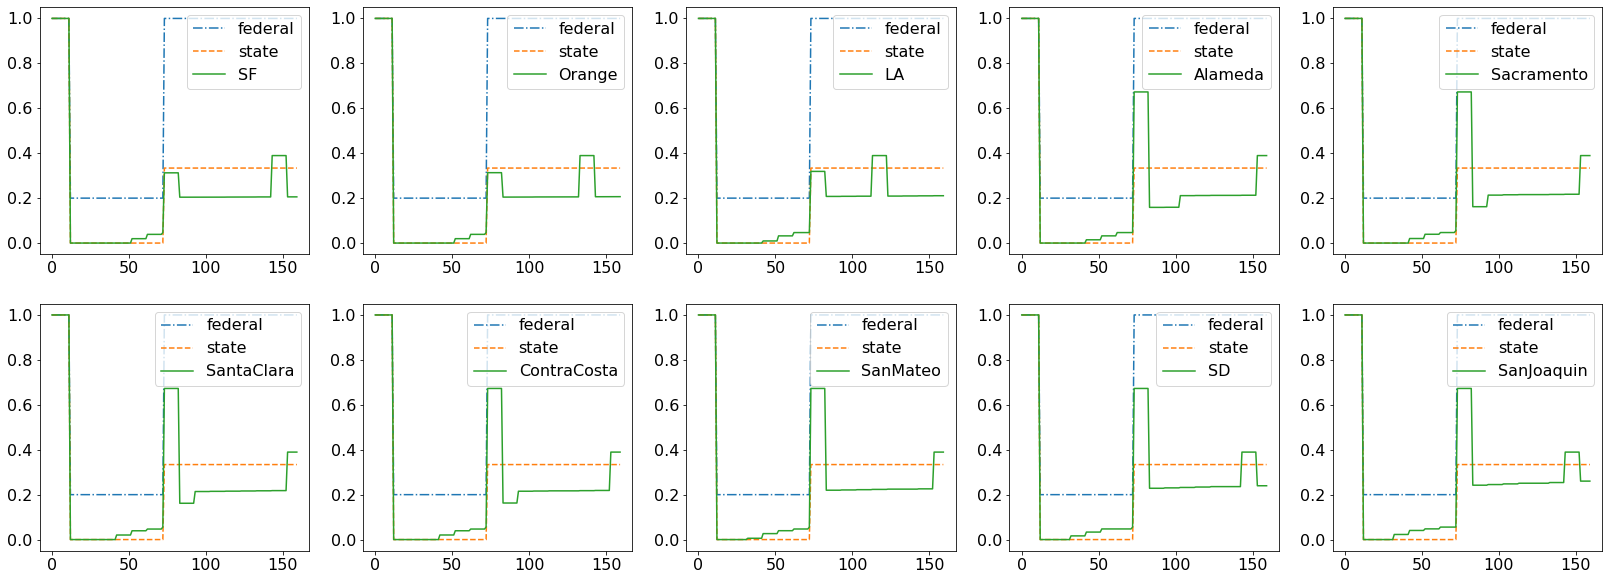

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(28, 10))
i = 0
for ax in axs.ravel():
  ax.plot([t for t in range(T)],federal_policy_all, label = 'federal', linestyle = 'dashdot')
  ax.plot([t for t in range(T)], state_policy_all,label = 'state', linestyle = 'dashed')
  ax.plot([t for t in range(T)],county_policy_all[:,i], label = county_name[i])
  ax.legend(loc='upper right')
  i +=1

## LA & OC

In [ ]:
# with some degree of cross excitation
federal_policys = [1, 0.2, 1]

i0 = 0.01
T = 160

beta = 0.3
gamma = 0.07
county_name = ['SF', 'Orange', 'LA', 'Alameda', 'Sacramento',
               'SantaClara', 'ContraCosta', 'SanMateo', 'SD', 'SanJoaquin']
# county_pop = [357.5, 325.5, 209.9, 189.8, 145.9,
#               142.2, 134.5, 99.85, 70.34, 49.14]
county_pop = [357.5, 325.5, 209.9]
county_pop = [x*3 for x in county_pop]
n_county = len(county_pop)
county_area = [300]*n_county

K = 0.01*np.ones((n_county,n_county))
np.fill_diagonal(K, 1)
kappa_county = [1/3]*(n_county+1)
eta_county =[1/3]*(n_county+1)
S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                            federal_policys, i0,
                                                                            i_threshold = 0.1,
                                                                            delta_t = 60,
                                                                            county_pop=county_pop,
                                                                            county_area = county_area,
                                                                            p1=1,p2=1,dt=1,
                                                                            kappa=1/3,eta=1/3,
                                                                            K = K,
                                                                            kappa_county = kappa_county,
                                                                            eta_county = eta_county,
                                                                            two_sided=False)

Excitation matrix: [[1.   0.01 0.01]
 [0.01 1.   0.01]
 [0.01 0.01 1.  ]]
Federal policy released
state 0 policy at day 12: 5.9608609865491405e-06
County update every 10 days:


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[6.63920576e-06 6.63806329e-06 6.25274650e-06]
County update every 10 days:
[3.73969777e-06 3.61589692e-06 4.11149150e-06]
County update every 10 days:
[3.83333663e-06 6.30921189e-06 5.24739198e-03]
County update every 10 days:
[0.01475931 0.02019545 0.03236487]
County update every 10 days:
[0.03221325 0.03223332 0.03924828]
County update every 10 days:
[0.04678275 0.04679178 0.04687189]
No Federal intervention.
state 0 policy at day 73: 0.3057816250154257
County update every 10 days:
[0.20952891 0.2098299  0.21231432]
County update every 10 days:
[0.20983276 0.21016452 0.21231432]
County update every 10 days:
[0.21013735 0.21050003 0.36133718]
County update every 10 days:
[0.21044267 0.21083644 0.21337682]
County update every 10 days:
[0.36133718 0.36133718 0.21391141]
County update every 10 days:
[0.21074874 0.21117375 0.36133718]
County update every 10 days:
[0.21105555 0.21151196 0.21444823]
County update every 10 days:
[0.36133718 0.36133718 0.36133718]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/content/drive/MyDrive/Research/PolicySIR/figure/I_cali.eps


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


/content/drive/MyDrive/Research/PolicySIR/figure/policy_cali.pdf


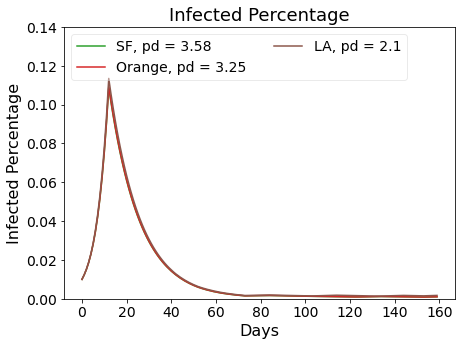

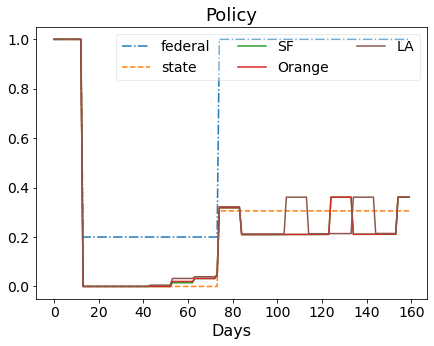

In [ ]:
plot_i(I, county_pop, county_area, T, figsize=(7,5),
       ylimit=(0,0.14),county_name=county_name,ncol=2)
new_path = os.path.join(PATH,"I_cali.eps")
print(new_path)
plt.savefig(new_path,figsize=(7,5))

plt.figure(figsize = (7,5))
# print(county_policy_all.shape)
plt.plot([t for t in range(T)],federal_policy_all, label = 'federal', color=FEDERAL_COLOR,linestyle = 'dashdot')
plt.plot([t for t in range(T)], state_policy_all,label = 'state', color=state_color,linestyle = 'dashed')
for i in range(len(county_policy_all[0])):
  plt.plot([t for t in range(T)],county_policy_all[:,i], label = county_name[i],color=county_color[i])
  # plt.legend(bbox_to_anchor=(1.35, 1))
  plt.legend(loc='upper right',ncol = 3,framealpha=0.4)
plt.title('Policy',fontsize=BIGGER_SIZE)
plt.xlabel('Days')
new_path = os.path.join(PATH,"policy_cali.pdf")
print(new_path)
plt.savefig(new_path,figsize=(7,5))

In [ ]:
# with some degree of cross excitation
federal_policys = [1, 0.2, 1]

i0 = 0.01
T = 160

beta = 0.3
gamma = 0.07
county_name = ['SF', 'Orange', 'LA', 'Alameda', 'Sacramento',
               'SantaClara', 'ContraCosta', 'SanMateo', 'SD', 'SanJoaquin']
# county_pop = [357.5, 325.5, 209.9, 189.8, 145.9,
#               142.2, 134.5, 99.85, 70.34, 49.14]
county_pop = [357.5, 325.5, 209.9]
county_pop = [x*3 for x in county_pop]
n_county = len(county_pop)
county_area = [300]*n_county

K = 0.01*np.ones((n_county,n_county))
np.fill_diagonal(K, 1)
kappa_county = [1/3]*(n_county+1)
eta_county =[1/3]*(n_county+1)
kappa_county[1] = 9/10
eta_county[1] = 1/20
S,I,R, county_policy_all, state_policy_all,federal_policy_all = policy_game(beta, gamma, T,
                                                                            federal_policys, i0,
                                                                            i_threshold = 0.1,
                                                                            delta_t = 60,
                                                                            county_pop=county_pop,
                                                                            county_area = county_area,
                                                                            p1=1,p2=1,dt=1,
                                                                            kappa=1/3,eta=1/3,
                                                                            K = K,
                                                                            kappa_county = kappa_county,
                                                                            eta_county = eta_county,
                                                                            two_sided=False)


Excitation matrix: [[1.   0.01 0.01]
 [0.01 1.   0.01]
 [0.01 0.01 1.  ]]
Federal policy released
state 0 policy at day 12: 5.9608609865491405e-06
County update every 10 days:
[6.63920576e-06 1.10897863e-01 6.25274650e-06]
County update every 10 days:


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[3.73969777e-06 1.52348847e-01 4.11149150e-06]
County update every 10 days:
[3.83333663e-06 1.83956643e-01 5.24739198e-03]
County update every 10 days:
[0.01475931 0.20514392 0.03236487]
County update every 10 days:
[0.03221325 0.22607484 0.03924828]
County update every 10 days:
[0.04678275 0.24238428 0.04687189]
No Federal intervention.
state 0 policy at day 73: 0.22460352677029108
County update every 10 days:
[0.15845491 0.17234061 0.21231395]
County update every 10 days:
[0.20983166 0.22122486 0.21284413]
County update every 10 days:
[0.21044169 0.25603746 0.21337653]
County update every 10 days:
[0.21074782 0.28482201 0.21391114]
County update every 10 days:
[0.21105468 0.3070113  0.21444799]
County update every 10 days:
[0.21136229 0.32731792 0.21498707]
County update every 10 days:
[0.21167065 0.34479917 0.21552805]
County update every 10 days:
[0.21167065 0.36279265 0.21607132]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


/content/drive/MyDrive/Research/PolicySIR/figure/policy_cali_re.pdf


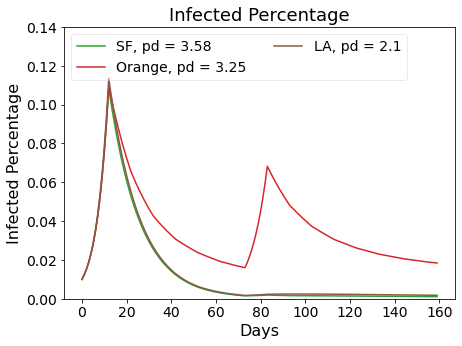

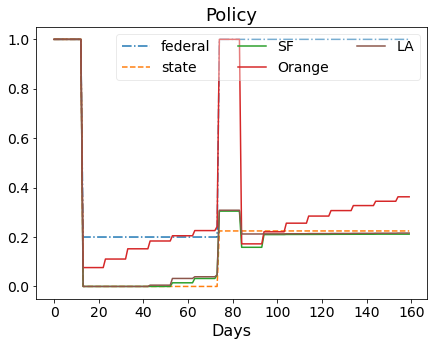

In [ ]:
plot_i(I, county_pop, county_area, T, figsize=(7,5),
       ylimit=(0,0.14),county_name=county_name,ncol=2)
new_path = os.path.join(PATH,"I_cali_re.eps")
plt.savefig(new_path,figsize=(7,5))

plt.figure(figsize = (7,5))
# print(county_policy_all.shape)
plt.plot([t for t in range(T)],federal_policy_all, label = 'federal', color=FEDERAL_COLOR,linestyle = 'dashdot')
plt.plot([t for t in range(T)], state_policy_all,label = 'state', color=state_color,linestyle = 'dashed')
for i in range(len(county_policy_all[0])):
  plt.plot([t for t in range(T)],county_policy_all[:,i], label = county_name[i],color=county_color[i])
  # plt.legend(bbox_to_anchor=(1.35, 1))
  plt.legend(loc='upper right',ncol = 3,framealpha=0.4)
plt.title('Policy',fontsize=BIGGER_SIZE)
plt.xlabel('Days')
new_path = os.path.join(PATH,"policy_cali_re.pdf")
print(new_path)
plt.savefig(new_path,figsize=(7,5))

# stay-at-home order, real data

In [ ]:
path = '/content/drive/MyDrive/Research/PolicySIR/U.S._State_and_Territorial_Stay-At-Home_Orders__March_15__2020___August_15__2021_by_County_by_Day.csv'
df_policy= pd.read_csv(path)

time: 5.27 s (started: 2022-08-31 22:12:45 +00:00)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# df_policy.head()

time: 423 µs (started: 2022-08-31 22:12:50 +00:00)


In [ ]:
# preprocess df
print(df_policy['Order_code'].unique())
print(df_policy['Stay_at_Home_Order_Recommendation'].unique())
print(df_policy['Source_of_Action'].unique())
# print(df_policy['Citation'].unique())
# change 'Stay_at_Home_Order_Recommendation' to numerical values
order_dict = {
              'Mandatory for all individuals':0,
              'Mandatory only for all individuals in certain areas of the jurisdiction':0.2,
              'Mandatory only for at-risk individuals in the jurisdiction':0.4,
              'Mandatory only for at-risk individuals in certain areas of the jurisdiction':0.6,
              'Advisory/Recommendation':0.8,
              'No order for individuals to stay home':1
              }
df_policy = df_policy.replace({'Stay_at_Home_Order_Recommendation': order_dict})
df_policy['date'] = pd.to_datetime(df_policy['date'],format='%m/%d/%Y')
# fill NaN with 5, no order
df_policy['Stay_at_Home_Order_Recommendation'] = df_policy['Stay_at_Home_Order_Recommendation'].fillna(1)

[7 1 6 2 3 5]
[nan 'Mandatory for all individuals' 'Advisory/Recommendation'
 'No order for individuals to stay home'
 'Mandatory only for all individuals in certain areas of the jurisdiction'
 'Mandatory only for at-risk individuals in the jurisdiction'
 'Mandatory only for at-risk individuals in certain areas of the jurisdiction']
[nan 'Official' 'Press Release' 'Off' 'News Media' 'Judicial Ruling'
 'official']
time: 823 ms (started: 2022-08-31 22:12:50 +00:00)


In [ ]:
df_policy

State_Tribe_Territory        County_Name  FIPS_State  FIPS_County  \
0                          AL     Autauga County           1            1   
1                          AL     Autauga County           1            1   
2                          AL     Autauga County           1            1   
3                          AL     Autauga County           1            1   
4                          AL     Autauga County           1            1   
...                       ...                ...         ...          ...   
1677922                    VI  St. Thomas Island          78           30   
1677923                    VI  St. Thomas Island          78           30   
1677924                    VI  St. Thomas Island          78           30   
1677925                    VI  St. Thomas Island          78           30   
1677926                    VI  St. Thomas Island          78           30   

              date  Order_code  Stay_at_Home_Order_Recommendation  \
0       2020-03-15           7                                1.0   
1       2020-03-16           7                                1.0   
2       2020-03-17           7                                1.0   
3       2020-03-18           7                                1.0   
4       2020-03-19           7                                1.0   
...            ...         ...                                ...   
1677922 2021-08-11           6                                0.8   
1677923 2021-08-12           6                                0.8   
1677924 2021-08-13           6                                0.8   
1677925 2021-08-14           6                                0.8   
1677926 2021-08-15           6                                0.8   

        Express_Preemption Source_of_Action  \
0                      NaN              NaN   
1                      NaN              NaN   
2                      NaN              NaN   
3                      NaN              NaN   
4                      NaN              NaN   
...                    ...              ...   
1677922            Unknown         Official   
1677923            Unknown         Official   
1677924            Unknown         Official   
1677925            Unknown         Official   
1677926            Unknown         Official   

                                                       URL  \
0                                                      NaN   
1                                                      NaN   
2                                                      NaN   
3                                                      NaN   
4                                                      NaN   
...                                                    ...   
1677922  https://www.vi.gov/wp-content/uploads/2020/08/...   
1677923  https://www.vi.gov/wp-content/uploads/2020/08/...   
1677924  https://www.vi.gov/wp-content/uploads/2020/08/...   
1677925  https://www.vi.gov/wp-content/uploads/2020/08/...   
1677926  https://www.vi.gov/wp-content/uploads/2020/08/...   

                                                 Citation  
0                                                     NaN  
1                                                     NaN  
2                                                     NaN  
3                                                     NaN  
4                                                     NaN  
...                                                   ...  
1677922  V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)  
1677923  V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)  
1677924  V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)  
1677925  V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)  
1677926  V.I. Sixteenth Supp. Exec. Order (Sept. 8, 2020)  

[1677927 rows x 11 columns]

time: 15.8 ms (started: 2022-08-31 22:12:51 +00:00)


In [ ]:
def plot_real_policy(df_policy, county, state, plot=True,start_date=None, end_date=None,save=False):
  df_county = df_policy[(df_policy['County_Name'] == county) & (df_policy['State_Tribe_Territory'] == state)]
  df_county = df_county.sort_values(by='date')
  # print(df_county.head())
  if start_date and end_date:
      df_county = df_county[(df_county['date'] >= start_date) & (df_county['date'] <= end_date)]
  if plot:
    fig, ax = plt.subplots(figsize=(7, 5))
    # at = AnchoredText('0: Mandatory for all individuals\n1:Mandatory only for all individuals in certain areas of the jurisdiction', prop=dict(size=15), frameon=True, loc='upper left')
    # at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax.add_artist(at)
    # print(df_county['date'])

    # print(df_county.head())
    plt.plot(df_county['date'], df_county['Stay_at_Home_Order_Recommendation'],label=county)
    # plt.ylim((0,6))
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
    plt.xticks(rotation = 30,fontsize=12)
    plt.title('Stay-at-home policy',fontsize=BIGGER_SIZE)
    plt.legend()
    if save:
      new_path = os.path.join(PATH,"policy_cali_real.eps")
      print(new_path)
    #   plt.savefig(new_path,figsize=(7,5))
  return df_county

time: 2.75 ms (started: 2022-08-31 22:12:51 +00:00)


In [ ]:
# df_policy.head()

time: 1.26 ms (started: 2022-07-11 23:54:15 +00:00)


In [ ]:
df_ca = df_policy[df_policy['State_Tribe_Territory'] == 'CA']
df_ca['date'] = pd.to_datetime(df_ca['date'],format='%m/%d/%Y')
# print(df_ca['County_Name'].unique())

time: 160 ms (started: 2022-08-31 22:12:51 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# plot LA county
df_la = df_ca[df_ca['County_Name'] == 'Los Angeles County']
# df_la=df_la.replace({'Stay_at_Home_Order_Recommendation': order_dict})
df_sf = df_ca[df_ca['County_Name'] == 'San Francisco County']
# df_sf=df_sf.replace({'Stay_at_Home_Order_Recommendation': order_dict})
df_oc = df_ca[df_ca['County_Name'] == 'Orange County']
# df_oc=df_oc.replace({'Stay_at_Home_Order_Recommendation': order_dict})

time: 20.6 ms (started: 2022-08-31 22:12:52 +00:00)


In [ ]:
# df_ca[df_ca['County_Name'] == 'San Francisco County']
# df_ca[(df_ca['date'] > '2020-03-11') & (df_ca['date'] < '2020-4-11')&(df_ca['County_Name']=='San Francisco County')]

time: 1.39 ms (started: 2022-08-11 15:50:04 +00:00)


In [ ]:
# df_sf[(df_sf['date'] > '2020-11-11') & (df_sf['date'] < '2020-12-2')]

time: 814 µs (started: 2022-08-11 15:50:05 +00:00)


In [ ]:
# df_la['Stay_at_Home_Order_Recommendation'] = df_la['Stay_at_Home_Order_Recommendation'].fillna(1)
# df_oc['Stay_at_Home_Order_Recommendation'] = df_oc['Stay_at_Home_Order_Recommendation'].fillna(1)
# df_sf['Stay_at_Home_Order_Recommendation'] = df_sf['Stay_at_Home_Order_Recommendation'].fillna(1)

time: 16.9 ms (started: 2022-08-11 15:50:06 +00:00)


In [ ]:
for order in order_dict:
  print(order,order_dict[order])
  # print()

Mandatory for all individuals 0
Mandatory only for all individuals in certain areas of the jurisdiction 0.2
Mandatory only for at-risk individuals in the jurisdiction 0.4
Mandatory only for at-risk individuals in certain areas of the jurisdiction 0.6
Advisory/Recommendation 0.8
No order for individuals to stay home 1
time: 4.5 ms (started: 2022-08-31 22:12:56 +00:00)


/content/drive/MyDrive/Research/PolicySIR/figure/policy_cali_real.eps


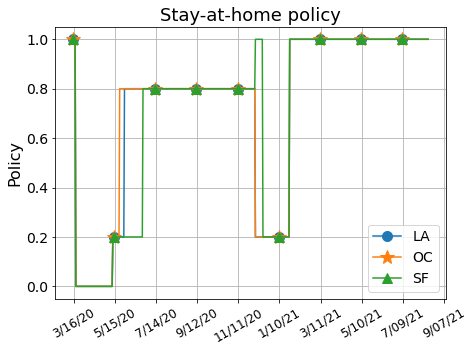

time: 754 ms (started: 2022-08-31 22:14:33 +00:00)


In [ ]:
df_oc = df_oc.sort_values(by='date')
df_sf = df_sf.sort_values(by='date')
df_la = df_la.sort_values(by='date')
from matplotlib.offsetbox import AnchoredText
fig, ax = plt.subplots(figsize=(7, 5))
# at = AnchoredText('0: Mandatory for all individuals\n1:Mandatory only for all individuals in certain areas of the jurisdiction', prop=dict(size=15), frameon=True, loc='upper left')
# at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# ax.add_artist(at)
plt.plot(df_la['date'], df_la['Stay_at_Home_Order_Recommendation'],label='LA',marker="o",markevery=60,markersize=10)
plt.plot(df_oc['date'], df_oc['Stay_at_Home_Order_Recommendation'],label='OC',marker="*",markevery=60,markersize=15)
plt.plot(df_sf['date'], df_sf['Stay_at_Home_Order_Recommendation'],label='SF',marker="^",markevery=60,markersize=10)
# plt.ylim((0,6))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
plt.xticks(rotation = 30,fontsize=12)
plt.title('Stay-at-home policy',fontsize=BIGGER_SIZE)
plt.legend()
plt.ylabel('Policy')
# plt.xlabel('Time (days)')
ax.grid()
new_path = os.path.join(PATH,"policy_cali_real.eps")
print(new_path)
plt.savefig(new_path,figsize=(7,5))

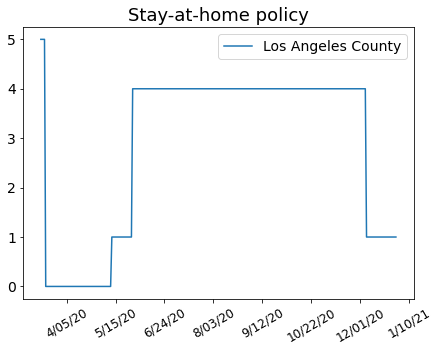

time: 707 ms (started: 2022-07-07 04:58:38 +00:00)


In [ ]:
start_date = '3/15/2020'
end_date = '12/30/2020'
df_la = plot_real_policy(df_policy, 'Los Angeles County', 'CA',plot=True, start_date=start_date, end_date=end_date,save=False)
# print(df_la.iloc[-1,:])

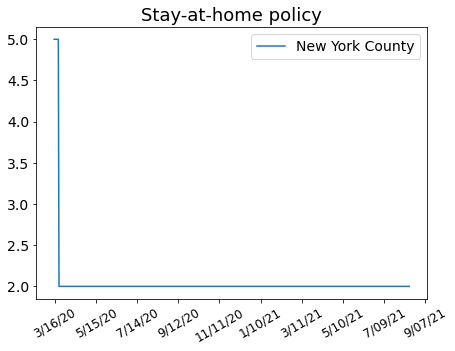

time: 426 ms (started: 2022-06-22 17:29:53 +00:00)


In [ ]:
plot_real_policy(df_policy, 'New York County', 'NY', start_date=None, end_date=None,save=False)

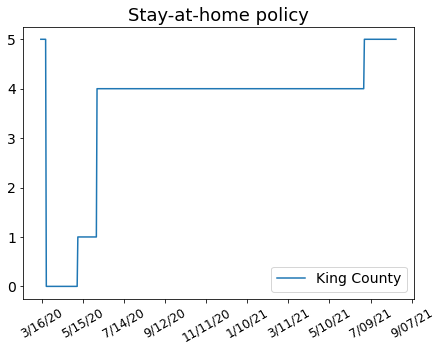

time: 494 ms (started: 2022-06-22 17:31:38 +00:00)


In [ ]:
plot_real_policy(df_policy, 'King County', 'WA', start_date=None, end_date=None,save=False)

In [ ]:
policy_la = df_la['Stay_at_Home_Order_Recommendation']

time: 4.76 ms (started: 2022-06-27 22:26:30 +00:00)


In [ ]:
policy_la.values[0]

5.0

time: 6.48 ms (started: 2022-06-27 22:26:54 +00:00)


In [ ]:
df_policy[(df_policy['State_Tribe_Territory'] == 'NY')]['County_Name'].unique()

array(['Albany County', 'Madison County', 'Monroe County',
       'Montgomery County', 'Nassau County', 'New York County',
       'Allegany County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'Bronx County',
       'St. Lawrence County', 'Saratoga County', 'Schenectady County',
       'Schoharie County', 'Broome County', 'Schuyler County',
       'Seneca County', 'Steuben County', 'Suffolk County',
       'Sullivan County', 'Cattaraugus County', 'Tioga County',
       'Tompkins County', 'Ulster County', 'Warren County',
       'Washington County', 'Wayne County', 'Westchester County',
       'Wyoming County', 'Yates County', 'Cayuga County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
   

time: 475 ms (started: 2022-06-22 17:26:14 +00:00)


## real policy simulations

0.0007111453427684045
0.10484138882562796
0.8050593965268228


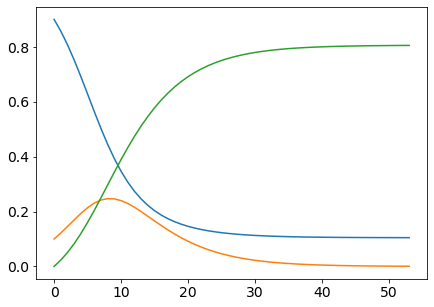

time: 448 ms (started: 2022-06-30 20:28:23 +00:00)


In [ ]:
i0 = 0.1
T = 200
R0 = 2.5
gamma= 0.19

beta = R0*gamma
n = county_pop
S,I,R = deterministic_sir(beta, gamma, n, 54, i0, s0=None,h=1)
print(I[-1]/n)
print(S[-1]/n)
print(R[-1]/n)
fig, ax= plt.subplots(figsize=(7, 5))
plt.plot([s/county_pop for s in S],label='S')
plt.plot([i/county_pop for i in I],label='I')
plt.plot([r/county_pop for r in R],label='R')

519
Final size: 0.23245358080796938


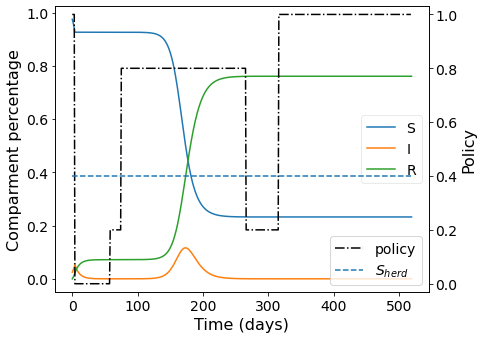

time: 1.2 s (started: 2022-07-07 05:16:31 +00:00)


In [ ]:
# 1/23/20 - 3/15/20
# LA
# get la policy
df_la = plot_real_policy(df_policy, 'Los Angeles County', 'CA', plot=False, start_date=None, end_date=None,save=False)
policy_la = df_la['Stay_at_Home_Order_Recommendation']
county_pop = 10.04e6
i0 = 0.025
T = 200
R0 = 2.5
gamma= 0.14

beta = R0*gamma
# n = county_pop
# S,I,R = deterministic_sir(beta, gamma, n, 54, i0, s0=None,h=1)
# print(I[-1]/n)
# print(S[-1]/n)
# print(R[-1]/n)
# fig, ax= plt.subplots(figsize=(7, 5))
# plt.plot([s/county_pop for s in S],label='S')
# plt.plot([i/county_pop for i in I],label='I')
# plt.plot([r/county_pop for r in R],label='R')
# i0 = 0.1
# T = 200
# R0 = 1.5
# gamma= 0.14
beta = R0*gamma
# S1 = [S[-1]]
# I1 = [I[-1]]
# R1 = [R[-1]]
S1 = [(1-i0)*county_pop]
I1 = [i0*county_pop]
R1 = [0]
T = len(policy_la.values)
print(T)

for t in range(T):
  alpha = policy_la.values[t]/5
  S_new,I_new,R_new = update_SIR(S1[-1],I1[-1],R1[-1], alpha,county_pop, beta, gamma)
  S1.append(S_new)
  I1.append(I_new)
  R1.append(R_new)

fig, ax= plt.subplots(figsize=(7, 5))
plt.plot([s/county_pop for s in S1],label='S')
plt.plot([i/county_pop for i in I1],label='I')
plt.plot([r/county_pop for r in R1],label='R')
plt.legend(framealpha=0.4,loc='right')
ax.set_ylabel('compartment percentage')
plt.xlabel('Time (days)')
ax2 = ax.twinx()
ax2.set_ylim(-.03,1.03)
ax2.plot(policy_la.values/5, label= 'policy',linestyle='dashdot',color ='k')
ax2.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
ax2.set_ylabel('Policy')
plt.legend(ncol=1,loc='best')

plt.tight_layout()
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_bliman.pdf")
# print(new_path)
# plt.savefig(new_path,figsize=(7,5))
print('Final size:',S1[-1]/county_pop)

Final size: 0.3874688864588491


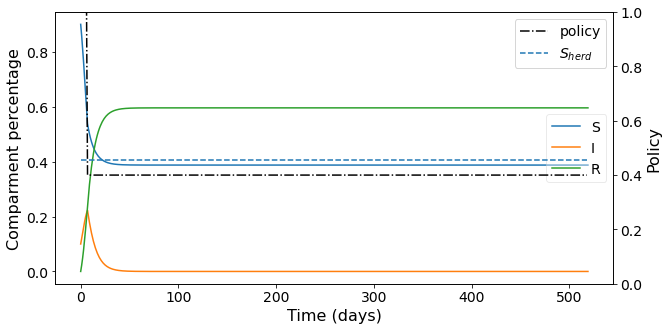

time: 1.52 s (started: 2022-06-30 20:05:12 +00:00)


In [ ]:
# NYC
# get policy
df = plot_real_policy(df_policy, 'New York County', 'NY', plot=False, start_date=None, end_date=None,save=False)
policy = df['Stay_at_Home_Order_Recommendation']
county_pop = 1629153
i0 = 0.1
T = 200
R0 = 2.2
gamma= 0.2
beta = R0*gamma
# n = county_pop
# S,I,R = deterministic_sir(beta, gamma, n, 54, i0, s0=None,h=1)
# print(I[-1]/n)
# print(S[-1]/n)
# print(R[-1]/n)
# fig, ax= plt.subplots(figsize=(7, 5))
# plt.plot([s/county_pop for s in S],label='S')
# plt.plot([i/county_pop for i in I],label='I')
# plt.plot([r/county_pop for r in R],label='R')
# S1 = [S[-1]]
# I1 = [I[-1]]
# R1 = [R[-1]]
S1 = [(1-i0)*county_pop]
I1 = [i0*county_pop]
R1 = [0]
T = len(policy.values)
# print(T)

for t in range(T):
  alpha = policy.values[t]/5
  S_new,I_new,R_new = update_SIR(S1[-1],I1[-1],R1[-1], alpha,county_pop, beta, gamma)
  S1.append(S_new)
  I1.append(I_new)
  R1.append(R_new)

fig, ax= plt.subplots(figsize=(10, 5))
plt.plot([s/county_pop for s in S1],label='S')
plt.plot([i/county_pop for i in I1],label='I')
plt.plot([r/county_pop for r in R1],label='R')
plt.legend(framealpha=0.4,loc='right')
ax.set_ylabel('compartment percentage')
plt.xlabel('Time (days)')
ax2 = ax.twinx()
ax2.plot(policy.values/5, label= 'policy',linestyle='dashdot',color ='k')
ax2.set_ylim(0,1)
ax2.plot([gamma/beta]*T,'--',label=r'$S_{herd}$')
ax2.set_ylabel('Policy')
plt.legend(ncol=1,loc='best')
# new_path = os.path.join(PATH,"SingleCounty/optimal_policy_bliman.pdf")
# print(new_path)
# plt.savefig(new_path,figsize=(7,5))
print('Final size:',S1[-1]/county_pop)

# Covid, real data

In [ ]:
PATH = '/content/drive/MyDrive/Research/PolicySIR/figure'
#confirmed cases
url_c = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
confirmed_data = pd.io.parsers.read_csv(url_c)

#death
url_d = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
death_data = pd.io.parsers.read_csv(url_d)

#13 th column is the first day

data_CA = confirmed_data.loc[confirmed_data["Province_State"] == "California"]

time: 565 ms (started: 2022-08-31 21:55:24 +00:00)


In [ ]:
death_la = death_data.loc[confirmed_data["Admin2"] == "Los Angeles"]
print(death_la.loc[:,'10/25/20':'11/5/20'])
7074/(1.88*1e-2)/(10.04*1e6)

     10/25/20  10/26/20  10/27/20  10/28/20  10/29/20  10/30/20  10/31/20  \
215      6993      7000      7027      7040      7044      7056      7071   

     11/1/20  11/2/20  11/3/20  11/4/20  11/5/20  
215     7074     7076     7097     7118     7140  


0.0374777485801475

time: 13.7 ms (started: 2022-08-31 21:55:25 +00:00)


In [ ]:
# data_CA.loc[:,'3/15/20':'8/15/21']

time: 817 µs (started: 2022-07-21 19:06:44 +00:00)


In [ ]:
def plot_covid_data(df, county,state, county_pop, start_date='3/14/20', end_date='8/15/21'):
  data_county = df.loc[(df["Province_State"] == state) &(df["Admin2"] == county)]
  # print(data_county.head())
  fig, ax = plt.subplots(figsize=(7, 5))
  # sns.set_theme(style="whitegrid")
  # print(data_county.loc[:,start_date:end_date].diff(axis=1))
  # print(data_county.loc[:,start_date:end_date].rolling(7, min_periods=1).mean().diff(axis=1))
  # print(type(data_county.loc[:,start_date:end_date].rolling(7, min_periods=1).mean()))
  print('Cumulative:',data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean()/county_pop)
  data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop

  # remove negative data
  data[data<=0] = 0
  # data.dropna()
  print(data.head())
  sns.lineplot(data=data.iloc[0,1:], palette="tab10", linewidth=2.5,label = county)
  ax.xaxis.set_major_locator(plt.MaxNLocator(12))
  plt.xticks(rotation = 30,fontsize=12)
  # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
  plt.title('Daily incresed cases percentage',fontsize=BIGGER_SIZE)
  plt.ylabel('Infected percentage')
  plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
  plt.legend(fontsize=SMALL_SIZE)
  return data_county

time: 4.84 ms (started: 2022-08-31 21:55:28 +00:00)


In [ ]:
# covid_la = plot_covid_data(confirmed_data, 'Los Angeles','California', 1.04e7,start_date= '3/20/20',end_date = '11/1/20')

time: 984 µs (started: 2022-07-11 23:54:22 +00:00)


In [ ]:
# plot_covid_data(confirmed_data, 'New York','New York', 8.38e6)

time: 917 µs (started: 2022-07-11 23:54:23 +00:00)


In [ ]:
def plot_covidnpolicy(df,df_policy, county,state, county_pop, start_date='3/14/20', end_date='8/15/21'):
  # plot policy
  df_county_policy = df_policy[(df_policy['County_Name'] == county) & (df_policy['State_Tribe_Territory'] == state)]
  df_county_policy = df_county_policy.sort_values(by='date')
  # print(df_county.head())
  fig, ax = plt.subplots(figsize=(7, 5))
  # print(df_county['date'])

  plt.plot(df_county_policy['date'], df_county_policy['Stay_at_Home_Order_Recommendation'],label=county)
  # plt.ylim((0,6))
  ax.xaxis.set_major_locator(plt.MaxNLocator(10))
  ax.set_ylabel('Policy')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
  plt.xticks(rotation = 30,fontsize=12)
  # plt.title('Stay-at-home policy',fontsize=BIGGER_SIZE)

  #   plt.savefig(new_path,figsize=(7,5))
  # return df_county
  ax2 = ax.twinx()
  ax2.set_ylabel('Infected percentage')
  data_county = df.loc[(df["Province_State"] == state) &(df["Admin2"] == county)]
  # print(data_county.head())

  data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop
  print(data.head())
  # remove negative data
  data[data<=0] = 0
  # data.dropna()
  print(data.head())
  ax2 = sns.lineplot(data=data.iloc[0,1:], palette="tab10", linewidth=2.5,label = county)
  ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
  plt.xticks(rotation = 30,fontsize=12)
  # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
  plt.title('Daily incresed cases percentage and policy',fontsize=BIGGER_SIZE)
  ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
  plt.legend(fontsize=SMALL_SIZE)
  if save:
    new_path = os.path.join(PATH,"policy_cali_real.eps")
    print(new_path)

time: 2.69 ms (started: 2022-08-31 21:55:31 +00:00)


       State_Tribe_Territory      County_Name  FIPS_State  FIPS_County  \
542944                    NY  New York County          36           61   
542945                    NY  New York County          36           61   
542946                    NY  New York County          36           61   
542947                    NY  New York County          36           61   
542948                    NY  New York County          36           61   

             date  Order_code  Stay_at_Home_Order_Recommendation  \
542944 2020-03-15           7                                5.0   
542945 2020-03-16           7                                5.0   
542946 2020-03-17           7                                5.0   
542947 2020-03-18           7                                5.0   
542948 2020-03-19           7                                5.0   

       Express_Preemption Source_of_Action  URL Citation  
542944                NaN              NaN  NaN      NaN  
542945                NaN   

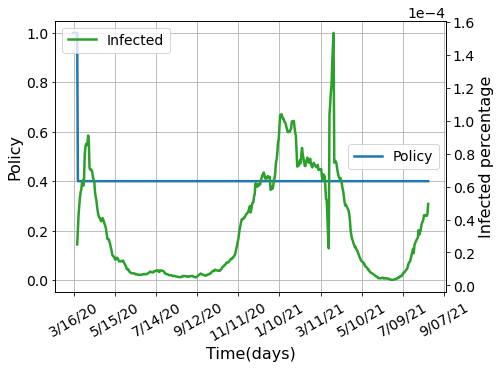

time: 1.14 s (started: 2022-07-06 21:24:21 +00:00)


In [ ]:
# plot policy and infected in the same plot
# Secondary y-axis
fig, ax= plt.subplots(figsize=(7, 5))
df_county_policy = df_policy[(df_policy['County_Name'] == 'New York County') & (df_policy['State_Tribe_Territory'] == 'NY')]
df_county_policy = df_county_policy.sort_values(by='date')
print(df_county_policy.head())
df_county_policy['Stay_at_Home_Order_Recommendation'] = df_county_policy['Stay_at_Home_Order_Recommendation']/5
ax.plot(df_county_policy['date'], df_county_policy['Stay_at_Home_Order_Recommendation'],label = 'Policy',linewidth=2.5)
ax.legend(loc='right')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
ax.grid()
# df_county_policy.plot(x='date', y= 'Stay_at_Home_Order_Recommendation', ax = ax, legend= True,grid=True, label='Policy',linewidth=2.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlabel('Time(days)')
ax.set_ylabel('Policy')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# ax.ticklabel_format(axis='y', style='sci')
ax.tick_params(axis='x',rotation=30)
ax.set_ylim(-0.05,1.05)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

start_date='3/14/20'
end_date='8/15/21'
county_pop = 8.38e6
ax2 = ax.twinx()
ax2.set_ylabel('Infected percentage')
data_county = confirmed_data.loc[(confirmed_data["Province_State"] == 'New York') &(confirmed_data["Admin2"] == 'New York')]
data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
# print(data.head())
# remove negative data
data[data<=0] = 0
data=data.iloc[0,1:]

df_county_policy['infected'] = data.values
ax2.plot(df_county_policy['date'], df_county_policy['infected'],label = 'Infected',color=county_color[0],linewidth=2.5)
ax2.legend(loc='upper left')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))

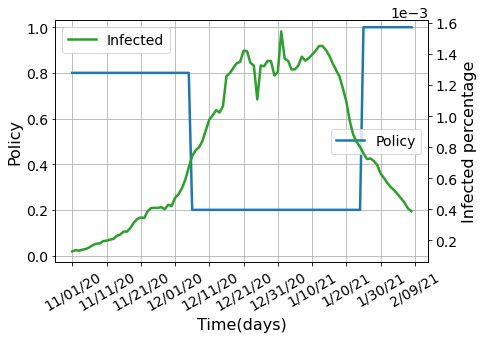

time: 1.12 s (started: 2022-07-07 16:27:41 +00:00)


In [ ]:
# plot policy and infected in the same plot
# Secondary y-axis
fig, ax= plt.subplots(figsize=(7, 5))
# df_county_policy = df_policy[(df_policy['County_Name'] == 'Los Angeles County') & (df_policy['State_Tribe_Territory'] == 'CA')]
# df_county_policy = df_county_policy.sort_values(by='date')
# df_county_policy['Stay_at_Home_Order_Recommendation'] = df_county_policy['Stay_at_Home_Order_Recommendation']/5
# print(df_county_policy.head())
# df_county_policy['date'] = pd.to_datetime(df_county_policy.date)
# df_county_policy.set_index('date', inplace=True)

start_date = '11/1/2020'
end_date = '2/8/2021'
df_county_policy = plot_real_policy(df_policy, 'Los Angeles County', 'CA',plot=False, start_date=start_date, end_date=end_date,save=False)
df_county_policy['Stay_at_Home_Order_Recommendation'] = df_county_policy['Stay_at_Home_Order_Recommendation']/5
ax.plot(df_county_policy['date'], df_county_policy['Stay_at_Home_Order_Recommendation'],label = 'Policy',linewidth=2.5)
ax.legend(loc='right')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
ax.grid()
# df_county_policy.plot(x='date', y= 'Stay_at_Home_Order_Recommendation', ax = ax, legend= True,grid=True, label='Policy',linewidth=2.5)

ax.set_xlabel('Time(days)')
ax.set_ylabel('Policy')
# ax.ticklabel_format(axis='y', style='sci')
ax.tick_params(axis='x',rotation=30)
ax.set_ylim(-0.03,1.03)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))

start_date='10/25/20'
end_date='2/8/21'
county_pop = 1.04e7
ax2 = ax.twinx()
ax2.set_ylabel('Infected percentage')
data_county = confirmed_data.loc[(confirmed_data["Province_State"] == 'California') &(confirmed_data["Admin2"] == 'Los Angeles')]
data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop
# print(data.head())
# remove negative data
data[data<=0] = 0
data=data.iloc[0,7:]

df_county_policy['infected'] = data.values
ax2.plot(df_county_policy['date'], df_county_policy['infected'],label = 'Infected',color=county_color[0],linewidth=2.5)
ax2.legend(loc='upper left')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%-m/%d/%y'))
plt.tight_layout()

# plt.show()
# plt.legend(fontsize=SMALL_SIZE)
# if save:
#   new_path = os.path.join(PATH,"policy_cali_real.eps")
#   print(new_path)

In [ ]:
df_county_policy.loc[:,'infected']

59828     0.000130
59829     0.000137
59830     0.000134
59831     0.000141
59832     0.000145
            ...   
990378    0.000497
990379    0.000470
990380    0.000442
990381    0.000406
990382    0.000388
Name: infected, Length: 100, dtype: float64

time: 22.2 ms (started: 2022-07-07 16:27:47 +00:00)


In [ ]:
df_county_policy.date

59597    2020-03-15
59598    2020-03-16
59599    2020-03-17
59600    2020-03-18
59601    2020-03-19
            ...    
990566   2021-08-11
990567   2021-08-12
990568   2021-08-13
990569   2021-08-14
990570   2021-08-15
Name: date, Length: 519, dtype: datetime64[ns]

time: 18.1 ms (started: 2022-07-06 20:57:03 +00:00)


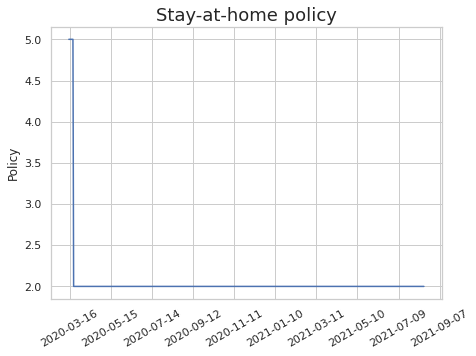

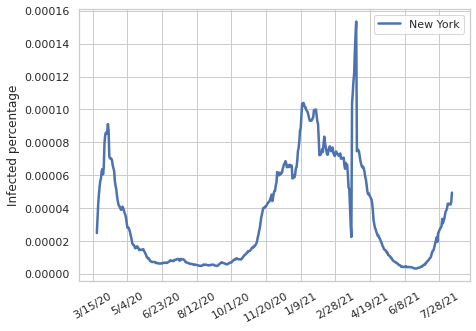

time: 1.32 s (started: 2022-06-23 17:17:11 +00:00)


In [ ]:
# plot policy
county_pop = 8.38e6
df_county_policy = df_policy[(df_policy['County_Name'] == 'New York County') & (df_policy['State_Tribe_Territory'] == 'NY')]
df_county_policy = df_county_policy.sort_values(by='date')
# print(df_county_policy.head())
fig, ax = plt.subplots(figsize=(7, 5))
# print(df_county['date'])
ax.plot(df_county_policy['date'], df_county_policy['Stay_at_Home_Order_Recommendation'],label='Policy')
# plt.ylim((0,6))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylabel('Policy')
plt.xticks(rotation=30 )
plt.title('Stay-at-home policy',fontsize=BIGGER_SIZE)
# plot covid
fig, ax2 = plt.subplots(figsize=(7, 5))
ax2.set_ylabel('Infected percentage')
data_county = confirmed_data.loc[(confirmed_data["Province_State"] == 'New York') &(confirmed_data["Admin2"] == 'New York')]
# print(data_county.iloc[:,65:70])
# print(data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop)
data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop
# print(data.head())
# remove negative data
data[data<=0] = 0
# data.dropna()
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
xlabels = ax2.get_xticklabels()
# ax2.set_xticklabels(xlabels, Rotation=30)
plt.xticks(rotation=30 )
# ax2.set_xticks(ticks='x',fontsize=12)
ax2 = sns.lineplot(data=data.iloc[0,1:], palette="tab10", linewidth=2.5,label = 'New York')
plt.show()

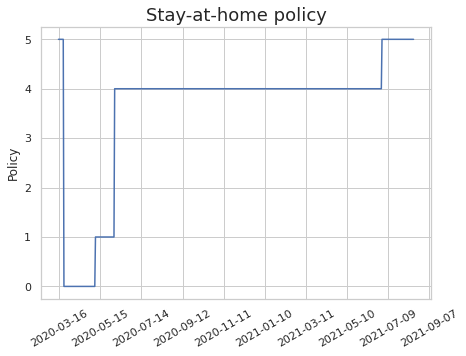

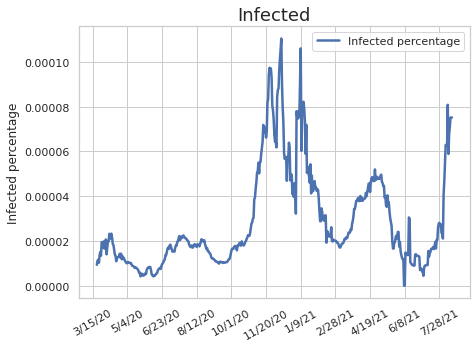

time: 2.1 s (started: 2022-06-23 18:15:26 +00:00)


In [ ]:
# plot policy
county_pop = 8.38e6
df_county_policy = df_policy[(df_policy['State_Tribe_Territory'] == 'WA') & (df_policy['County_Name'] == 'King County')]
df_county_policy = df_county_policy.sort_values(by='date')
# print(df_county_policy.head())
fig, ax = plt.subplots(figsize=(7, 5))
# print(df_county['date'])
ax.plot(df_county_policy['date'], df_county_policy['Stay_at_Home_Order_Recommendation'],label='Policy')
# plt.ylim((0,6))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylabel('Policy')
plt.xticks(rotation=30 )
plt.title('Stay-at-home policy',fontsize=BIGGER_SIZE)
# plot covid
fig, ax2 = plt.subplots(figsize=(7, 5))
ax2.set_ylabel('Infected percentage')
data_county = confirmed_data.loc[(confirmed_data["Province_State"] =='Washington' ) &(confirmed_data["Admin2"] == 'King')]
# print(data_county.iloc[:,65:70])
# print(data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop)
data = data_county.loc[:,start_date:end_date].rolling(7,axis=1).mean().diff(axis=1)/county_pop
# print(data.head())
# remove negative data
data[data<=0] = 0
# data.dropna()
ax2.xaxis.set_major_locator(plt.MaxNLocator(12))
xlabels = ax2.get_xticklabels()
# ax2.set_xticklabels(xlabels, Rotation=30)
plt.xticks(rotation=30 )
# ax2.set_xticks(ticks='x',fontsize=12)
ax2.set_title('Infected',fontsize=BIGGER_SIZE)
ax2 = sns.lineplot(data=data.iloc[0,1:], palette="tab10", linewidth=2.5,label = 'Infected percentage')
plt.show()

In [ ]:
df_policy[ (df_policy['State_Tribe_Territory'] == 'WA')]['County_Name'].unique()

array(['Garfield County', 'Grays Harbor County', 'Lewis County',
       'Spokane County', 'Adams County', 'Asotin County', 'Benton County',
       'Chelan County', 'Clallam County', 'Clark County',
       'Columbia County', 'Cowlitz County', 'Douglas County',
       'Ferry County', 'Franklin County', 'Grant County', 'Island County',
       'Jefferson County', 'King County', 'Kitsap County',
       'Kittitas County', 'Klickitat County', 'Lincoln County',
       'Mason County', 'Okanogan County', 'Pacific County',
       'Pend Oreille County', 'Pierce County', 'San Juan County',
       'Skagit County', 'Skamania County', 'Snohomish County',
       'Stevens County', 'Thurston County', 'Wahkiakum County',
       'Walla Walla County', 'Whatcom County', 'Whitman County',
       'Yakima County'], dtype=object)

time: 415 ms (started: 2022-06-23 18:12:32 +00:00)


In [ ]:
confirmed_data.loc[(confirmed_data["Province_State"] == 'Washington')]['Admin2'].unique()

array(['Adams', 'Asotin', 'Benton', 'Chelan', 'Clallam', 'Clark',
       'Columbia', 'Cowlitz', 'Douglas', 'Ferry', 'Franklin', 'Garfield',
       'Grant', 'Grays Harbor', 'Island', 'Jefferson', 'King', 'Kitsap',
       'Kittitas', 'Klickitat', 'Lewis', 'Lincoln', 'Mason', 'Okanogan',
       'Out of WA', 'Pacific', 'Pend Oreille', 'Pierce', 'San Juan',
       'Skagit', 'Skamania', 'Snohomish', 'Spokane', 'Stevens',
       'Thurston', 'Unassigned', 'Wahkiakum', 'Walla Walla', 'Whatcom',
       'Whitman', 'Yakima'], dtype=object)

time: 19.9 ms (started: 2022-06-23 18:12:40 +00:00)


3/11/20         NaN
3/12/20         NaN
3/13/20         NaN
3/14/20         NaN
3/15/20         NaN
3/16/20         NaN
3/17/20         NaN
3/18/20    0.000002
3/19/20    0.000003
3/20/20    0.000003
Name: 215, dtype: float64


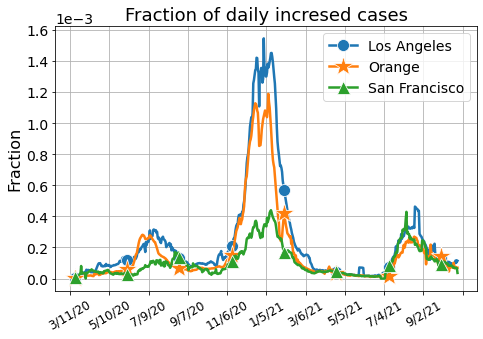

time: 1.7 s (started: 2022-08-31 22:11:24 +00:00)


In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
# sns.set_theme(style="whitegrid")
ax.grid()
# cities = ['Orange','Ventura','Tehama','San Luis Obispo']
cities = ['San Francisco','Orange','Los Angeles']
confirmed_city = data_CA[data_CA.Admin2.isin(cities)]
confirmed_city
# plt.plot(confirmed_city.iloc[0,11:-1].diff(),label = 'San Luis Obispo')
# # plt.plot(confirmed_city.iloc[0,11:-1],label = 'Orange')
# plt.plot(confirmed_city.iloc[1,11:-1].diff(),label = 'Tehama')
# plt.plot(confirmed_city.iloc[2,11:-1].diff(),label = 'Ventura')
data = confirmed_city.iloc[0,60:-310].rolling(7).mean().diff()/1.04e7
data[data<=0] = 0
print(data[:10])
sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'Los Angeles',marker="o",markevery=80,markersize=12)
data = confirmed_city.iloc[1,60:-310].rolling(7).mean().diff()/3.176e6
data[data<=0] = 0
# print(data[10:20])
sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'Orange',marker='*',markevery=80,markersize=20)
data = confirmed_city.iloc[2,60:-310].rolling(7).mean().diff()/874961
data[data<=0] = 0
# print(data[10:20])
sns.lineplot(data=data, palette="tab10", linewidth=2.5,label = 'San Francisco',marker='^',markevery=80,markersize=13)
# plt.plot(confirmed_city.iloc[2,60:-150].rolling(7).mean().diff()/874961,label = 'San Francisco')
# plt.plot(confirmed_city.iloc[1,60:-150].rolling(7).mean().diff()/3.176e6,label = 'Orange')
# plt.plot(confirmed_city.iloc[0,60:-150].rolling(7).mean().diff()/1.04e7,label = 'Los Angeles')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.xticks(rotation = 30,fontsize=12)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# plt.title('Daily incresed cases percentage',fontsize=BIGGER_SIZE)
plt.title('Fraction of daily incresed cases',fontsize=BIGGER_SIZE)
plt.ylabel('Fraction')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
plt.legend(fontsize=SMALL_SIZE)
plt.tight_layout()
new_path = os.path.join(PATH,"I_cali_real.eps")
plt.savefig(new_path,figsize=(7,5))